In [26]:
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
%matplotlib inline

### Implementando Convolução

Desenvolver em Python a operação de convolução Dw x Dw x C, com bias e função de ativação (ReLU e tanh), stride (inteiro positivo) e zero padding (boolean) especificados pelo usuário em tempo de execução. A máscara convolucional e o viés devem ser especificados em arquivo texto a ser lido durante a execução. Apresentar resultados com imagens RGB e em níveis de cinza, e com volumes Df x Df x N, produzidos a partir da aplicação prévia de N filtros convolucionais. Para visualização, os mapas de ativação devem ser convertidos para imagens em níveis de cinza no intervalo [0, 255], com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.  

### Parte 1 - Operação de Convolução

Uma operação de convolução, dada pela equação abaixo, pode ser realizada a partir da aplicação de uma máscara/filtro convolucional para cada pixel da imagem.  

\begin{align}
g[n] = \sum_{\tau=-\infty}^\infty s[\tau] h[n]-\tau]
\end{align}

Na equação, g é o resultado da operação, s o sinal de entrada e h a máscara convolucional. A Figura abaixo exemplifica a operação para um pixel em uma imagem de dimensão 8x8, utilizando máscara 3x3.

![title](imgs/conv.jpg)

Para realizar a operação em Python, duas funções deverão ser implementadas: zero_pad(X) e convolution(X, kernel, stride, padding), em que X é a imagem de entrada. Na função zero_pad(X), caso o usuário deseje realizar a operação de padding, a função deverá preencher a imagem de entrada com zeros, retornando a matriz X_pad. O método numpy.pad não deverá ser utilizado para realização dessa operação.

Na função convolution(X,kernel,stride,padding), implemente a operação de convolução propriamente dita utilizando apenas funçoes básicas da biblioteca Numpy (i.e. função convolve, convolve2d, pad e outras do Numpy não serão permitidas nesse exercício). A função retornará uma matriz out_conv e deverá ser testada com imagens RGB e em níveis de cinza, considerando quatro casos principais:

1: stride = 1 e padding True: adicione uma extensão por zeros na imagem e deslize a máscara a cada pixel da imagem;

2: stride = 1 e padding False: não utilize extensão por zeros e deslize a máscara a cada pixel da imagem;

3: stride > 1 e padding True: adicione uma extensão por zeros na imagem e deslize a máscara a cada S pixels da imagem, em que S é o valor do stride fornecido pelo usuário;

4: stride > 1 e padding False: não dicione uma extensão por zeros na imagem e deslize a máscara a cada S pixels da imagem, em que S é o valor do stride fornecido pelo usuário;

OBS: ao utilizar stride > 1 ou padding, poderá ser necessário tratar casos em que a operação ultrapasse a dimensão da imagem X. 

In [15]:
def zero_pad(X, filterSize):
    """
    Função para adicionar extensão por zeros na imagem de entrada.
    Parametro: X - imagem de entrada
    Parametro: filterSize - Tamanho do filtro convolucional
    Retorno: X_pad - imagem resultante da extensão por zeros. 
    """
    
    #h,w,c = X.shape
    try:
        h,w,c = X.shape
    except ValueError:
        h,w = X.shape
        c = 1
        X = X.reshape((h,w,c))
    
    X_pad = np.zeros((h+filterSize-1,w+filterSize-1,c))
    
    padding_begin=int((filterSize-1)/2)
    padding_height=int(padding_begin+h)
    padding_width=int(padding_begin+w)
    
    X_pad[padding_begin:padding_height,padding_begin:padding_width,:] = X
    return X_pad

In [50]:
def convolution(X,filters, filter_size, stride=1, padding=True):
    """
    Função para implementar a operação de convolução.
    Parametros: X - imagem de entrada
                filters - matriz com o kernel a ser utilizado pela operação
                filter_size - tamanho do filtro convolucional
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    retorno out_conv: matriz resultante da operação de convolução
    """    
    h,w,c = X.shape
    ###out_h = int((h-filter_size+1)/stride)
    ###out_w = int((w-filter_size+1)/stride)
    out_h = int(((h-filter_size)/stride)+1)
    out_w = int(((w-filter_size)/stride)+1)
    
    out_conv = np.zeros(( out_h, out_w ))
    print('\nFormato da saída da convolução: ', out_conv.shape)
    
    for rows in range(0,h-filter_size+1,stride):
        for cols in range(0,w-filter_size+1,stride):
            out_conv[int(rows/stride),int(cols/stride)] = np.sum(np.multiply(X[rows:rows+filter_size,cols:cols+filter_size,:],filters))

    #plt.imshow(out_conv, cmap='gray',vmin = 0, vmax = 255) 
    print('\tMin = ', min(out_conv.ravel()), 'Max = ', max(out_conv.ravel()))
    
    plt.imshow(out_conv) 
    plt.show()
    
    return out_conv

In [39]:
def subsample(X, sample_size, stride=1):
    h,w,c = X.shape
    out_h = int(((h-sample_size)/stride)+1)
    out_w = int(((w-sample_size)/stride)+1)
    
    out_sample = np.zeros(( out_h, out_w, c ))
    print('\nFormato da saída do Subsample: ', out_sample.shape)
    
    for layer in range(0,c):
        for rows in range(0,h-sample_size+1,stride):
            for cols in range(0,w-sample_size+1,stride):
                out_sample[int(rows/stride),int(cols/stride),layer] = X[rows:rows+sample_size,cols:cols+sample_size,layer].max()

    #plt.imshow(out_sample, cmap='gray',vmin = 0, vmax = 255) 
    #print('\tMin = ', min(out_sample.ravel()), 'Max = ', max(out_sample.ravel()))
    
    #plt.imshow(out_sample)
    #plt.show()
    
    return out_sample

### Parte 2 - Camada convolucional 

Uma vez implementada a função convolution, pode-se implementar uma camada convolucional por meio da função convLayer(X,C,act_func, kernel, stride, padding). Uma camada convolucional é ilustrada conforme Figura abaixo.

Na Figura, uma imagem de entrada 32x32x3 é utilizada com 6 máscaras 5x5x3. Para cada filtro individualmente, aplica-se o bias (offset) seguido pela aplicação da função de ativação para formar seis mapas de característica (feature maps) de dimensão 28x28x6 (32 - 4 por não utilizar padding e 6 igual a quantidade de máscaras dessa camada).

![title](imgs/convlayer.png)


Baseado nisso, para implementar a camada, deve-se seguir como passos principais:

1. Inicializar a matriz fmap: essa matriz pode ser criada utilizando numpy (e.g. np.zeros) e deverá conter a dimensão de saída do feature map (e.g. 28x28x6). Para calcular essa dimensão, utilize a equação abaixo, em que C é igual ao volume do feature map:
\begin{align}
n_H = (X_H - filter_H+2*padding)/stride+1\\
n_W = (X_W - filter_W+2*padding)/stride+1\\
n_C = C
\end{align}

2. Se padding for necessário, realizar a operação implementada pela função zero_pad(X);

3. Implementar função de ativação. As funções de ativação definem o intervalo de valores que a saída do neurônio poderá ter. Nsse Notebook, duas funções de ativação devem ser implementadas (ReLU e Tanh). As funçoes, suas respectivas saídas e gráfico deverão ser similares ao exposto abaixo: 

-> Retificadora (Relu): saída 0 caso entrada seja negativa e maior que 1 caso contrário
$$ \begin{equation}
  relu = max(0,x)
\end{equation} $$
![alt text](imgs/relu.png "Title")
-> Tangente Hiperbólica: saída entre [-1,1]
$$ \begin{equation}
  tanh = \frac{2}{(1+e^{-2*z})} - 1
\end{equation} $$
![alt text](imgs/tanh.png "Title")

4. Para cada filtro, produzir um feature map a partir da aplicação da convolução, adicionando-se um bias e utilizando a função de ativação implementada na etapa 3.

5. Visualizar o feature map convertendo-o para uma imagem em níveis de cinza no intervalo [0, 255], com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.



In [40]:
def relu(num):
    return max(0,num)

In [41]:
def tanh(num):
    try:
        ans = math.exp(-(2*num))
    except OverflowError:
        ans = float('inf')

    return (2/(1+(ans)))-1
    #return 1-(math.tanh(num))


In [42]:
def softmaxExponential(num):
    return math.exp(num)

In [64]:
def softmax(matrix):
    print('\n\nMatriz Antes: \n', matrix)
    matrix = np.reshape((list(map(softmaxExponential,matrix.ravel()))), matrix.shape)
    print('\n\Matriz Depois: \n', matrix)
    total = np.sum(matrix)
    print('\n\nTotal: \n', total)
    
    return np.divide(matrix,total)
    

In [71]:
def activation_func(func_type, z):
    """
    Função que implementa as funções de ativação ReLU e Tanh
    Parãmetros: func_type - uma string que contém a função de ativação desejada
                z - matriz resultante da convolução e do bias.
    Retorna: feature map
    """
    ### Seu código aqui (~2 linhas)
    if func_type == 'relu':
        ##Para cada pixel, substituir os valores menores que zero para zero, retornando matriz resultante
        #return list(map(lambda x: max(0,x), z))
        return np.reshape((list(map(relu,z.ravel()))), z.shape)
    elif func_type == 'tanh':
        ##Para cada pixel, mapear seus valores entre -1 e 1, retornando matriz resultante
        ###print('\n\nValores antes da função de ativação tanh: \tMin = ', min(z.ravel()), 'Max = ', max(z.ravel()))
        
        p = np.reshape((list(map(tanh,z.ravel()))), z.shape)
        if min(p.ravel()) == max(p.ravel()):
            print('\n\tNão foi possível efetuar a ativação pela função hiperbólica. Valor mínimo e máximo são iguais')
            return z
    elif func_type == 'softmax':
        #return softmax(z)
        return z
            
        ###print('\n\nValores depois da função de ativação tanh: \tMin = ', min(p.ravel()), 'Max = ', max(p.ravel()))
        return p

In [72]:
def visualize_fmap(X):
    """
    Função que convertendo-o para uma imagem em níveis de cinza no intervalo [0, 255], 
    com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.
    """
    h,w,c = X.shape
    
    ###Exibição ABS com preto = 0
    
    #Calcula o módulo da matriz
    ABS = abs(X)
    
    #Subtrai o menor valor em todos os elementos da matriz
    ABS = np.subtract(ABS, min(ABS.ravel()))
    
    #Mapeia a matriz para [0,255] 
    map_value_abs = (255/max(ABS.ravel()))
    ABS = np.multiply(ABS, map_value_abs)
    
    print('\n\n\t\tFeature Map em valor ABS com preto = zero : ')
    for layer in range(0,c):
        plt.imshow(ABS[:,:,layer], cmap='gray') 
        plt.show() 
    
    ###Exibição MIN = preto
    MIN = X
    
    #Subtrai o menor valor em todos os elementos da matriz
    MIN = np.subtract(MIN, min(MIN.ravel()))
    
    #Mapeia a matriz para [0,255] 
    map_value_min = (255/max(MIN.ravel()))
    MIN = np.multiply(MIN, map_value_min)
    
    print('\n\n\t\tFeature Map com mínimo = preto : ')
    
    for layer in range(0,c):
        plt.imshow(MIN[:,:,layer], cmap='gray') 
        plt.show() 
    
    #for layer in range(0,c):
        #plt.imshow(X[:,:,layer], cmap='gray',vmin = 0, vmax = 255) 
        #plt.show()  
    

In [73]:
def convLayer(imageFile,C,act_func, filters, stride, padding, filter_size):
    """
    Implementa a camada convolucional utilizando bias e função de ativação.
    Parametros: imageFile - matriz de entrada
                C - quantidade de canais do feature map
                filters - filtros utilizados na camada
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    Retorno: fmap - feature map de dimensão (n_W,n_H, C)
    """
    
    ##Inicia matriz fmap considerando o padding e o stride para determinar o tamanho final e quantidades de Canais
    #h,w,c = imageFile.shape
    try:
        h,w,c = imageFile.shape
    except ValueError:
        h,w = imageFile.shape
        c = 1
        imageFile = imageFile.reshape((h,w,c))

    fmap = np.zeros((int(((h-filter_size)/stride)+1), int(((w-filter_size)/stride)+1), C))
    ####fmap = np.zeros(( int((h-filter_size+1)/stride), int((w-filter_size+1)/stride), C))
    
    current_filter = np.zeros((filter_size, filter_size, c)) #Filtro com 3 dimensões (c = número de camadas)
    current_bias = 0
    ptr_filter = filter_size
    
    ##Para cada filtro, chamar a função de convolução       
    rows, cols = filters.shape
    number_filters = int(rows/filter_size)
    
    for count in range(0, C):
        current_bias = filters[ptr_filter-1,0]  #Armazena o bias do filtro específico contido no arquivo csv
        for layer in range(0,c):
            current_filter[:,:,layer] = filters[ptr_filter-filter_size:ptr_filter,1:]  #Preenche a matriz de filtro atual
            ptr_filter += filter_size
        print('\nFiltro Corrente: \n', current_filter, '\n')
        
        ##Adicionar o bias no resultado da convolução
        tmp_map = convolution(imageFile,current_filter, filter_size, stride, padding)
        tmp_map = np.add(tmp_map,current_bias)
        
        ##Chamar a função de ativação na matriz resultante
        tmp_map = activation_func(act_func, tmp_map)
        #print(min(tmp_map.ravel()), max(tmp_map.ravel())) ##Menor e maior valor depois da função de ativação
        
        ##Adicionar cada feature map da convolução anterior na matriz fmap
        fmap[:,:,count] = tmp_map
        
        #ptr_filter += filter_size
        
    #print('\n[Resultado] Feature Map: ', fmap)
    
    return fmap

### Parte 4 - Main

Para finalizar, utilize a função main para leitura dos filtros e bias obtidos a partir de um arquivo csv. O arquivo poderá ser lido a partir de métodos do numpy (e.g. genfromtxt e loadfromtxt). Uma vez que stride e padding deverão ser especificados pelo usuário, a função input do Numpy poderá ser utilizada para obter os valores. Por fim, a imagem de entrada poderá ser obtida por meio de métodos da biblioteca PIL (i.e. Image), OpenCV, entre outros.

In [74]:
def initialization_He(filter_size, quantity, average, neurons_previous_layer):
    out_matrix = np.zeros(((quantity*filter_size)+1,filter_size+1))
    
    out_matrix[0,0] = 0
    for col in range(1,filter_size+1):
        out_matrix[0,col] = col
    
    for line in range(1,quantity*filter_size, filter_size):
        out_matrix[line:line+filter_size, 0] = np.random.randint(1,15)
        
    variance = 2/neurons_previous_layer
    out_matrix[1:,1:] = np.sqrt(variance) * np.random.randn(quantity*filter_size,filter_size) + average
    
    return out_matrix

In [76]:
def main():
    ##Tamanho do Filtro (Dw x Dw x C)
    filter_size = 5
    
    #Inicializa os pesos com He
    #Salva os pesos em arquivo
    np.savetxt("filters/filters_layer_1.csv", initialization_He(filter_size, 6, 0, 32*32), delimiter=',')
    np.savetxt("filters/filters_layer_3.csv", initialization_He(filter_size, 96, 0, 28*28*6), delimiter=',')
    np.savetxt("filters/filters_layer_5.csv", initialization_He(filter_size, 1920, 0, 10*10*16), delimiter=',')
    filter_size = 1
    np.savetxt("filters/filters_layer_6.csv", initialization_He(filter_size, 10080, 0, 120), delimiter=',')
    np.savetxt("filters/filters_layer_7.csv", initialization_He(filter_size, 840, 0, 84), delimiter=',')
    
    ##Carregar os filtros do arquivos txt
    file_name = 'filters/filters_layer_1.csv'
    convFilters_1 = np.loadtxt(file_name, delimiter=',', dtype=float, skiprows=1)
    file_name = 'filters/filters_layer_3.csv'
    convFilters_3 = np.loadtxt(file_name, delimiter=',', dtype=float, skiprows=1)
    file_name = 'filters/filters_layer_5.csv'
    convFilters_5 = np.loadtxt(file_name, delimiter=',', dtype=float, skiprows=1)
    file_name = 'filters/filters_layer_6.csv'
    convFilters_6 = np.loadtxt(file_name, delimiter=',', dtype=float, skiprows=1)
    file_name = 'filters/filters_layer_7.csv'
    convFilters_7 = np.loadtxt(file_name, delimiter=',', dtype=float, skiprows=1)
    #print('Lista de filtros: \n',convFilters_1, '\n')
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    #plt.imshow(x_train[5], cmap=plt.get_cmap('gray'))
    print('\n\nFormato da imagem (MNIST): \n', x_train[5].shape)
    imageFile = x_train[5]
    
    stride = int(input("Entre com um valor inteiro positivo para o stride "))
    padding = input("Sua operaçao será feita com padding? True or False  ") 
    
    #imageFile = np.asarray(Image.open('imgs/sakura.jpg'))
    #print('\nFomato da Imagem Original',imageFile.shape)
    
    ##Tamanho do Filtro (Dw x Dw x C)
    filter_size = 5

    if padding=='True':
        padding = True
        imageFile = zero_pad(imageFile, filter_size)
        print('Padding adicionado', imageFile.shape)
        
    #plt.imshow(imageFile) 
    
    #fmap = convLayer(imageFile, 2, 'relu', convFilters_1, stride, padding, filter_size)
    
    fmap = convLayer(imageFile, 6, 'relu', convFilters_1, stride, padding, filter_size) #stride 1
    fmap = subsample(fmap, 2, 2)
    fmap = convLayer(fmap, 16, 'relu', convFilters_3, stride, padding, filter_size) #stride 1
    fmap = subsample(fmap, 2, 2)
    fmap = convLayer(fmap, 120, 'relu', convFilters_5, stride, padding, filter_size) #stride 1

    filter_size = 1
    fmap = convLayer(fmap, 84, 'relu', convFilters_6, stride, padding, filter_size) #stride 1
    fmap = convLayer(fmap, 10, 'softmax', convFilters_7, stride, padding, filter_size) #stride 1
    fmap = softmax(fmap)
    
    visualize_fmap(fmap)
    
    print('\n\nFormato do fmap: \n', fmap.shape)
    print('\n\nFmap: \n', fmap)
    



Formato da imagem (MNIST): 
 (28, 28)
Entre com um valor inteiro positivo para o stride 1
Sua operaçao será feita com padding? True or False  True
Padding adicionado (32, 32, 1)

Filtro Corrente: 
 [[[-0.01686354]
  [-0.04678721]
  [-0.04003148]
  [-0.02911477]
  [-0.01209907]]

 [[-0.02781095]
  [-0.01025844]
  [-0.01986473]
  [ 0.01025872]
  [-0.03322352]]

 [[-0.0146893 ]
  [ 0.02869152]
  [ 0.01636415]
  [-0.00372038]
  [-0.11596831]]

 [[-0.03134494]
  [ 0.03895763]
  [ 0.04114588]
  [-0.05791409]
  [-0.007796  ]]

 [[ 0.06304603]
  [ 0.07640146]
  [-0.02718695]
  [ 0.05390658]
  [-0.04806216]]] 


Formato da saída da convolução:  (28, 28)
	Min =  -101.54316943629023 Max =  43.88655335653713


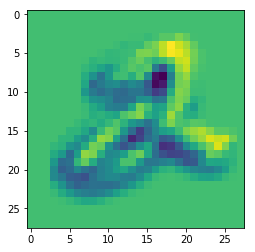


Filtro Corrente: 
 [[[-0.03795305]
  [ 0.09778612]
  [ 0.01830909]
  [ 0.000847  ]
  [-0.14162576]]

 [[ 0.04321053]
  [-0.04512852]
  [ 0.06239902]
  [-0.01697007]
  [ 0.04328181]]

 [[-0.0250071 ]
  [ 0.09271267]
  [ 0.1170887 ]
  [-0.02084814]
  [ 0.00588701]]

 [[-0.0041916 ]
  [ 0.00977197]
  [-0.0299645 ]
  [ 0.01329723]
  [ 0.009244  ]]

 [[ 0.00780303]
  [ 0.06557267]
  [ 0.15287161]
  [ 0.06721067]
  [-0.02914458]]] 


Formato da saída da convolução:  (28, 28)
	Min =  -31.709766210909315 Max =  138.12464395508124


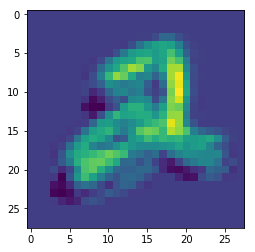


Filtro Corrente: 
 [[[-0.01507921]
  [ 0.03224195]
  [ 0.00499353]
  [ 0.01407748]
  [ 0.01441312]]

 [[ 0.031123  ]
  [-0.00406001]
  [-0.02404983]
  [-0.0297884 ]
  [ 0.11933193]]

 [[-0.04235769]
  [ 0.06723775]
  [-0.04448738]
  [-0.02051823]
  [ 0.0123338 ]]

 [[ 0.0312081 ]
  [ 0.06554841]
  [ 0.01424167]
  [ 0.05432105]
  [-0.06125634]]

 [[ 0.04681156]
  [-0.09117004]
  [ 0.0875832 ]
  [-0.04972485]
  [-0.0121427 ]]] 


Formato da saída da convolução:  (28, 28)
	Min =  -22.066785450039053 Max =  61.17311208010205


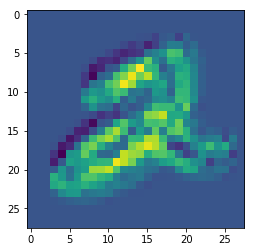


Filtro Corrente: 
 [[[ 0.0185837 ]
  [ 0.01003551]
  [ 0.02027619]
  [ 0.05140811]
  [-0.05687558]]

 [[-0.02569938]
  [-0.09269841]
  [ 0.12917818]
  [-0.07585767]
  [-0.02179364]]

 [[ 0.00795205]
  [-0.00320641]
  [-0.03050498]
  [ 0.0173878 ]
  [ 0.02178798]]

 [[ 0.00254206]
  [ 0.04345281]
  [-0.04670641]
  [-0.028943  ]
  [ 0.0184566 ]]

 [[ 0.02556294]
  [ 0.0089543 ]
  [-0.01880861]
  [ 0.0456327 ]
  [ 0.00209024]]] 


Formato da saída da convolução:  (28, 28)
	Min =  -25.378759708468728 Max =  25.053604367502665


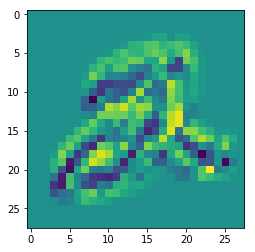


Filtro Corrente: 
 [[[ 0.00840766]
  [ 0.01234684]
  [ 0.03031418]
  [-0.09478368]
  [-0.03448278]]

 [[-0.05101573]
  [ 0.05777664]
  [-0.01321808]
  [ 0.03951155]
  [ 0.03855711]]

 [[-0.01268043]
  [-0.05292285]
  [ 0.01814799]
  [ 0.0784587 ]
  [-0.01860096]]

 [[ 0.00510032]
  [ 0.0517393 ]
  [-0.03215085]
  [ 0.1213756 ]
  [ 0.00824934]]

 [[ 0.03536334]
  [ 0.11604287]
  [-0.01543179]
  [-0.03919486]
  [ 0.0290447 ]]] 


Formato da saída da convolução:  (28, 28)
	Min =  -28.146720154099313 Max =  95.48114069494778


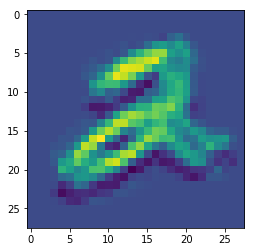


Filtro Corrente: 
 [[[-0.02939608]
  [-0.0683502 ]
  [-0.00877394]
  [ 0.02030031]
  [ 0.05947496]]

 [[-0.02474562]
  [ 0.04785   ]
  [-0.07225576]
  [-0.10707833]
  [ 0.07544126]]

 [[ 0.08681532]
  [ 0.00769962]
  [ 0.01178441]
  [-0.0420258 ]
  [ 0.07971662]]

 [[ 0.02770702]
  [-0.00308899]
  [-0.0112461 ]
  [-0.00012023]
  [ 0.02825588]]

 [[ 0.00689602]
  [ 0.02757926]
  [ 0.03839748]
  [-0.04652501]
  [ 0.05896592]]] 


Formato da saída da convolução:  (28, 28)
	Min =  -56.89040127514719 Max =  72.89525198877968


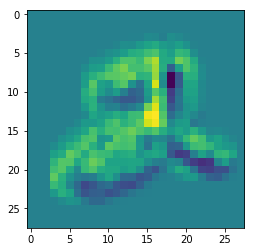


Formato da saída do Subsample:  (14, 14, 6)

Filtro Corrente: 
 [[[ 0.0019976  -0.0039671  -0.00630555  0.01029287 -0.02507179
   -0.01617657]
  [-0.01827914 -0.00470402 -0.01814066 -0.01497632  0.01290308
   -0.00247444]
  [ 0.01188683  0.00544607 -0.02039768  0.01037319  0.00142227
    0.00085518]
  [-0.0043578  -0.01104243  0.01630917  0.00145653  0.00184435
   -0.00049767]
  [ 0.03994693 -0.01808799  0.00672946 -0.03569235 -0.01362478
   -0.01039986]]

 [[ 0.00231945 -0.05676269  0.01593408  0.00976651 -0.01886094
   -0.00652723]
  [ 0.02288492 -0.00915305  0.00783479  0.02558627  0.00366929
    0.00891893]
  [-0.00169265 -0.05477359 -0.01251309  0.00260148 -0.01763392
    0.02774316]
  [-0.00359178 -0.0238571  -0.00236395  0.0389939  -0.0151074
    0.0084085 ]
  [-0.01974132 -0.03380646  0.003222    0.0090076   0.02156741
    0.0415063 ]]

 [[-0.00383331 -0.03342097  0.0387638   0.00047454 -0.03820281
    0.0086092 ]
  [-0.01540302  0.017795   -0.01710489  0.02357538  0.00264897


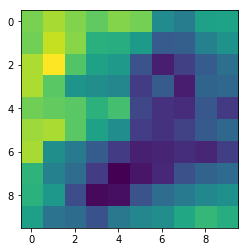


Filtro Corrente: 
 [[[-0.01208626  0.00639272  0.0096168   0.00678974 -0.0468587
   -0.00943066]
  [-0.01806314  0.02028585  0.03362365 -0.01004051 -0.01444
   -0.04830209]
  [ 0.04278704  0.00618448  0.02997261 -0.02821295 -0.00867856
   -0.00324658]
  [-0.03014636 -0.01613935 -0.00619584 -0.03507653 -0.0456177
    0.00502933]
  [ 0.0260694   0.01188785 -0.01195142 -0.02472744  0.00199011
   -0.04730111]]

 [[-0.00909046 -0.0023144  -0.02969324  0.0429723  -0.0327418
   -0.01347597]
  [ 0.00492601  0.00368036 -0.00282214  0.00174335 -0.01656729
    0.02221137]
  [ 0.00318977  0.00682613 -0.00166611 -0.00859934  0.01133881
    0.00355618]
  [-0.02791827 -0.00750226 -0.0005444  -0.01848842 -0.01546574
   -0.00020513]
  [-0.0067967  -0.00173067  0.00758596  0.03224131  0.03725422
   -0.02059792]]

 [[-0.04718437 -0.03264804  0.00345772  0.0095124  -0.00022314
   -0.01030996]
  [-0.00932446 -0.03139153  0.00895148 -0.00920132  0.01073356
   -0.01098467]
  [ 0.02500449 -0.00879563 -0.0080

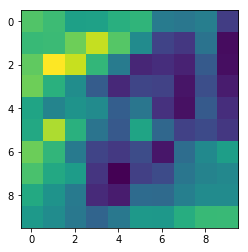


Filtro Corrente: 
 [[[ 0.01049208  0.00259033 -0.02316748 -0.02044893  0.02201905
   -0.03576939]
  [ 0.02933161 -0.04559494 -0.00180332  0.01387986  0.02775267
    0.00273063]
  [-0.02241408 -0.00192629  0.00180345 -0.00495018  0.05069944
    0.01059585]
  [-0.03939682  0.04588584 -0.01248952  0.00356605 -0.00683022
   -0.0034474 ]
  [ 0.00296875 -0.00770352  0.03140434 -0.00744844  0.00491845
   -0.03735283]]

 [[ 0.00257056 -0.00259256 -0.00482495  0.0230194   0.02394989
    0.00584072]
  [-0.00387976  0.01247788  0.02409795 -0.0213554   0.00388023
   -0.03773936]
  [ 0.02620548 -0.00240696 -0.03061855  0.00465732 -0.03951879
   -0.00065521]
  [ 0.00805763 -0.03674344  0.00011084  0.00956     0.018354
   -0.02202311]
  [ 0.01509353 -0.0297346  -0.01187323  0.0114387   0.04670266
   -0.0103829 ]]

 [[-0.00271793  0.00370999 -0.00242707  0.02955741 -0.03654407
   -0.03664032]
  [-0.00741328 -0.00025382 -0.02333952 -0.00910698  0.02630737
   -0.03608284]
  [-0.00513353 -0.01989747 -0.

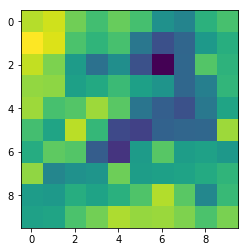


Filtro Corrente: 
 [[[ 1.57556186e-02 -5.40957675e-04 -2.71479939e-02 -1.49256299e-02
   -1.48092175e-02 -4.22391785e-02]
  [-8.34618288e-03 -1.58627491e-03  1.71027976e-02  1.71773193e-03
    4.29455016e-02  1.93196257e-02]
  [-2.46689988e-02  4.25914690e-03 -8.90631189e-03 -9.65428946e-03
    2.17559544e-03 -1.69885556e-02]
  [-5.15616718e-04 -2.98438383e-02 -3.08393259e-02  2.86288602e-02
   -2.31720479e-02  9.34716451e-03]
  [-9.54889412e-03  8.51949994e-03 -1.78126117e-02  4.58109422e-02
   -2.86155920e-03 -1.03556371e-02]]

 [[-3.27591245e-02 -6.05247714e-03  1.26235684e-02  2.17917865e-02
    1.48340939e-02  7.67128064e-03]
  [-2.45772528e-03 -5.20029622e-03  6.68689292e-03 -4.90816785e-04
    2.01881971e-02  1.23180560e-02]
  [ 1.38156781e-02  5.98353777e-03  1.60663700e-02 -4.46402525e-03
    8.47908424e-03 -2.17346929e-02]
  [-2.36553849e-02  1.33511667e-02 -4.57774718e-03  7.41140969e-03
   -4.10913213e-05 -3.29383223e-02]
  [-9.58056627e-04  2.48711220e-02 -1.58163096e-02 

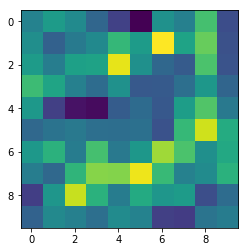


Filtro Corrente: 
 [[[-3.13327731e-02 -9.52267563e-03  3.17581815e-02  8.89421264e-03
    5.03451873e-02  3.77387152e-02]
  [-3.22618283e-03 -7.24540207e-03 -2.94532364e-02 -1.52202972e-02
   -2.88276689e-03 -4.70708250e-03]
  [-2.36446489e-02  7.49961872e-03  1.43011904e-02  2.68507162e-02
   -2.76100422e-02 -4.27148086e-02]
  [ 7.22784950e-04  1.42587388e-02 -1.18560863e-02  8.87464176e-03
   -1.71635072e-03  2.05667557e-02]
  [-2.81170102e-02 -1.38034947e-02  1.02642928e-02 -8.11935662e-05
    2.93272990e-04  4.03316245e-03]]

 [[-1.26588348e-02 -1.70456881e-02  8.19653101e-03 -1.78603113e-02
    2.61593344e-02  3.21689904e-02]
  [-1.12709611e-02 -8.08221258e-03  6.67740386e-03  2.15786315e-02
   -3.94237755e-02 -6.13573023e-03]
  [ 2.62919353e-02 -5.30693510e-04  1.86912851e-02 -2.33612190e-02
    1.51810796e-02 -4.36395807e-02]
  [ 3.76559366e-02 -3.40198801e-03  1.96360040e-02 -2.00053380e-02
   -1.00119631e-02  5.25893018e-03]
  [-2.38321623e-02  1.58428851e-02  1.55982849e-03 

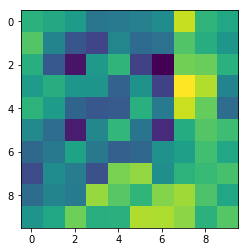


Filtro Corrente: 
 [[[-2.52558620e-02  1.12159623e-03 -3.24755947e-03  2.86325651e-02
    7.06353869e-03  9.22805162e-03]
  [ 3.10881172e-02 -1.73784519e-02 -1.18302570e-02  1.06321029e-02
   -1.08176649e-02  5.15487325e-02]
  [ 3.04062093e-02  8.38872058e-03  1.53754608e-02 -6.01092620e-04
   -4.50034804e-03 -7.62318909e-03]
  [-7.91530861e-03 -1.62180237e-02 -7.11125719e-03  2.80090446e-02
    1.67583714e-02  2.50942251e-02]
  [ 1.86244890e-02  4.25456753e-04  2.91640382e-02  6.95849964e-03
   -6.99729163e-03  1.61861484e-02]]

 [[ 4.30249535e-02  3.33982633e-02  1.32557728e-02 -1.65186206e-02
    2.46418145e-03 -3.73999594e-02]
  [ 7.55086094e-03 -1.43152643e-02 -5.49605351e-02 -1.27341082e-02
    9.14481897e-03  3.77246569e-02]
  [ 1.41981593e-02 -2.58378645e-02 -1.00496871e-02  1.00835016e-02
    2.49633494e-02 -3.41692025e-02]
  [-2.58701605e-02  1.25436352e-02 -3.99888931e-02 -9.86928713e-03
    1.33045681e-02  6.09202221e-03]
  [-5.77184232e-04  2.97378432e-02 -3.95708976e-02 

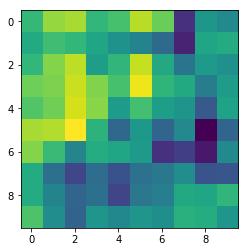


Filtro Corrente: 
 [[[ 0.01650922 -0.02661247  0.00953635 -0.02847209  0.00775339
    0.03634296]
  [ 0.02181229 -0.03726425  0.01263385  0.01487886 -0.02334173
    0.0202404 ]
  [-0.03870101  0.01194882  0.0331315  -0.01555437  0.01572284
   -0.05144981]
  [ 0.02135292  0.00077785 -0.01215065 -0.00719978  0.01002307
   -0.02144   ]
  [-0.00797048 -0.00596168  0.01436633 -0.00051114 -0.00904783
   -0.02094468]]

 [[-0.02087911  0.00059182 -0.01263587 -0.01314438  0.03842819
   -0.02664288]
  [-0.00031011 -0.01346149  0.01654679 -0.0483512   0.0033958
   -0.01388722]
  [-0.01336704 -0.00315556 -0.01014122  0.01952032 -0.0170333
    0.00343359]
  [ 0.0071317   0.0323438   0.01478211 -0.02770344  0.01138732
    0.00756905]
  [ 0.01076429  0.00980531 -0.01542105 -0.02292793  0.00115561
    0.01167096]]

 [[ 0.04670942 -0.02450985  0.03939855  0.00323145  0.00704556
    0.05551269]
  [-0.01252877 -0.00780825 -0.02106338 -0.01814364 -0.01399393
    0.02302203]
  [-0.04085756  0.0270636  -0.

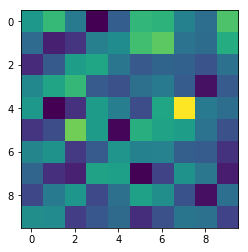


Filtro Corrente: 
 [[[ 0.02251152  0.02057415 -0.04273052 -0.02855325  0.01243277
    0.02093672]
  [ 0.00602995  0.00584811 -0.00528879 -0.02017653 -0.02717785
   -0.02348336]
  [-0.00273442  0.01592061  0.01055776  0.00180825 -0.05069094
    0.01803174]
  [ 0.01842191 -0.01020345  0.00587715 -0.03132032 -0.00506067
    0.01563062]
  [-0.01485801 -0.00829508 -0.0094283  -0.02864175 -0.02845561
    0.0175489 ]]

 [[ 0.00992771 -0.02827979 -0.01607842 -0.00107737 -0.00056713
   -0.00794564]
  [-0.00085857  0.01271705 -0.0100275  -0.03090267 -0.03142562
   -0.04692766]
  [-0.01442398  0.02169848 -0.03470689  0.00372393 -0.00697579
    0.0049415 ]
  [ 0.01224236 -0.00593681 -0.00042091  0.01191306 -0.02914965
    0.03974377]
  [ 0.01664369 -0.01602021  0.01551152  0.00139617 -0.05323738
    0.01061195]]

 [[-0.04194074 -0.00996355 -0.00591479  0.00043704  0.02756606
   -0.03233403]
  [ 0.00850781  0.00191186  0.02729934 -0.00949841 -0.00782943
    0.01130285]
  [ 0.01367038 -0.03458891  

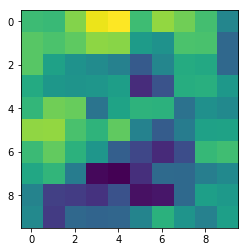


Filtro Corrente: 
 [[[ 1.46938390e-02  3.82897930e-03 -1.76252787e-02 -4.63634894e-03
   -7.81161431e-03 -7.81524693e-03]
  [ 1.90517133e-02  1.16157844e-02 -1.37865812e-02 -1.51759443e-02
    5.25138490e-02  2.26823206e-02]
  [-1.94157604e-02  2.36474713e-02  6.28339762e-03 -4.88774907e-03
   -3.21581738e-02  2.75008911e-02]
  [ 2.67687290e-02  1.20883066e-02  2.74880451e-03  1.52949109e-02
    2.79019890e-02  1.40067156e-02]
  [ 9.49566998e-03 -2.09703628e-02  6.38596063e-03  1.57895328e-02
    2.07938054e-02 -1.67167806e-02]]

 [[-1.99937681e-02  1.48561002e-02  1.05076458e-02 -9.77168628e-03
    2.75059986e-02  3.32008662e-02]
  [-5.07146121e-02 -2.71930531e-02 -2.21511977e-03 -1.91779143e-03
    7.75702217e-04  3.87212880e-02]
  [-2.97634494e-02 -3.10658192e-02  1.31655827e-02 -2.68098913e-03
   -1.92824704e-02  2.52997888e-02]
  [-3.19145794e-03  1.63020587e-02 -9.16655647e-03  2.94397950e-02
    1.54350314e-02  2.36276929e-02]
  [ 2.97588761e-02 -1.51549574e-02 -1.65543617e-02 

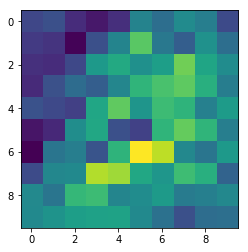


Filtro Corrente: 
 [[[ 0.00660636 -0.02153372 -0.01717778  0.05260338 -0.01010588
    0.00842819]
  [ 0.00629329 -0.0087789  -0.00111889  0.00021303  0.00114579
   -0.00492386]
  [-0.01588567  0.01639025 -0.01640299 -0.00689031  0.02693259
    0.02424453]
  [ 0.02188939  0.00807063 -0.00412993  0.00785168  0.02853978
    0.01625259]
  [-0.00448614  0.00497089  0.0026159  -0.01444721 -0.01590839
    0.00306652]]

 [[ 0.01031154 -0.03133825  0.00562251 -0.00582583  0.01325977
    0.03373417]
  [ 0.00218092  0.02851032 -0.0275558  -0.00747568  0.05558847
   -0.01525751]
  [-0.04743919 -0.0141327   0.00882522  0.02223014 -0.00194318
    0.02516272]
  [-0.00320505 -0.00604817 -0.00888584  0.02204459 -0.02271757
    0.01246556]
  [ 0.00460635 -0.04988592  0.00192569 -0.03778159  0.0052619
    0.01195061]]

 [[ 0.01437143  0.00475794 -0.02138569  0.00905731  0.00759563
   -0.01806479]
  [ 0.00654111 -0.03983006 -0.0141738  -0.0043496  -0.00203833
   -0.0025496 ]
  [-0.05668046  0.01772473  0

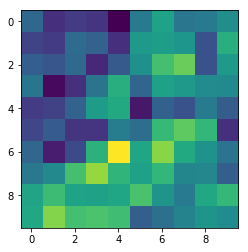


Filtro Corrente: 
 [[[-0.00877406 -0.01546421 -0.01036565  0.02258892  0.01470519
   -0.00270889]
  [ 0.00833947  0.0393502   0.01941983  0.02840478  0.00436349
   -0.01785638]
  [-0.02837516  0.00151109  0.01799537 -0.03915849  0.01008265
   -0.01521487]
  [ 0.01330455 -0.03073853  0.00705768  0.01623544 -0.00042454
    0.00667866]
  [ 0.00311964 -0.01928843  0.00580511  0.00722405 -0.00589528
    0.01924995]]

 [[-0.00051266 -0.0261799  -0.0012842  -0.03833558  0.00622032
    0.03667876]
  [ 0.00967389  0.01583556 -0.02176709  0.03071908  0.01008369
    0.0058013 ]
  [-0.0157811   0.00588469 -0.00011281  0.02613465 -0.00375291
   -0.00154636]
  [ 0.02442512 -0.03291117 -0.0132123  -0.00452638  0.0184162
   -0.02160826]
  [ 0.03072996 -0.05736679  0.01096314  0.02000213 -0.0068573
    0.00932   ]]

 [[-0.01741129  0.01040551  0.00175071  0.02233307  0.02418842
   -0.02855535]
  [ 0.03395316 -0.00285492 -0.00439337  0.02148757  0.01001737
   -0.01036333]
  [ 0.01771964  0.00929807  0.

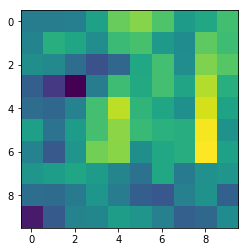


Filtro Corrente: 
 [[[-0.02259066  0.01830697  0.0129663   0.00803    -0.02429903
   -0.03620279]
  [ 0.0094332  -0.03149008 -0.00963619  0.01604205 -0.00248744
   -0.00238553]
  [-0.02348357 -0.01112732 -0.03720247  0.01476162  0.01472749
    0.00048929]
  [ 0.02292204  0.00216343  0.00844748 -0.02402829 -0.01249649
    0.02742755]
  [-0.02197382  0.01819327 -0.03512493 -0.03366504  0.01324596
   -0.00419994]]

 [[ 0.01612185 -0.02169414  0.03266516 -0.01455356 -0.00986138
   -0.01166489]
  [-0.01594456 -0.00623101 -0.01352366  0.00066778 -0.00637538
    0.04890714]
  [-0.01056583  0.00420771  0.02449309 -0.00482997 -0.01138216
   -0.01301456]
  [-0.02260475 -0.00540295  0.01253984 -0.01558585  0.00771469
    0.01407149]
  [-0.00523241  0.01113272 -0.00369778 -0.02936744 -0.01386567
   -0.02565547]]

 [[ 0.01783861  0.01710834 -0.00082097 -0.00015343  0.02817729
   -0.02577673]
  [ 0.02625546 -0.00425537 -0.01231677  0.01418224 -0.0242348
    0.01267553]
  [-0.00418148  0.00390641  0

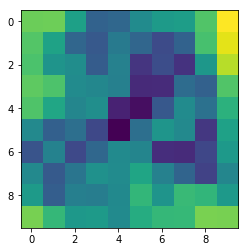


Filtro Corrente: 
 [[[ 3.35483193e-02  1.88377620e-02  8.70612719e-03 -1.80282331e-02
    2.39450654e-02  7.74149370e-03]
  [ 4.02416259e-02  7.79557543e-03  4.92193410e-03 -8.84777831e-03
    3.17393951e-02 -4.32600328e-02]
  [-1.08802102e-02 -4.05066074e-02  7.98165453e-05 -2.16242982e-02
    1.08447889e-02  1.15143337e-02]
  [-1.64279803e-02 -5.03294749e-03 -1.02838881e-02  8.85719325e-03
   -2.70334007e-02  1.85202398e-02]
  [-1.23949032e-02 -1.16248257e-02  1.90591293e-02  3.01037657e-02
   -4.87273493e-02 -1.49861047e-02]]

 [[-6.78616018e-03  1.18648920e-02  2.68747299e-02  1.12040858e-02
    2.85553305e-02 -2.96555276e-02]
  [-4.85364732e-03  2.49171977e-02  1.27159510e-02 -1.40415096e-02
   -1.03206948e-02  1.96264207e-03]
  [ 2.59086171e-02 -2.13399816e-03  1.66526462e-02 -2.18895183e-03
    1.57426446e-02 -2.23173025e-02]
  [-1.41187378e-02 -8.74756667e-03  2.12985681e-02 -1.48133361e-03
    1.32613857e-02  3.01055085e-02]
  [-1.20008383e-02  1.88697257e-02 -4.86786325e-03 

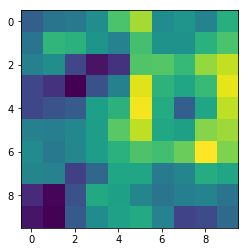


Filtro Corrente: 
 [[[-4.48595398e-02  4.70866742e-04 -2.34071274e-03  1.98189302e-02
   -9.91900191e-03  4.37110822e-02]
  [-2.65895595e-02 -7.65908204e-02  2.70438822e-03  3.78286478e-02
   -4.15316678e-02 -4.90354619e-03]
  [ 5.10516040e-03  1.43713267e-02  1.40864515e-02  3.02446716e-02
    3.30489776e-02  5.59427878e-03]
  [ 2.39138469e-03  1.07074862e-02  2.37345176e-02 -2.82608683e-02
    6.13938689e-03  4.38233983e-02]
  [ 7.22107027e-03  2.05287221e-02 -8.16071826e-03  1.85339754e-04
   -1.12579471e-02  1.92640759e-02]]

 [[-2.29701706e-02  1.13359614e-02  2.35388604e-02  1.33825298e-02
    1.55376026e-02 -8.61783052e-03]
  [ 3.11827493e-02 -1.66747767e-02 -6.78245228e-03  2.28794688e-02
    3.87180030e-03  3.86897084e-02]
  [ 1.77750507e-02  3.91414661e-02 -5.96718509e-03  6.48988402e-03
    6.84908471e-03 -4.46380513e-03]
  [ 2.71859902e-02 -2.19829205e-03 -1.42491170e-02 -2.87786423e-02
    1.60160650e-02  3.95424008e-03]
  [-2.14401954e-02 -2.15063264e-02  2.45887808e-02 

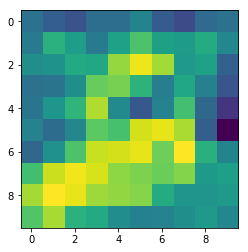


Filtro Corrente: 
 [[[-0.04981252  0.03908674  0.06623783  0.01514665  0.03001689
    0.00715662]
  [ 0.01224369  0.01572966  0.00460166 -0.00073284  0.00581158
   -0.00602463]
  [-0.00545023  0.00699193 -0.01947729  0.03346574  0.01927221
   -0.01862109]
  [ 0.00241153  0.00384999  0.01466296 -0.01804983  0.00515703
   -0.03296113]
  [-0.01873969  0.00677206 -0.00641309  0.01317697 -0.01227834
   -0.01713337]]

 [[ 0.02797827  0.02000466 -0.03594721 -0.00335972  0.01118722
    0.02819199]
  [ 0.01917301  0.01404191 -0.0045703   0.02511864 -0.01852084
   -0.01379503]
  [-0.00454482 -0.02843074  0.01142852 -0.04665983  0.0177538
   -0.00639602]
  [-0.01692407 -0.02296732 -0.02058126 -0.04221783  0.00197418
   -0.01055263]
  [ 0.01352235 -0.00995854  0.02621223 -0.01658574 -0.00168092
   -0.01159602]]

 [[-0.01239764  0.02207062 -0.02177537  0.04187141  0.01062013
    0.02528066]
  [ 0.00188403  0.02606225 -0.02872872  0.00121938 -0.03208315
   -0.05277028]
  [ 0.02440067  0.01768359  0

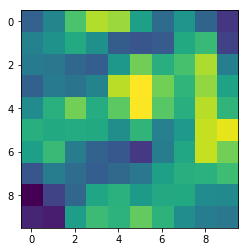


Filtro Corrente: 
 [[[ 2.41881820e-03  9.39241859e-03 -7.62912253e-03 -6.85064831e-03
   -2.19699998e-03  2.88506608e-02]
  [-4.74473494e-02  2.48212259e-02 -2.30533335e-02  2.91905362e-04
    3.82545516e-02  4.45880698e-02]
  [ 1.07994384e-02  1.00115661e-02 -2.96353238e-02 -2.69560002e-04
    1.30653505e-02 -1.72364057e-02]
  [-9.13439718e-03 -2.70235106e-03  2.41140956e-02 -1.34819454e-02
   -1.08057021e-02  2.71275000e-03]
  [-2.64818501e-02 -2.20808306e-02 -4.94469749e-03  1.73722174e-02
   -7.61882896e-03 -3.82517387e-02]]

 [[ 2.11590952e-02 -1.75701613e-02 -1.81053199e-02 -2.92377025e-02
    1.12685488e-02  9.36938411e-03]
  [-1.19943857e-02  2.40769495e-02  6.28672478e-05 -3.30441405e-02
    1.53735156e-03 -1.39562520e-02]
  [ 2.60134011e-02  1.31846732e-02  4.82749433e-02 -2.29079212e-03
   -1.09661737e-02 -3.77516615e-02]
  [-2.98961379e-03 -1.23665718e-03  3.43450529e-02 -3.60637094e-02
   -1.73161656e-02  1.26306065e-02]
  [ 1.72006719e-02  8.64735048e-03 -2.95661869e-02 

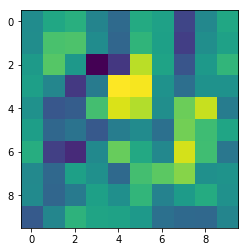


Formato da saída do Subsample:  (5, 5, 16)

Filtro Corrente: 
 [[[-0.02534433 -0.04529685 -0.02646698  0.08227393  0.02390695
    0.02360073 -0.02913198 -0.06179501 -0.02922657  0.0124082
   -0.01827183  0.06767534 -0.06804329 -0.01513537 -0.02772792
    0.01476921]
  [-0.02290738 -0.00100376  0.01872767  0.02741021 -0.01831359
    0.03447617 -0.01081049 -0.00108285  0.00200329 -0.01623021
   -0.02565134 -0.01418973  0.04066233  0.0280768   0.01924654
    0.01720055]
  [ 0.03288888  0.05880613 -0.01870858 -0.02141556  0.01407533
   -0.01011057  0.02678207  0.00735485 -0.04095104 -0.00225235
    0.02551224 -0.02106229 -0.0739      0.02051653  0.03695185
    0.06109159]
  [-0.01825374 -0.00482706  0.03375068 -0.01763644  0.0004554
   -0.01880718  0.05971593  0.01744473  0.06292309  0.08681752
   -0.04192939  0.07646816  0.01325448 -0.03298944  0.02466944
    0.00548134]
  [ 0.00759586 -0.01119181  0.00353501 -0.00321568  0.02452722
   -0.04547182 -0.01356886 -0.00887582 -0.01431559  0.0

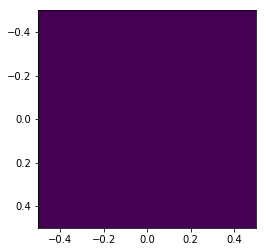


Filtro Corrente: 
 [[[ 1.71791265e-02 -2.58016111e-02 -4.20331434e-02 -4.57591334e-02
    2.42887385e-02  2.37246319e-02 -3.75057915e-02  4.53576338e-02
    2.65927787e-02 -2.80664813e-02 -3.98612860e-02 -9.32027601e-03
   -5.56034388e-03 -6.06538925e-02 -5.38663990e-03 -5.74305438e-02]
  [ 4.93315544e-02  7.03506054e-02  4.03443906e-02  2.98405128e-03
   -1.70127399e-02  3.46744463e-02 -1.10694986e-02 -7.98026686e-04
    3.23887647e-02  2.30870768e-02  1.89331899e-03  6.41353054e-02
   -6.31843388e-03 -7.16067041e-03  2.96919207e-02 -6.27100289e-02]
  [ 1.02695133e-02  6.36658987e-02 -2.42434446e-02 -2.39395593e-03
    2.64315792e-02  5.34585530e-03 -2.96616149e-02  7.85445676e-03
   -2.07880399e-02 -3.78104613e-02 -3.74280175e-02  4.56687621e-02
    6.17912592e-02  6.35422140e-02  9.59490754e-02  7.83723957e-03]
  [-1.53024201e-02  3.55304132e-02 -5.21328823e-02 -2.52251064e-02
    6.69411987e-02 -2.39760259e-02 -4.61964357e-02  3.06547428e-02
   -4.21381634e-02  6.91022926e-02  2.2

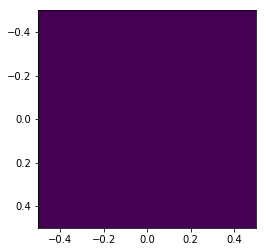


Filtro Corrente: 
 [[[-2.80355523e-02 -1.75974817e-02 -2.58856907e-02  7.03318313e-02
   -2.24447276e-02 -1.14082204e-02  6.09640728e-03  2.65429856e-02
   -5.59034122e-02 -5.41008271e-02 -2.16897411e-02  5.31032149e-02
    6.51014799e-02 -3.01471327e-02 -3.46348232e-02 -3.50670703e-02]
  [-7.56502844e-04 -5.13520401e-02 -6.34412949e-02 -2.11238376e-02
   -2.86909705e-03  6.94935653e-02 -3.90935560e-02  4.74376371e-02
    6.53232062e-03 -5.42616024e-02  5.92830568e-04 -3.19008909e-02
    3.38351508e-02 -5.79654326e-02  3.72951759e-02 -3.75465970e-02]
  [ 1.18159487e-02 -7.78039589e-02  4.97658861e-03  1.23767652e-03
   -4.15171214e-02  1.54489319e-03  1.92744689e-03 -2.03399239e-02
    8.24230473e-03  2.06107496e-02  1.29855022e-02 -2.08303774e-02
   -1.83698397e-02  2.75526451e-02  1.34212429e-02  7.54253827e-03]
  [-2.20983674e-02  9.16834259e-03 -6.69335537e-02 -9.34232779e-03
   -4.19512750e-02 -7.75746277e-03  1.18004662e-02 -1.01583159e-02
    7.76322461e-02 -5.01944002e-02 -2.8

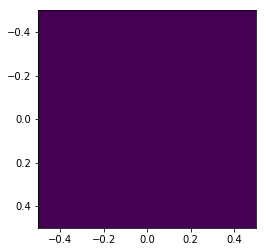


Filtro Corrente: 
 [[[ 9.49768014e-03  2.46991406e-02  3.59317421e-02  1.22327313e-02
   -1.28851880e-02  3.34486317e-02  5.52306221e-02  7.19620982e-02
    4.82583892e-02  3.11578795e-02  1.00008548e-02 -1.35189557e-02
    1.39081853e-03  4.44575836e-02  1.86542034e-02  4.75539210e-02]
  [ 5.87285253e-02  2.33782374e-02 -4.22978072e-03  6.52469651e-02
    6.13363210e-02 -7.03086742e-02 -5.98459737e-02  8.63782907e-03
    5.65653686e-03 -1.41214789e-02  3.50279356e-02  1.90825115e-02
   -1.76780124e-02 -5.26972341e-03 -1.12910799e-02 -7.45335657e-02]
  [-3.84644986e-02  1.71750094e-02 -3.20840687e-02  8.03837905e-03
    2.92468792e-04  5.79412430e-02 -2.83349220e-02 -2.45256610e-02
   -1.33350023e-02 -2.66143895e-02  1.41573026e-02 -1.90070828e-03
   -1.05021521e-03 -2.68441277e-02 -4.94814405e-03 -7.36031766e-02]
  [-1.66577866e-02 -1.62399153e-03  1.32589264e-02  2.42713161e-04
   -1.64571945e-02  3.56795292e-02 -8.66769617e-03  6.68528852e-02
    6.01939579e-02  3.47907209e-02  5.2

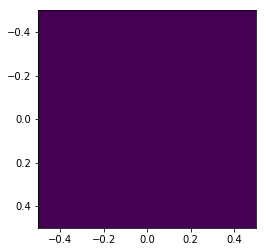


Filtro Corrente: 
 [[[ 0.03287723  0.08522324  0.04541062  0.02147689  0.06009661
   -0.01955818 -0.0192932   0.01202432 -0.04366542 -0.01614956
    0.0258807   0.02388412 -0.010148   -0.00720588  0.00566183
   -0.03738172]
  [ 0.00992551  0.00291858 -0.03407778  0.00321212 -0.09551
   -0.01970928 -0.01778484 -0.00104153 -0.00951545 -0.00560292
   -0.03533491  0.03934738 -0.00881301 -0.08581592 -0.01935455
    0.00380497]
  [ 0.00075793  0.00896986  0.04003287 -0.01505822 -0.02082007
   -0.05789358 -0.09161441  0.00282706 -0.02891841 -0.05683808
    0.0376073  -0.0123374  -0.00294917 -0.00957937  0.02588263
   -0.04441899]
  [-0.03336155  0.07468018 -0.02729793 -0.04235299  0.00317588
    0.00813641  0.00269963  0.02316057  0.00268124  0.03961054
   -0.00703759  0.0301074   0.02410416  0.01261665  0.00089717
    0.01403447]
  [ 0.0419018   0.00192829 -0.01877844  0.03220042  0.0133812
    0.04883364  0.0260172   0.01905132  0.03187935 -0.03466671
    0.02678224  0.01934779 -0.03356747

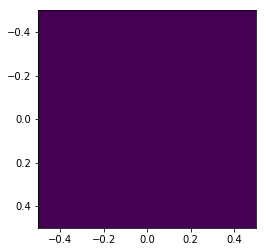


Filtro Corrente: 
 [[[-1.98699269e-03 -1.12384063e-01 -1.05500025e-02 -5.97777827e-03
   -3.61589949e-02  5.69807535e-02 -7.09238073e-02  4.15592886e-02
   -1.86513739e-02  1.51822289e-02 -1.34255085e-02  1.69805137e-02
   -2.50927405e-03 -9.42025275e-03  1.23978239e-04 -1.46075050e-02]
  [ 3.73155923e-02  6.65342000e-02 -2.73410436e-03  5.86387865e-02
   -5.19497476e-02  4.24585125e-02 -2.10426424e-03 -7.29348181e-02
    2.17626101e-03  3.74214848e-02  4.53052972e-02 -2.56160763e-02
   -2.34577570e-02  5.53085876e-02  3.99025847e-02 -6.96688985e-03]
  [-2.24222845e-02 -2.99336829e-02 -5.55145224e-04  1.42237215e-02
   -5.20668439e-02 -1.97316224e-02  5.39579645e-02  1.74077218e-02
   -1.89977429e-02  1.63676160e-02 -2.14243326e-02  5.90066682e-02
    4.55410895e-02 -3.98076795e-02 -1.77209905e-03 -1.85236157e-02]
  [ 2.52034325e-02  8.27560865e-02  4.64957797e-02  5.70966609e-02
   -1.82981007e-02  5.25918470e-02 -7.85751109e-02 -1.44523016e-02
    3.18101932e-02  1.92258402e-02 -4.7

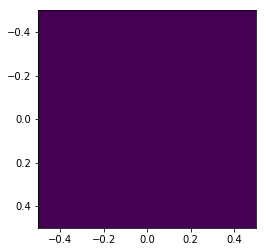


Filtro Corrente: 
 [[[ 0.01222482 -0.04054949  0.01817767  0.00208317  0.05506452
   -0.01528258  0.04464856 -0.06410624  0.03930545  0.00197489
   -0.02940759  0.02473468 -0.00320302 -0.00880563 -0.00773908
   -0.05998912]
  [-0.03409704  0.01361568 -0.02090271 -0.01021582  0.03009707
   -0.04064621 -0.03912856 -0.05870834 -0.0290738  -0.02693996
   -0.03870831 -0.00610692  0.01965708  0.00362444 -0.00802432
    0.02443547]
  [ 0.03900407  0.00770474  0.03794605  0.02539958 -0.00315655
   -0.0454726   0.01846219 -0.02990988  0.01747561 -0.03313085
    0.00893891  0.05532915 -0.02917796  0.02264324  0.08619069
   -0.01246133]
  [ 0.0462797  -0.06382894 -0.03928169 -0.0860462   0.02763864
   -0.00844593  0.04411568 -0.03284681  0.01807395  0.05278582
    0.04030317  0.06785392 -0.06313073 -0.02772972 -0.03371515
   -0.00666621]
  [ 0.03916904  0.01085026 -0.02167929 -0.00226818  0.00125482
   -0.01831293  0.02175474  0.02092064  0.01915377  0.04989374
    0.04723344 -0.0018744  -0.0288

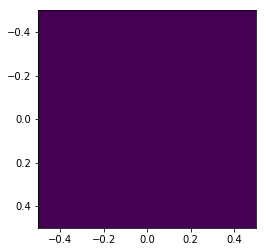


Filtro Corrente: 
 [[[-4.64452345e-03  1.61336199e-02 -1.38028252e-02  5.84320448e-02
   -1.59077336e-02  3.60231192e-02  1.17061110e-03 -3.08159704e-03
    1.41408863e-02  1.25345887e-02  7.89325616e-02  3.39418700e-02
   -1.66134156e-02 -1.45302360e-02  4.86719920e-02 -1.19792989e-01]
  [ 4.36667558e-02  2.64965752e-02  5.95730155e-03 -2.73835660e-02
   -3.15258254e-03  1.38491787e-02  3.97788267e-03 -4.92704927e-02
   -4.99361446e-04 -3.90968572e-02 -5.64148069e-03 -2.04345587e-02
   -1.57586918e-02 -1.87324698e-02 -3.13972244e-02 -3.09246490e-02]
  [-2.73141602e-02  2.93150975e-02 -2.69258494e-02  1.36935742e-02
   -4.47303807e-02  5.69922899e-02  1.27043094e-02  3.54599103e-02
   -3.22358681e-02 -4.37428250e-03  1.58239257e-02  1.63988505e-02
    3.49564845e-02 -2.14310320e-02 -3.53147335e-02  4.14022868e-02]
  [-3.25638022e-02  6.25436958e-02  1.02659135e-02  5.33314584e-02
   -5.78824029e-02  1.97158803e-02  2.92756917e-02  3.50792029e-02
    2.59607952e-02  3.70591778e-02 -8.1

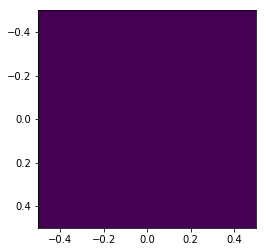


Filtro Corrente: 
 [[[ 0.06542899 -0.00191434  0.0085899  -0.00479014 -0.03148312
    0.00805193 -0.00274246  0.0744093  -0.01897579 -0.04678559
    0.02445657  0.03378645  0.01918245  0.01588541 -0.03677673
   -0.01779085]
  [ 0.00353795  0.00768199  0.03777592  0.02248281  0.02010366
    0.07116994  0.01534416  0.03265663  0.00928928 -0.00482291
   -0.00705226 -0.00339444 -0.03330103  0.06717502 -0.04574095
    0.01625572]
  [-0.03367008 -0.05769565  0.06132119  0.00435672  0.03920033
    0.03814789 -0.02711246 -0.0464358   0.0127868  -0.01600171
   -0.04901608  0.00128313 -0.01108544 -0.05273862 -0.0205855
    0.03594942]
  [-0.00936331 -0.02253613  0.04651293 -0.09769842  0.01121254
    0.0017107   0.05563487  0.057216   -0.03416186  0.02608252
   -0.01495274 -0.01080715 -0.00499219  0.081534   -0.03536157
   -0.06244969]
  [ 0.01147965  0.05578501 -0.04607582 -0.01409883  0.03523185
   -0.00782833 -0.05762245 -0.00161375  0.01036503 -0.0119694
   -0.01671675  0.02068345  0.026911

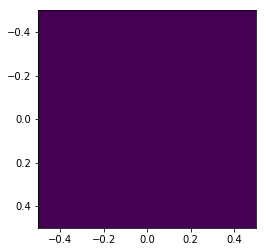


Filtro Corrente: 
 [[[-1.59260329e-02  2.09467122e-02 -4.42694854e-02 -6.01920141e-02
   -1.31280191e-02  2.94658842e-03  1.51059579e-02  3.20517241e-02
   -3.60459364e-02 -3.25180218e-02  1.13106186e-02  2.80088381e-02
   -3.16851373e-02  3.30196772e-02 -5.90900553e-02 -2.67339716e-02]
  [-9.87783457e-04  1.76510819e-02  3.58410125e-02 -3.73770587e-02
   -5.46781067e-02  7.11043112e-02  3.39030422e-03  4.58232132e-02
   -3.71242235e-02  2.39827068e-02 -3.02654118e-02  4.33820299e-02
    1.34370556e-02  4.59202775e-02  4.94126877e-03  1.48672496e-02]
  [ 1.15785294e-02  4.76988692e-02  2.65721860e-02  2.83988153e-02
   -2.70411750e-02  5.48138670e-02 -1.71853860e-02  5.02340741e-02
    1.95624040e-02  1.42583547e-02  2.11622021e-02  3.19356547e-02
    1.89240131e-02  3.52860833e-02 -3.67574195e-02 -1.33887640e-02]
  [ 3.64308716e-02 -4.57815225e-02 -4.46660281e-03 -5.24193385e-02
   -1.80127568e-02 -5.00865381e-02 -8.14487620e-03  4.29217997e-03
    2.61431245e-02 -1.68480278e-02  2.2

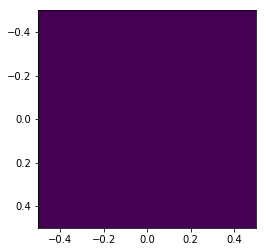


Filtro Corrente: 
 [[[ 2.41862250e-03  2.40037495e-02 -1.46254564e-02 -5.75532249e-03
    5.78812256e-02  2.54492137e-02  3.77757454e-03  6.86671476e-03
    4.87571112e-02  2.54875119e-02 -1.74904439e-02 -1.58951385e-02
    2.65730961e-02  6.23381334e-03 -6.51713510e-03  5.41743920e-02]
  [-3.82453156e-02  4.47644967e-05  4.79930968e-02  3.25430982e-02
   -6.32551157e-03  1.15929249e-02  4.87350280e-02 -4.84163619e-02
    1.11859367e-02 -4.22704368e-02 -8.64229516e-03  6.69497699e-03
   -2.71028995e-03  7.27844028e-03 -2.43336751e-02 -3.76220927e-03]
  [ 3.89338939e-02 -2.20625920e-02  2.13841635e-03 -2.74453325e-02
    4.82690577e-02  2.64327017e-02  3.20424166e-03 -1.15174949e-02
    4.54207815e-02  3.13934735e-02 -3.49218110e-02 -2.65923188e-02
    5.10560665e-03 -2.00459612e-02 -3.18250680e-02 -2.60262522e-02]
  [-6.86119796e-02  8.26752078e-02 -2.69623551e-02 -1.33007952e-02
   -6.63598194e-02 -5.20930800e-02  1.27910698e-02 -1.34992534e-02
   -2.33673546e-04 -3.03128335e-02 -1.6

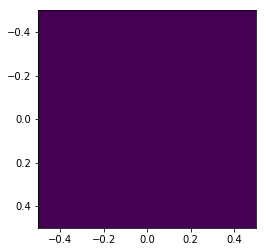


Filtro Corrente: 
 [[[ 0.02646702  0.0053637  -0.00563154 -0.00172025 -0.07824635
   -0.01699928 -0.00783252  0.03368035 -0.04521142 -0.01404396
    0.03885974  0.05261521 -0.05357905 -0.02934962 -0.02534913
   -0.01880556]
  [ 0.01602131  0.00045523  0.00936013 -0.02858284  0.02045404
    0.02835838 -0.02940299 -0.00264821  0.03716989  0.0442464
    0.04484467  0.00748206  0.03145185 -0.02169567 -0.00398427
   -0.02003816]
  [ 0.04960927  0.03407038  0.07169038  0.04967683 -0.03415035
    0.06954309  0.02859434  0.00921405 -0.04160467  0.02170304
   -0.00748174 -0.00626461 -0.026483    0.09166319  0.0080186
   -0.01352503]
  [-0.03579068  0.02414955 -0.04123912  0.10393744 -0.05496504
    0.01289573 -0.00657588  0.03422875  0.02597772  0.02974568
    0.02425888 -0.01331549 -0.02696103 -0.00886    -0.00082347
    0.01937141]
  [-0.02449093 -0.09580149  0.00280579  0.08428232 -0.09853193
   -0.00679294 -0.01605115  0.02623716  0.04067827  0.02039422
    0.01523088  0.01012097 -0.001039

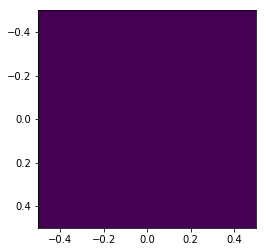


Filtro Corrente: 
 [[[-2.74658627e-02 -1.09874987e-03 -5.90116801e-02 -2.90516417e-02
   -4.92926887e-02  3.67079680e-02  5.46870806e-02  1.65326654e-03
   -3.26603121e-02 -2.69326812e-02 -1.88669818e-02  9.77734720e-02
    1.45737828e-02 -4.58613672e-03 -2.66229126e-04  2.28653798e-02]
  [ 3.31193773e-02  3.41867895e-02 -2.79986612e-03 -3.84169824e-02
    4.43844721e-02  2.50991669e-02  1.98327329e-02  9.39292557e-03
    4.85619987e-02  7.23649114e-03 -4.38399133e-02 -2.33207804e-02
    3.20828072e-02  9.58345319e-03 -6.55893840e-02  1.53573518e-02]
  [-6.78562873e-02  1.25486934e-02 -1.32616997e-04  1.40001635e-03
    3.88766353e-02 -3.03725350e-02 -9.91488190e-03 -4.77331820e-02
   -7.06251293e-03 -3.74967014e-02 -7.49089189e-03  1.66841927e-02
   -3.78977534e-02  3.27114908e-02 -4.24175439e-03 -2.16642158e-02]
  [ 5.34598283e-02 -4.26263233e-02 -4.08096449e-02 -2.86041174e-02
   -4.80353393e-02  6.19908865e-03 -2.49674667e-02 -4.82131588e-02
   -2.39630305e-02  4.19131841e-03 -3.8

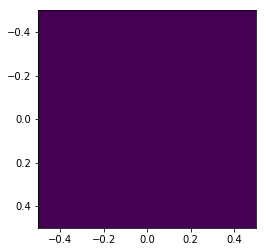


Filtro Corrente: 
 [[[ 0.02696355  0.00945076 -0.01856128 -0.02902107 -0.00525129
    0.00824437  0.03165306  0.02502503 -0.05394634 -0.05441931
    0.0259504   0.02840882  0.02621939 -0.00965078 -0.05045581
    0.03226896]
  [ 0.06574414 -0.03692072  0.02836987  0.01775508  0.01073578
   -0.05602832 -0.01427212 -0.05583019 -0.00613348  0.00463684
    0.01052856 -0.0384358  -0.00023517  0.0145792  -0.00222842
    0.00521311]
  [ 0.04962755  0.05571755  0.03304126  0.02900432 -0.02375664
    0.04995432 -0.01321402 -0.05765441 -0.05085289  0.05308681
   -0.00724276 -0.03850987 -0.03567347  0.00789932 -0.11236205
    0.03143648]
  [ 0.01509267  0.02074033 -0.02269765 -0.04743985  0.01122852
   -0.03508134 -0.01672674 -0.00647099 -0.01016166 -0.05721938
   -0.05925404 -0.02576329  0.02591814 -0.0664345  -0.02674122
   -0.01458548]
  [-0.00690838  0.03160697  0.01048208  0.03404296  0.08067409
   -0.02072501 -0.00847189  0.02639443  0.06766728  0.02010144
    0.04960096  0.05520331  0.0029

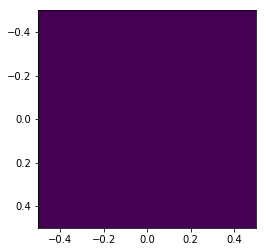


Filtro Corrente: 
 [[[ 0.04498391  0.01844379  0.04126515  0.00744865 -0.03713108
    0.01237313  0.01767599  0.04422641 -0.0095924  -0.0217018
    0.01384959 -0.0278483   0.0190669   0.00346457 -0.03773613
   -0.0272875 ]
  [ 0.02468975  0.00297853  0.00961369 -0.01761537  0.00745061
   -0.02552812 -0.01449975  0.05120951 -0.05381915  0.01313409
    0.0128351   0.03502456  0.01642727 -0.01644785 -0.03246987
   -0.00572858]
  [-0.02192302 -0.05538484  0.02489027 -0.00756352  0.01769774
    0.02996271 -0.00037656 -0.00433821 -0.0487422   0.01141797
    0.01182853  0.01190516 -0.00136826  0.04103141 -0.01455238
    0.04704411]
  [ 0.02609261 -0.03835513 -0.00810469  0.01025616 -0.06460647
   -0.02391916  0.00338038 -0.01566277 -0.04417741 -0.00196612
    0.00886782 -0.02528574 -0.02287772 -0.0054608   0.01898779
    0.00487811]
  [-0.02272731 -0.00281086  0.06002926 -0.07307173  0.02335758
    0.02130588 -0.04206031 -0.01819858 -0.00644605  0.01855797
   -0.02763549  0.02408054 -0.00853

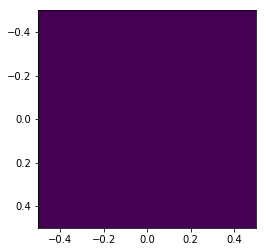


Filtro Corrente: 
 [[[-1.13849506e-02  3.73819771e-02  4.24956987e-02 -1.02063837e-02
   -7.12642964e-03 -4.58288955e-04  2.56162064e-03 -2.38381741e-02
    1.54262771e-02  7.81963561e-02  2.74828786e-02  2.23593213e-02
   -1.35071069e-02 -1.18764134e-02  7.09666999e-03  5.68652874e-02]
  [ 2.46006011e-02 -2.54521559e-02 -1.22967651e-03  2.16621531e-02
   -1.95785336e-02 -2.77413538e-02  7.69070275e-04  2.17238422e-02
   -4.61532958e-03 -2.81985022e-02 -5.73674173e-02  2.67378459e-02
   -4.81249249e-02 -1.65323400e-02 -2.06757819e-02 -6.23814723e-02]
  [ 7.02636301e-03 -2.18014113e-02  5.54021276e-02  6.63673896e-02
   -4.20210844e-02  1.40736797e-02 -3.16120025e-02  2.10444788e-02
   -1.05333801e-02 -1.09974292e-01 -4.91277883e-02 -2.49122267e-02
   -3.75357838e-02 -2.66761599e-02  9.41399340e-02 -2.59151554e-02]
  [ 3.08687749e-03  1.02350182e-02  2.16908360e-02 -1.32972561e-02
   -7.25671247e-02  7.66346661e-02 -1.29951776e-01  1.01950939e-02
    7.72575643e-03  2.76224580e-02  3.5

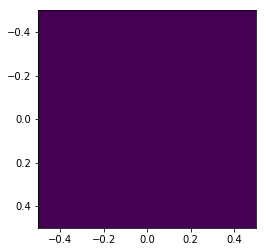


Filtro Corrente: 
 [[[-5.47439855e-02  2.41630418e-02  2.81276496e-03  1.91618445e-02
    5.28469649e-02  4.98148944e-02  2.72997941e-02  1.78111086e-02
   -4.45291496e-02  1.93079805e-03  2.14254442e-02 -2.02826083e-03
   -3.00065535e-02 -5.64729119e-02  5.71127550e-02 -5.32051619e-02]
  [ 1.46122276e-02 -1.28940072e-02 -4.63711128e-02 -2.56847563e-02
   -2.46339133e-03  2.84178947e-02  5.59418250e-02 -1.50126148e-03
    1.94075187e-02 -1.25898859e-02  5.45479940e-02  3.12365641e-02
    5.55804106e-02  3.11129554e-02 -6.31486313e-03  3.89558721e-02]
  [ 2.72849443e-02 -4.23617912e-02  6.96549659e-03 -1.54392288e-02
    3.34921028e-03 -5.23503916e-03  3.86882971e-03  4.47385277e-02
   -7.44704980e-03  2.31351782e-02  4.78349318e-02  5.59846804e-02
    3.86625784e-02 -2.13073142e-02  2.29481250e-02  3.93329281e-02]
  [ 2.13013417e-02 -3.89387252e-02  2.49913460e-02  5.81544193e-02
    5.26061389e-02 -1.54590931e-02 -2.75521016e-02  9.91398419e-03
   -1.54062646e-02  6.12395124e-02 -1.2

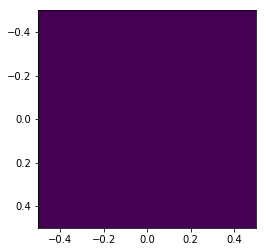


Filtro Corrente: 
 [[[-5.17848428e-03 -2.84584069e-02  3.66726577e-02  5.45054830e-02
    3.40450206e-02 -6.72380966e-02  5.55495955e-02 -8.56726826e-03
    1.83226120e-02  1.73439031e-02 -1.67237629e-02 -1.68144530e-02
    3.89898874e-02 -5.26342782e-03  2.41650462e-02  5.84935850e-02]
  [ 1.34502210e-02  3.48623645e-02 -1.31491332e-02 -1.35647146e-02
   -4.17833286e-02 -2.28210296e-02  2.26180804e-02 -7.35160279e-02
   -9.96444867e-03  1.75618995e-02 -9.84973862e-02  1.59932278e-02
    3.05600374e-03  7.75789075e-03 -3.51776269e-02  2.06813752e-03]
  [-7.29313072e-02 -2.02648530e-02  1.56901103e-02 -5.60457488e-03
   -8.50176692e-02 -2.54946576e-02  3.61649462e-03 -1.77014660e-02
    7.38013709e-03  2.78480989e-02  1.62296644e-02  6.34751153e-02
   -4.91085666e-03  8.34099019e-02 -9.72877359e-02 -2.42641480e-02]
  [ 2.17569075e-02 -7.21224505e-02  5.46948311e-03  4.75832046e-04
    1.37825735e-03 -3.56762036e-02 -2.77453988e-03 -3.99294830e-02
   -4.35606266e-02 -4.85565314e-02  7.5

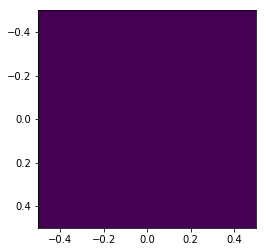


Filtro Corrente: 
 [[[-2.94867196e-02  3.97915816e-02  3.76738991e-04  2.12327716e-02
   -1.68670156e-02  2.03412711e-02 -5.13264187e-02  5.90862499e-02
    5.26478978e-03  7.10746060e-02  3.90163771e-02  2.56248125e-03
   -2.00824995e-02  5.50574746e-02 -7.20368594e-03 -1.48167900e-02]
  [-8.08067769e-03  1.73836880e-02  8.88022362e-03 -3.87420674e-02
    9.29146567e-03  4.31106552e-02 -3.99785510e-03  3.23635461e-02
   -2.30821800e-02 -1.54564085e-02 -1.91210621e-03  1.40460931e-02
    3.78098848e-02 -6.98392198e-03  3.13602117e-02 -1.48991890e-02]
  [ 1.64032036e-02  8.62584875e-03 -3.09152541e-02  2.62607081e-02
   -3.56023852e-02  2.65265910e-02  3.89556498e-02 -5.38780611e-02
   -5.04370197e-02  5.28903511e-02  3.51697604e-02  2.72883695e-03
    3.33083872e-02  3.34515542e-02  4.18514942e-02  3.46720516e-02]
  [ 4.18673918e-03  3.68446252e-02 -1.84915383e-02  5.27591458e-02
    1.69660702e-02 -4.47768854e-02 -1.11970861e-02  4.94320893e-02
   -4.65917441e-02 -1.33776726e-02  1.9

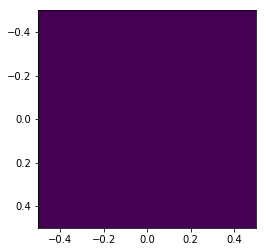


Filtro Corrente: 
 [[[ 0.02084378 -0.03198319 -0.04769304 -0.00462817 -0.02983695
   -0.01446704 -0.02401277 -0.02458407  0.00414231  0.05753999
   -0.01856066 -0.06003153  0.02760327 -0.06351291 -0.01888804
   -0.07957765]
  [-0.06592956  0.00526281 -0.01044955  0.02753786 -0.03197563
   -0.02859931  0.00711915 -0.05442076 -0.05424552 -0.02759336
   -0.00517696 -0.04041525 -0.04544575 -0.06046211 -0.00694918
   -0.0095798 ]
  [ 0.00263168 -0.01153024 -0.00206309  0.00224547  0.00125928
   -0.01433332  0.01874761 -0.00431533  0.01990458  0.02347783
    0.04534519  0.02149433 -0.01653179 -0.03830846  0.00647693
   -0.01234646]
  [-0.03136084  0.03610738 -0.062153   -0.02530163 -0.02123501
    0.09659084  0.03330883 -0.0010931  -0.01538551 -0.06248229
    0.04978912  0.02376254  0.05348544 -0.07255995 -0.00364145
   -0.02343464]
  [-0.02021023  0.00535704  0.00988071 -0.00311922 -0.01407614
   -0.04132088  0.07079465  0.05198845  0.0056672  -0.00433355
    0.03715624  0.04860019 -0.0360

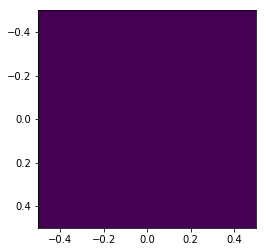


Filtro Corrente: 
 [[[ 0.00205496 -0.01095312  0.0168675  -0.02068101  0.04977818
    0.00426389  0.0117046  -0.01494253 -0.01730725 -0.04346836
    0.04937801  0.00797421 -0.01001022 -0.05954115 -0.03121021
    0.04192841]
  [-0.01526174 -0.07665933 -0.04555518  0.0245481   0.00731132
    0.00956184 -0.0011113   0.03508473 -0.01068107 -0.03722433
    0.01885242  0.05189426  0.0074861   0.1010148   0.03349398
    0.00052   ]
  [ 0.05262647 -0.00887753 -0.02647863  0.02314644  0.05435647
    0.02752351 -0.00475698  0.01627914 -0.02502194 -0.01389184
   -0.01832256  0.07432614 -0.03149974  0.00431898 -0.00295551
   -0.01185928]
  [ 0.05251456  0.0560258  -0.01476867 -0.02408486  0.01991852
   -0.05723405  0.02921836 -0.00633756  0.0196122  -0.0524313
   -0.0187253   0.05831527 -0.03403664  0.00171739  0.04727885
    0.01486727]
  [ 0.05426535  0.02211089 -0.01817227  0.01655073  0.05243003
   -0.02451348  0.00551059  0.00173105  0.03451602  0.02415586
    0.02684416 -0.00643494 -0.00118

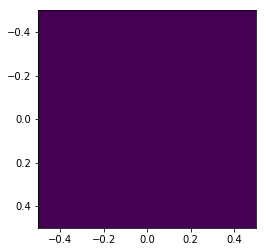


Filtro Corrente: 
 [[[-2.49662317e-02  3.07430232e-02 -4.01466790e-02  1.33980050e-02
   -2.38478035e-02  3.60748250e-02  3.35319719e-02  4.79755232e-04
   -3.21569210e-02  4.27872056e-02 -4.90727975e-04  1.03482989e-02
    3.40396703e-02  5.97471735e-02  4.07195095e-02 -6.95586863e-03]
  [ 3.69793198e-02 -7.33006303e-02 -1.75394310e-03 -9.34986151e-03
   -3.10287519e-03 -3.00858577e-02 -1.72379401e-02  1.96769094e-02
   -2.51615158e-02  3.09888564e-02 -3.21242012e-02 -1.26755142e-02
    7.32116053e-03 -4.25804599e-02  1.14249339e-02  1.20146761e-01]
  [-4.37362286e-02  3.78091766e-02 -7.07505488e-02  2.72814504e-03
   -4.40537563e-02 -3.76778888e-02 -4.65501567e-02  1.80841374e-02
    2.22345385e-02  5.72244971e-02 -2.61689230e-02  1.26959748e-02
   -4.74771510e-02  2.95596093e-02 -2.23072135e-02  2.48754419e-02]
  [-1.96279044e-02  2.79799458e-02 -3.54287574e-02  4.31551396e-02
    2.91801310e-02  1.64965023e-02 -3.12560752e-02  5.79465488e-03
    1.22921712e-02 -5.61961031e-03  2.8

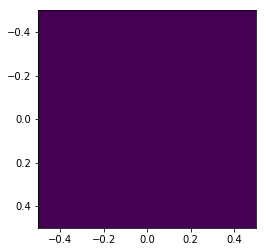


Filtro Corrente: 
 [[[ 0.01068038 -0.02998913  0.01433278 -0.03054264 -0.11659757
    0.00155404  0.01481621  0.05798272  0.02715389 -0.01920576
    0.01699775 -0.01963254  0.00369604 -0.01097861 -0.01009278
   -0.0778838 ]
  [-0.02615683  0.02425433 -0.00550424  0.02746854  0.02099072
    0.02605307  0.01176937 -0.04795398 -0.00763357  0.02469567
    0.01060585 -0.02379964 -0.01585551 -0.06135899 -0.00384223
   -0.0314399 ]
  [-0.01226204 -0.0278849   0.02731066 -0.02126089 -0.01186297
    0.00551834  0.02412254  0.01903773  0.02757809 -0.05220137
    0.0392288   0.01012093  0.02122992 -0.03542731  0.00301779
   -0.06467571]
  [ 0.04135727  0.0145372  -0.01978232 -0.02256701  0.02311096
    0.04610846 -0.02654938 -0.02085035  0.01500332  0.03331796
    0.08001783 -0.00547117 -0.04590939  0.02695382 -0.05265901
    0.01625634]
  [-0.04687155 -0.05070835  0.02267258 -0.0068124  -0.00352727
    0.02219183  0.01769246 -0.0677087   0.02677073  0.01086113
   -0.05070011 -0.0671459   0.0144

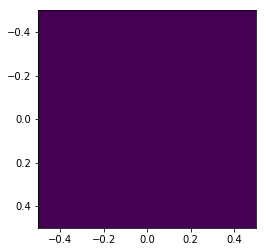


Filtro Corrente: 
 [[[-3.36942039e-02  1.44797343e-02  1.21808947e-03 -2.08965022e-02
   -1.49690001e-02  2.44144604e-02 -1.32228842e-02 -4.28618502e-02
    3.59056464e-02 -8.35974447e-03 -8.51130481e-03  5.48320834e-02
    2.58707160e-02 -4.15307327e-03 -1.24759984e-02 -1.81872028e-03]
  [-4.81689480e-02 -3.69281212e-02 -2.84360003e-02 -1.37819755e-02
   -2.09690545e-02  3.86510335e-02  1.23958767e-02  2.66980175e-02
   -3.01111249e-04 -4.42646191e-02 -1.98530024e-02 -2.65124623e-02
   -6.54183418e-02  9.54631644e-03 -9.08956114e-03  4.66382415e-02]
  [-3.11822872e-02  6.91961073e-02 -8.66526450e-03 -5.01850303e-02
   -4.05975496e-02  3.57664894e-02  4.33521279e-03  5.68752086e-03
    1.66899940e-02 -5.41720620e-02 -5.52726074e-02  7.51213493e-02
    4.16637671e-03  7.73062743e-02  7.70883503e-02  2.49675402e-02]
  [ 6.96371476e-04  6.22360042e-02 -5.63011707e-02  5.10371721e-02
   -1.23248426e-02 -3.35328568e-02  4.20112114e-02  5.28662065e-02
   -2.52624554e-02  2.38896017e-02  1.6

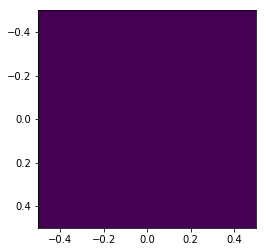


Filtro Corrente: 
 [[[-2.96400615e-02 -1.74008695e-02 -2.30903548e-02 -3.61965485e-02
   -2.53504854e-02  2.05853988e-02 -1.39415769e-02 -3.31837879e-02
   -8.79968503e-03  1.51068544e-02 -3.96892680e-02 -7.67126194e-03
   -6.06420457e-02  5.24515161e-03  1.72506410e-02  1.84890792e-02]
  [-3.00845753e-02 -3.67128122e-02  1.56502740e-02  2.86569088e-02
    1.62354236e-02  4.49873590e-02  3.76106805e-02  2.41746106e-02
   -5.15041300e-02  3.87882297e-02  1.59621978e-02 -2.80787035e-02
    3.82632891e-02  5.89983933e-03  5.07475161e-02  5.30356494e-03]
  [ 1.42085540e-02  2.60030452e-02  1.10911553e-02 -5.07751598e-02
    8.10799288e-02  1.12632371e-02  2.05001951e-02 -2.11459715e-02
   -2.53367454e-02 -1.61233294e-02 -1.75539130e-02 -2.36037146e-02
   -5.71486229e-02 -5.85365098e-02 -2.59064280e-02  1.33657987e-02]
  [-2.62288467e-03 -1.41152069e-02  1.13821478e-02 -3.65079382e-02
    7.30779898e-02  7.60847674e-02 -8.34159989e-03  3.34560921e-02
   -1.41435800e-01 -2.46207763e-02  1.5

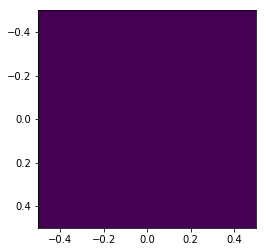


Filtro Corrente: 
 [[[ 1.50359181e-02 -2.85592739e-02 -5.53182734e-02  1.52872482e-02
    8.61714144e-03  3.91534382e-02 -4.11172831e-02 -2.00408885e-02
    2.05248739e-02  2.99868509e-02  1.83593402e-03 -3.14677179e-03
    3.66236269e-02 -1.79789664e-02 -4.96745206e-02 -3.09067325e-02]
  [-1.89950099e-03 -1.59830296e-02 -1.17669573e-01  3.51384353e-02
   -3.37309054e-02 -4.96974482e-02 -4.29642510e-02  7.35690523e-03
    4.05668487e-02  4.15283305e-02 -2.17644732e-02 -1.46531941e-02
   -3.49261109e-03  3.98304515e-02 -3.59027450e-02  1.69584061e-02]
  [-2.28132140e-02  6.87103044e-02  8.23011605e-02  2.33909648e-02
   -4.20922599e-02  1.92264277e-02 -2.98646010e-02  2.46307052e-02
    4.93040286e-02  2.69450153e-02  2.88680838e-02  4.80033654e-03
   -2.40688345e-02  5.10792732e-02  3.53640572e-02  2.09171989e-02]
  [ 4.87440308e-02  4.00133670e-02 -3.94409187e-02 -1.62674270e-02
    2.55746583e-02  2.07594802e-02 -6.79418386e-02  3.26678732e-02
    4.01277501e-02  1.08654857e-02  3.0

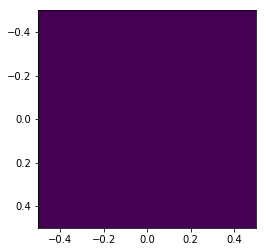


Filtro Corrente: 
 [[[ 0.00029444  0.01139066  0.0110708   0.03247288 -0.00318071
    0.04255859 -0.07056078  0.05135061  0.01894757 -0.03338613
   -0.00923804  0.01496373 -0.03466031  0.0450169   0.02141134
    0.00772024]
  [-0.00104365 -0.01762221  0.00419971 -0.02305921  0.01855589
   -0.02873053 -0.03217484 -0.04241812  0.07219103 -0.00041182
   -0.01784703 -0.04586052 -0.00413564  0.02216238  0.02285199
   -0.00321044]
  [ 0.05440757  0.01654072 -0.02802104 -0.0235104   0.04092457
    0.03807449  0.06684642 -0.09997271  0.00911558  0.03170269
    0.03136379  0.03216234 -0.01468582 -0.08692527 -0.02674275
   -0.04739808]
  [ 0.01670928  0.00899892 -0.03316738  0.02535418 -0.01132136
    0.03449116 -0.0234431   0.00454953  0.00765722 -0.02731571
   -0.00197133  0.03301968  0.01105176 -0.04434774 -0.03746817
   -0.04920391]
  [-0.05545519 -0.02857338  0.02408998  0.09002468 -0.01279234
    0.01198704  0.01242057  0.00025584 -0.02668043 -0.00742038
   -0.00200833  0.06471714  0.0926

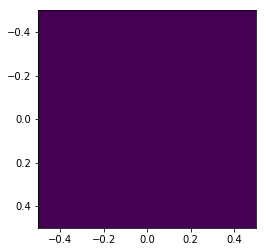


Filtro Corrente: 
 [[[-0.01140585 -0.05595305  0.02935627 -0.02067916 -0.02841259
    0.03123526  0.03886801 -0.08151497  0.01741271  0.03181917
   -0.0021138   0.01314911 -0.0177066  -0.00834325  0.02479115
    0.02336362]
  [-0.01953714  0.04088276  0.04314475 -0.03725538  0.00485777
    0.01288314 -0.01907824  0.0119896   0.02552927 -0.03173239
    0.0454597  -0.07483806  0.04857487  0.00357431  0.01308418
   -0.06652637]
  [-0.05074932 -0.02346321 -0.04511551  0.01167408  0.02002006
    0.03989836 -0.00760711  0.01685025 -0.02481893 -0.00314972
    0.02009219 -0.06287654  0.02887788 -0.00971004 -0.00376893
   -0.06537092]
  [ 0.03464415 -0.03330306  0.00382229  0.02314329  0.04545988
   -0.06853961 -0.00315149 -0.02012812 -0.01329717  0.01198189
   -0.02148021  0.00282692  0.03454746  0.0345326   0.05162134
   -0.00801894]
  [-0.00311626 -0.04292617  0.01364448 -0.04179284  0.02162399
    0.01308758  0.02526753 -0.01016953  0.00185494  0.01473955
   -0.01868762 -0.00140195 -0.0492

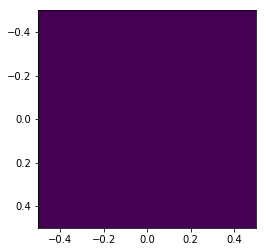


Filtro Corrente: 
 [[[ 0.01125123 -0.03328184  0.00120289 -0.00846482 -0.03449928
    0.00682893  0.08733583  0.03409249 -0.00688842  0.00029853
    0.03258373  0.03395135 -0.02584996 -0.06195836 -0.01701941
    0.03914459]
  [ 0.0047409  -0.04129756 -0.02297807  0.04282147 -0.03046761
   -0.01271645 -0.01087082  0.00818135  0.0876011  -0.0323156
    0.08093793 -0.0525673  -0.05164621  0.01262914 -0.073463
    0.02468975]
  [ 0.01417345  0.01958326  0.05792102  0.06317725  0.009457
    0.00485815 -0.02960948 -0.03588928 -0.0317504  -0.03218047
    0.02183102  0.01684512  0.03568938 -0.01714921  0.01957155
    0.09145412]
  [ 0.01788646 -0.01747475 -0.04513453 -0.01041198  0.02630201
    0.0097745  -0.03893572 -0.02853415  0.00827065  0.07672405
    0.03062969  0.01686247 -0.01558635  0.01544264 -0.05229328
   -0.04242991]
  [ 0.00089396 -0.06776176  0.03452484 -0.03677884 -0.03180935
   -0.07251905 -0.08315567 -0.00920108  0.0532091   0.01546587
   -0.02362757  0.0857361   0.03935093 

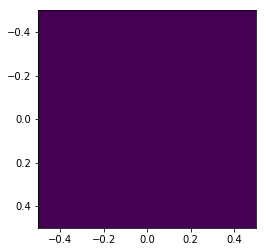


Filtro Corrente: 
 [[[-0.0077351  -0.00224452 -0.04694177  0.08145261 -0.01882523
   -0.01037345  0.01280375  0.02732762 -0.06867857  0.03073071
   -0.03229503 -0.01379414 -0.00698143  0.011956    0.01130968
    0.080543  ]
  [ 0.05627042 -0.06618307  0.0004696  -0.00722756 -0.00366557
   -0.00084716  0.03469314 -0.01645988 -0.04390696 -0.02953895
    0.0218235   0.03051313 -0.00378204  0.04471112 -0.01269147
   -0.07336876]
  [ 0.04746287 -0.07978524  0.00778397  0.03166423  0.00712907
    0.04479631  0.03800149  0.04107013  0.02485068 -0.0111877
   -0.02999278 -0.04458611 -0.00200378  0.01910098  0.03591874
    0.0142393 ]
  [ 0.01351625  0.00918316 -0.0011485   0.01522827  0.07096261
    0.00446056  0.0030308  -0.00641337 -0.04552748  0.02791093
   -0.00808045  0.03482676  0.0790741  -0.02392144 -0.00639319
   -0.04874014]
  [ 0.01557305  0.03061076 -0.04893531  0.00019643  0.07985405
    0.03325872  0.02981014  0.04327645 -0.00810298  0.09870623
    0.01743339 -0.00276155  0.00619

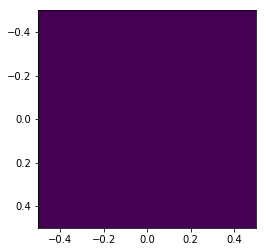


Filtro Corrente: 
 [[[ 0.06807471  0.02372342  0.01679502 -0.02186717  0.00676159
   -0.0449416  -0.03127989 -0.00356811  0.03104342 -0.0188255
    0.00434437 -0.02579262 -0.01644998  0.03755324 -0.0254112
    0.0450154 ]
  [ 0.0360796  -0.03629422 -0.0243103   0.03701899 -0.04548507
    0.00074695 -0.03902906 -0.03151374 -0.05642373 -0.03951638
   -0.02923268  0.03109503  0.04084848  0.0210494   0.09119117
    0.0364254 ]
  [-0.03361427  0.01658195 -0.04111344  0.00186401 -0.0324471
   -0.00434371  0.00719418 -0.05863597  0.01570072 -0.00793714
   -0.01281268  0.01155711 -0.01990373 -0.03607101 -0.02120991
    0.02045604]
  [ 0.09478417 -0.00540826  0.04620185 -0.03537659  0.00499665
    0.0031086  -0.01174825  0.01424036  0.00781898 -0.01870904
    0.02645223 -0.06503364 -0.03764718 -0.00867638  0.01996788
   -0.00131423]
  [ 0.02587037 -0.00037123 -0.00629744  0.01781997  0.01244901
   -0.03167687  0.02161869 -0.02441255 -0.03363909  0.04232818
    0.02242219 -0.04864132 -0.0297490

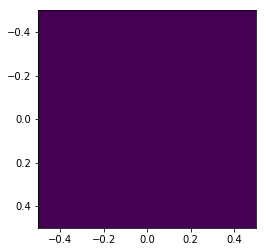


Filtro Corrente: 
 [[[-3.32322126e-02  4.92742038e-02 -1.69763297e-02  2.98917120e-03
    2.68109751e-02 -4.07856114e-03 -1.22810770e-02 -8.79901452e-03
    2.45868356e-02 -5.93762707e-03 -3.84666019e-02 -2.29920913e-02
    6.49802970e-02 -5.63347565e-02  8.86193562e-03  1.43853390e-02]
  [ 5.97415149e-02  1.30868066e-02  3.30362669e-02 -1.62312106e-02
    2.20762045e-02  4.56351790e-02 -3.95510291e-02  1.10831829e-03
   -5.31664421e-02  2.56221853e-02 -5.85500116e-03  4.40988447e-02
   -7.30242588e-03  4.10414039e-03 -2.92571314e-02 -1.28233876e-03]
  [-3.15180690e-03 -3.58057766e-02 -4.76453557e-02 -6.30646739e-02
   -4.70500520e-03  1.63264304e-02 -4.49510833e-02  3.64135405e-02
   -2.55818494e-02  3.56904252e-02 -5.48886917e-03  4.73948202e-03
    7.49090577e-03  1.03759378e-02 -7.62574228e-02 -5.27191927e-04]
  [ 1.01897281e-02  5.32224325e-02 -2.56109857e-02 -5.21555691e-03
    2.78606009e-02 -2.42220999e-02  5.80565927e-03  1.04610745e-02
   -2.09283533e-02 -1.32951059e-03  4.4

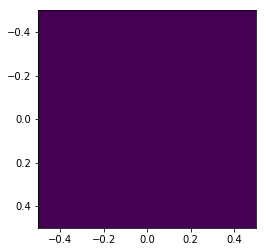


Filtro Corrente: 
 [[[ 0.01811888  0.04058684 -0.00199007 -0.0606682   0.07468541
   -0.05239424 -0.03264961  0.02560425  0.02590382 -0.01446443
    0.0395566   0.03313633  0.00462996 -0.02628632  0.04831427
    0.03630139]
  [-0.0534327   0.04115238  0.005501   -0.02111552 -0.00543718
   -0.03249283  0.00039739  0.01099222 -0.04768669 -0.05787732
    0.02476749  0.02887452 -0.03471019  0.04205059 -0.00944511
   -0.07589581]
  [ 0.06051987  0.00132715 -0.0464799   0.04323719  0.01348175
   -0.02905663  0.00202608 -0.0335209  -0.08555382  0.01860842
    0.00512418  0.03771744 -0.06370537  0.03767114 -0.00242306
    0.02026813]
  [ 0.01266548  0.00245919 -0.06552072  0.02162613 -0.00964347
   -0.00711427  0.05660918  0.02411307 -0.01588725 -0.03807553
    0.03102027  0.00552714 -0.02431954  0.00206562  0.01516804
    0.01550243]
  [ 0.03326813 -0.02472297 -0.04334556  0.02761934 -0.01796716
    0.0712102   0.01543986 -0.01375932 -0.02868723 -0.02644085
    0.02113723  0.00421638 -0.0214

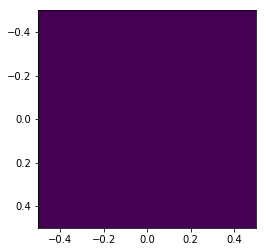


Filtro Corrente: 
 [[[-1.18099000e-02  9.69273166e-03 -6.12821018e-03 -1.81119393e-02
    1.42374745e-02  1.73540568e-02 -2.27728144e-02 -2.25067759e-02
    2.85738271e-02 -1.28526752e-02 -1.05557813e-02  2.13379869e-02
   -4.01832813e-02  2.61478583e-02 -2.76207014e-02 -3.45241483e-03]
  [-2.13173755e-02 -2.17822917e-02 -7.09882821e-02  1.49071900e-02
   -1.77023881e-02 -5.59365637e-02 -3.12290093e-02 -6.04876982e-03
    2.22806343e-02 -2.08914010e-03  3.90141845e-02  2.60968556e-02
   -2.96898419e-02 -6.08852714e-03  8.26901191e-02  1.00442454e-02]
  [ 1.05834772e-02 -8.36009863e-03  4.78821332e-02  2.40841310e-02
   -4.63409640e-02 -3.66380475e-02  4.58232064e-02  5.13048779e-02
   -3.02183085e-02  2.62252855e-02  5.80189525e-02 -8.91439197e-02
    6.60196129e-02  1.07271502e-01  5.42141119e-02 -3.44923099e-04]
  [-9.51083754e-04  5.40528594e-02 -6.13506134e-04 -7.69824411e-02
    2.55814941e-02 -1.74926744e-02 -3.32137575e-02  7.34841821e-02
    3.45046971e-02  1.55504945e-03 -1.0

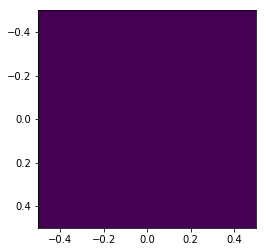


Filtro Corrente: 
 [[[-5.76676467e-02  3.93537816e-02 -1.93594312e-02 -2.18065943e-02
   -4.95662260e-02  4.12335578e-02  4.94872385e-02 -5.04065753e-02
    7.24121481e-03  2.24272363e-02 -7.85418759e-02 -3.41928677e-02
    2.80680482e-02  1.75325718e-02 -5.62626036e-02 -6.73185626e-03]
  [ 4.48892914e-02 -8.42181609e-02  8.40723063e-02  7.51303073e-03
   -7.58900414e-02  3.10352374e-02  1.18908460e-02  4.33235403e-02
   -4.42109199e-02 -2.51144666e-03  2.29300914e-03 -2.01838116e-02
    1.35751620e-02 -8.23235087e-03 -8.15769587e-04 -5.33875189e-02]
  [-3.09610532e-02  2.58094038e-02 -3.64600613e-02 -7.11387140e-03
   -3.85569559e-02  2.84920604e-02  2.59724628e-02  1.33885401e-03
    9.25773339e-03 -3.94005150e-02 -7.17246863e-03 -2.11734374e-02
   -3.54470507e-02  5.71361905e-03 -1.50657930e-03  9.95553244e-03]
  [ 1.17243091e-03  1.35336459e-02 -4.05526497e-02  2.41418170e-02
    5.67973645e-02 -1.12712050e-02  4.58576832e-02  7.41008618e-02
    2.26583656e-02  2.71924323e-02 -1.8

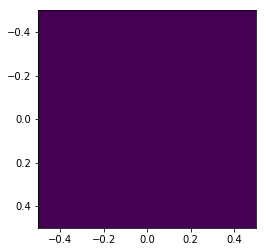


Filtro Corrente: 
 [[[ 0.02387755  0.04612035 -0.01616228 -0.08906092  0.0290636
    0.05013198 -0.0076018  -0.00768084  0.03261326 -0.00783992
   -0.05569138  0.00763369 -0.02490011  0.05247662 -0.05469307
    0.01008051]
  [ 0.07468805 -0.01512811 -0.02564027  0.0169215   0.02673396
    0.01483461 -0.00075294  0.02443532  0.03103142  0.0318108
   -0.02689737  0.03253304 -0.02212478  0.0062194   0.05425895
    0.02108396]
  [-0.02149464  0.01265862 -0.01263768  0.04502165  0.05995032
    0.02651648 -0.03811042 -0.00792795 -0.00309031 -0.0039928
   -0.02451841 -0.00620088  0.00472175 -0.07419975  0.02011136
   -0.01259848]
  [-0.01574711  0.03124887  0.00647501  0.02903363 -0.05584079
    0.01641509  0.01967423 -0.0133953   0.00730773  0.01966624
   -0.03801535 -0.02584757 -0.01726316  0.01113677  0.01165528
   -0.03678308]
  [ 0.00818581 -0.02384902  0.06198414  0.06389138 -0.07660574
   -0.01423873 -0.02207947  0.0374419  -0.00186644  0.02841917
   -0.00650733  0.03055122  0.0287847

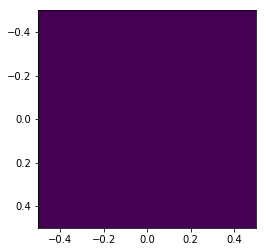


Filtro Corrente: 
 [[[-0.00789487 -0.02570428  0.00453398  0.04932488 -0.02304701
    0.02103389 -0.03583985  0.01096585 -0.00189365  0.05632992
    0.04929178  0.02483263 -0.05303431 -0.03301341 -0.00418977
   -0.02407628]
  [-0.00966578 -0.00087376  0.0096813  -0.05918207  0.01370387
   -0.02084926 -0.08240689 -0.00683891 -0.04033789 -0.04568688
    0.03553574 -0.01347878 -0.03212549 -0.01848473  0.03382133
   -0.03013868]
  [-0.04170103  0.02312892  0.04585481  0.02727555 -0.00403269
    0.01994132  0.05363548 -0.01389591 -0.03033144  0.01301872
    0.00512901  0.04030371  0.03101351 -0.02685178  0.07030422
   -0.00019705]
  [-0.01322598 -0.07522341 -0.01665447  0.00124427 -0.02048758
    0.02050963 -0.02274444  0.04081304 -0.03086384 -0.01971502
   -0.08155397 -0.06185628  0.0429603   0.00830443  0.00442858
   -0.01211633]
  [-0.01033411 -0.05128577  0.0800296  -0.01105298 -0.00311684
    0.03641982 -0.02173986 -0.02860879  0.07843844  0.01683812
    0.01363248 -0.01303023  0.0513

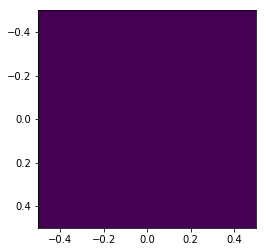


Filtro Corrente: 
 [[[-6.26424477e-02  3.21852589e-03 -3.70055894e-02  2.31359651e-02
    4.75594269e-02 -3.73722502e-04  6.26498890e-02  8.24992961e-02
    7.81214579e-03 -1.02703968e-02 -7.71145735e-03  3.77291380e-02
   -6.00094053e-02 -5.36039584e-04 -3.41875268e-02  3.94604952e-02]
  [-8.91055596e-02 -4.26911744e-02 -5.91788278e-04 -8.54031396e-02
    1.58782598e-02 -3.63703293e-02 -2.34223212e-03 -1.64082532e-03
   -6.38321694e-03 -2.87929992e-02  4.91978256e-03  4.27493666e-02
    8.05633825e-03 -1.79119332e-02 -1.34914871e-02  3.41217209e-02]
  [-1.68853926e-03  8.67451987e-02 -3.68350584e-03 -4.66597499e-03
    2.22919120e-02 -7.68786253e-02  9.13977142e-02 -2.05293735e-02
   -3.91105661e-02  3.18136732e-02 -8.66726825e-03  1.36961068e-02
   -2.31635355e-02  5.91337492e-02  3.59770845e-02  2.58379248e-02]
  [ 1.53220334e-02  9.07451828e-04  4.95231709e-02 -4.27956661e-02
   -6.98960946e-02 -2.57181392e-02  7.54718428e-02 -5.01458153e-06
    3.18462202e-02 -6.42494297e-02 -8.1

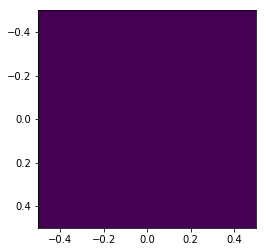


Filtro Corrente: 
 [[[ 3.77717214e-02 -2.19626750e-02 -3.30890959e-02  1.85209337e-02
   -1.89572294e-02 -3.94281336e-02  1.25449026e-02 -1.87442325e-02
    2.40070644e-02  6.97978949e-03 -1.02926628e-02 -4.57525886e-03
   -6.02540870e-02  4.21528345e-02 -5.11018295e-02  3.04874589e-02]
  [-1.37967882e-02 -6.09962708e-02 -2.32846786e-02  2.92350966e-02
    1.41138077e-02  4.40354177e-02 -1.02213475e-02 -1.01457001e-02
   -2.48394559e-02 -2.38684687e-02  5.03630006e-02  5.91326026e-02
    9.89139383e-03 -9.90380094e-03  3.57884031e-02 -2.57427018e-03]
  [-2.18720273e-02  2.15345688e-02  3.12554578e-02 -2.20960177e-02
    6.28505856e-02  1.89809829e-02  3.08653807e-02 -2.87985380e-02
    3.75032875e-02  9.34715689e-03 -2.62344068e-02 -1.22305906e-02
    4.61528723e-03  4.06695701e-03  2.67693049e-02  4.84159407e-02]
  [-3.43057739e-02 -3.66653086e-02  1.27353617e-02  3.10320049e-02
    3.56859141e-02 -1.48583189e-02  1.77550898e-02  2.23126682e-02
   -4.16299102e-02  1.98451946e-02 -3.8

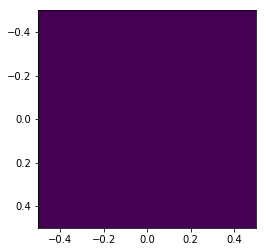


Filtro Corrente: 
 [[[-0.00231263 -0.00997773 -0.03397131  0.01177143 -0.01992867
   -0.04954032  0.00398603  0.01906572 -0.01998118 -0.0048209
   -0.04339579 -0.000601   -0.05230462  0.02486843 -0.00950043
   -0.04245702]
  [ 0.00745214  0.01596804  0.00184025  0.01373979 -0.01074826
   -0.06019369  0.00965417 -0.04546301  0.05987195  0.04579068
    0.03208843 -0.04206883  0.00434082  0.04559424 -0.03307498
    0.01384428]
  [-0.02456266 -0.03332736 -0.07739606  0.04356363 -0.06574682
   -0.05529815  0.01165116  0.00297385 -0.00014839  0.07046062
    0.01530568  0.00338856 -0.03021627  0.02045763 -0.00544452
   -0.06911389]
  [-0.02527463  0.03400551 -0.00886763 -0.01362435  0.02043993
    0.02831918 -0.05745771 -0.02800638  0.05183839 -0.04743588
    0.00346356  0.04504219 -0.00786415  0.00540426 -0.05609163
   -0.03534749]
  [ 0.0080338  -0.02467539 -0.0230242   0.00337168 -0.03002047
   -0.00548054  0.02712481 -0.00573127 -0.00116611  0.07457846
    0.03824725 -0.01033158 -0.00843

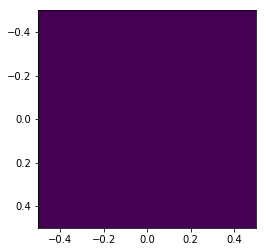


Filtro Corrente: 
 [[[-7.23595387e-02 -2.26797261e-02 -2.05158925e-02  3.72472435e-02
   -2.49436925e-02  3.63309219e-02 -6.80958875e-02 -1.82472704e-02
   -3.88876848e-02  1.17404573e-02 -1.98189834e-02 -2.36041955e-02
   -1.54258009e-02  1.15485974e-02 -5.06508683e-02  4.05293327e-03]
  [ 2.71949917e-02  1.47901796e-03 -2.41379189e-02 -5.38823423e-02
    6.32699569e-03  2.91556693e-02  1.93469235e-02  2.27898979e-03
   -5.32891162e-03 -6.71978796e-03 -3.17599820e-02 -3.02917091e-03
   -2.33433381e-02 -4.84299755e-02  1.67925951e-02  2.19821267e-02]
  [-6.93310119e-03  1.22806782e-03 -3.43805497e-02  3.40045165e-05
    3.74526076e-02  2.23952025e-02  5.81210730e-03  3.11271154e-03
    2.29262139e-02 -3.56941376e-02  9.75960433e-03  2.12092549e-02
   -2.30230923e-02  3.77834491e-02  6.08069756e-03 -4.69003386e-03]
  [-2.09094439e-02 -1.57763515e-03  2.95404556e-02  3.63421063e-02
   -4.83869779e-02  2.64310013e-02  5.22327610e-03 -4.20679711e-03
   -1.13153117e-02 -1.56297714e-02 -1.5

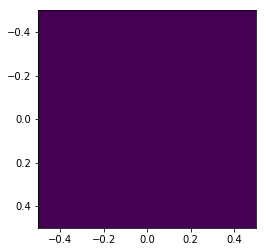


Filtro Corrente: 
 [[[-0.01065864 -0.03191677 -0.01539615  0.04298225 -0.01561542
    0.04686597  0.02223166  0.01329455 -0.06670834 -0.02720596
    0.05148745  0.06563636 -0.05183682 -0.05443799 -0.01229788
    0.02466185]
  [-0.0157585  -0.01113072  0.01818239 -0.02956045  0.01966314
    0.03360111  0.0545165  -0.02899169  0.08211873 -0.05368306
    0.04506601  0.0443405  -0.02156432 -0.04927628  0.00143693
    0.01667831]
  [ 0.04000568 -0.0038102  -0.01466956 -0.01708144  0.00310586
   -0.04241981  0.04208082  0.02408288 -0.0223818  -0.02975921
   -0.0250302  -0.01104099 -0.00516762  0.00788611  0.01116975
   -0.00778225]
  [ 0.00527836 -0.00214502  0.02660675 -0.01477678 -0.03300428
   -0.04827417  0.03855766  0.00528698  0.00979088 -0.05863386
   -0.01281675  0.02260523  0.00800246 -0.03104476  0.03369345
    0.0006512 ]
  [ 0.03527272  0.01633826  0.03164052 -0.02620687 -0.04196468
   -0.01133872 -0.0548286   0.01802749  0.02756512 -0.02005743
    0.0045176   0.01409211 -0.0194

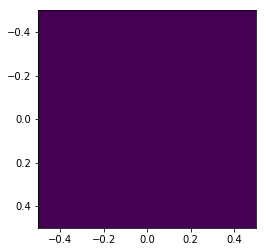


Filtro Corrente: 
 [[[-2.94266160e-02  2.55457065e-02 -2.01316210e-02 -3.59783323e-02
    5.71830227e-03  2.38161589e-02  4.63437618e-02  3.18605339e-02
   -4.04475822e-03  2.62468468e-02  5.77279621e-02 -6.21585312e-03
    4.11157237e-02  1.59254165e-02 -1.10635034e-02  1.00199183e-02]
  [-3.11317959e-03 -3.88228950e-02  2.47367800e-02 -7.43155281e-03
   -1.45055634e-02  3.98152055e-02 -8.39745119e-03 -2.40266105e-02
   -1.32051859e-02 -8.00002675e-03 -2.46592880e-03  1.30240032e-03
    4.49723916e-02 -5.36674663e-02 -2.41348979e-02  2.65905060e-02]
  [ 1.42849437e-02 -2.23520785e-02  3.67539326e-02  2.73851312e-02
   -9.36018435e-03 -1.10926983e-02 -1.79010038e-02  2.95532496e-02
    5.99551788e-02 -2.35867215e-02  5.70439513e-02  5.56013240e-02
   -9.88806878e-03 -6.58823714e-03 -4.94770381e-02  1.66754970e-02]
  [-1.12970118e-02 -1.00780021e-02  5.96574116e-03  1.05440677e-01
    4.94419747e-03 -3.27632950e-02 -1.65730587e-02  6.29987167e-02
    2.29746736e-02 -1.61483314e-02  1.6

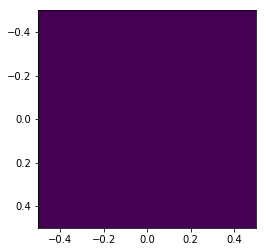


Filtro Corrente: 
 [[[-0.01488411 -0.00435533 -0.01435948 -0.02427118 -0.01150215
    0.03488652 -0.06636869  0.00802583 -0.01184263 -0.01924296
   -0.06997877  0.0060828  -0.01645987  0.04827228 -0.05596589
    0.04178343]
  [ 0.03362271 -0.01764362 -0.08269007  0.01604119 -0.00174545
   -0.08497808  0.04559789 -0.01439903 -0.00638418 -0.00094865
   -0.00054216 -0.03328799  0.0325423  -0.0261251   0.01720657
   -0.01333657]
  [ 0.02114217 -0.01517898 -0.03032368  0.00855807 -0.05271823
    0.04099759  0.02711638  0.00286143  0.00625038 -0.03286709
   -0.01048956 -0.01793372 -0.02577369 -0.01136466  0.0850599
    0.06299006]
  [ 0.01167758  0.03220889  0.01807406  0.005573   -0.01154818
    0.04381412  0.04739749  0.0541582   0.0487047  -0.01085775
   -0.01163619 -0.02487789 -0.02690862 -0.02564674  0.00729049
   -0.07481845]
  [ 0.04720167  0.03934995 -0.06359886 -0.03620266 -0.01508083
    0.02628632 -0.03163517 -0.02095964  0.02280862  0.02062386
   -0.02399386 -0.00995621  0.00411

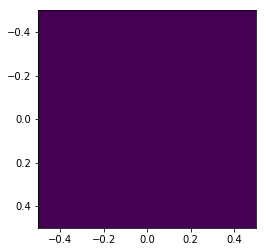


Filtro Corrente: 
 [[[-6.49416293e-03 -5.78390544e-02  1.81812896e-02  2.40418918e-03
    1.98957676e-02 -1.30299664e-02 -2.26228205e-02 -1.94476662e-02
   -2.82820963e-02 -1.99810184e-02 -2.91797351e-03  2.32568261e-02
    1.06477503e-02 -6.14336732e-02 -1.52722711e-02 -1.44622340e-02]
  [-9.41228355e-03 -5.97286900e-02  1.53692617e-03  6.79039529e-03
   -1.16711192e-03 -6.24086322e-02 -1.91632043e-02 -1.48769029e-02
   -7.99493502e-02  2.22131122e-02  3.20464949e-02  6.93714022e-02
    8.19928638e-03  3.08202583e-02 -2.45851819e-02  1.23586503e-02]
  [ 1.18606660e-02  4.37962258e-02  4.05197866e-03  3.78433113e-03
   -4.89009285e-02  1.94721279e-02  5.74568148e-02 -6.19533089e-03
    7.46030812e-03  3.17268823e-02  3.31281835e-02 -4.08062703e-02
    3.66662165e-02 -1.55484543e-02  5.51151118e-03 -1.55624258e-03]
  [ 3.96023476e-02  1.94765547e-02 -8.37995057e-02 -1.06807521e-02
    5.43654085e-02 -2.71174071e-02 -3.27586326e-02  3.74278393e-02
    3.83814185e-02 -1.14011504e-02  3.1

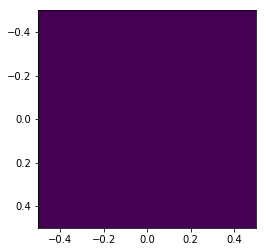


Filtro Corrente: 
 [[[ 0.01966138  0.04594984 -0.00981014 -0.03694411 -0.04185429
   -0.00331715 -0.02449543  0.05440758  0.03385619 -0.02488462
    0.02000763  0.05912255  0.04257783  0.01297843  0.04345008
    0.00064909]
  [ 0.00041019 -0.01683452 -0.01822561  0.05495419 -0.02463756
    0.01508362 -0.0074282   0.00286472 -0.05233587 -0.04365955
   -0.01202866  0.01219213  0.01120141  0.00905091 -0.03613535
   -0.06936922]
  [-0.01038149 -0.00722964  0.03547483 -0.04060308 -0.01176335
   -0.06207458  0.02147081 -0.02166449 -0.02978337 -0.02953123
    0.00667801 -0.0075913   0.03949085 -0.05330524  0.00435379
    0.00415721]
  [-0.00877249  0.02887792 -0.05511841  0.00135198  0.01841364
   -0.04468146  0.03369633  0.00186179 -0.01894865  0.05837119
    0.10076686  0.01472655 -0.04272131 -0.0490023  -0.02446337
   -0.01355685]
  [-0.02092745  0.05321683  0.01720005 -0.03225952  0.02079165
   -0.00797446 -0.05292712 -0.01575598 -0.03863147 -0.05092432
    0.06642193  0.04046567 -0.0214

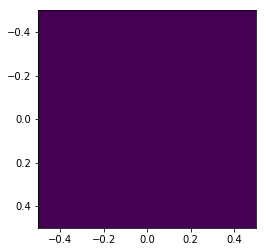


Filtro Corrente: 
 [[[ 0.01260867 -0.02125621 -0.00180935  0.05429753  0.00620196
    0.00702065 -0.02636412  0.0453789  -0.00107166  0.02801382
    0.00174942  0.02093858 -0.02934585  0.02358947  0.03413916
   -0.06065545]
  [ 0.02857763 -0.0078966   0.00375369  0.0252506   0.0502224
   -0.04868814 -0.05348859 -0.01705171  0.00269904  0.03228624
   -0.02368347 -0.03928082  0.03912538  0.04387645  0.01532734
    0.02637268]
  [ 0.04297061 -0.02495808 -0.05105048  0.02593355  0.096838
    0.02890427 -0.02693058  0.01515658  0.02256638  0.00168986
   -0.0050661   0.03143397 -0.03543654 -0.0024221   0.03700464
    0.01580904]
  [-0.03900275 -0.05642547 -0.00513658  0.0074901   0.02916103
    0.03181257 -0.06695411  0.03106606 -0.03008529  0.01558008
   -0.03917827  0.03918195  0.03921662  0.03214182 -0.00410482
   -0.02619835]
  [-0.04562174  0.00034153 -0.00521549 -0.01081633  0.00587625
   -0.01951311  0.05827566  0.02037806  0.01183289  0.08153023
    0.02116938  0.00045078 -0.0303956

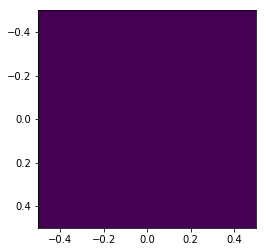


Filtro Corrente: 
 [[[ 0.04549663 -0.0412918   0.0570935   0.01838654 -0.04794163
   -0.03455682 -0.01393958 -0.06341211  0.03057933  0.0097801
    0.03877613 -0.02465666  0.03884812 -0.02863121 -0.05509349
   -0.03132252]
  [ 0.03223756  0.06927371 -0.03053198 -0.00577016  0.07280379
   -0.01821707 -0.01243118 -0.01517437 -0.01333794 -0.08342216
   -0.00836974  0.00721143 -0.06269501  0.02407107  0.05904869
   -0.0503023 ]
  [ 0.03049405 -0.03719138 -0.0300676  -0.01220455  0.04753601
   -0.05554383  0.04530707  0.0231264  -0.00588767 -0.00596461
    0.03753752  0.0516061   0.00043506  0.0549777   0.07597295
    0.04735218]
  [ 0.01036398 -0.03649811 -0.04469519 -0.06117167  0.07560625
   -0.0219354  -0.02162676  0.04580759 -0.01097227  0.00585335
    0.01295064  0.00900518  0.02742373  0.00650963  0.01194683
    0.01842603]
  [ 0.01000425 -0.04335782 -0.01883904  0.00445679  0.02799217
   -0.01414452 -0.06263806 -0.06080119 -0.01212941 -0.04391537
    0.01119025 -0.02716321  0.01276

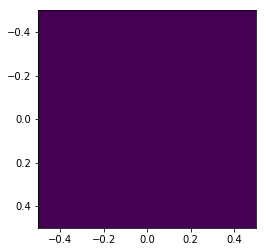


Filtro Corrente: 
 [[[-0.04695124 -0.0157558   0.00435828  0.03246732  0.02978352
    0.04623563 -0.05594009  0.02006097 -0.04637199  0.01828749
   -0.0110192   0.10281322  0.04429333 -0.04789417 -0.03704626
   -0.01169596]
  [ 0.03175819 -0.02786868 -0.00059538 -0.00909742  0.02945747
   -0.00954097  0.01665611 -0.01237614 -0.04356053 -0.01153085
   -0.00257513  0.0202963   0.03430038  0.01937004 -0.01852442
    0.00645855]
  [ 0.01775655  0.02937514  0.00909774 -0.05401918  0.05226771
    0.03258094  0.04283188  0.06273128  0.01415328  0.02000387
    0.02043965  0.02816506  0.01363164  0.02827159  0.05273782
    0.05449274]
  [ 0.01801503 -0.0113777  -0.06083286  0.00549702  0.04535757
    0.0418921   0.02864242  0.0137424  -0.01297179 -0.04131909
   -0.00292019  0.00423631  0.02098103 -0.03119345  0.03686758
   -0.036544  ]
  [-0.03304547  0.02973267  0.08043052 -0.04080703 -0.03099212
   -0.04553098 -0.05622576 -0.00631394 -0.01575174 -0.07702564
   -0.01804515  0.06968549 -0.0020

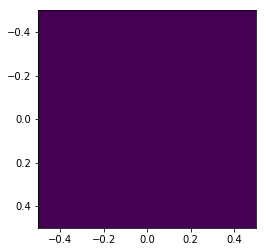


Filtro Corrente: 
 [[[-0.01804521  0.00401923  0.00711583  0.00408911 -0.01455869
   -0.0490561   0.0048614  -0.03124711  0.02064035 -0.02548238
    0.01253341 -0.00515129 -0.00767262  0.02291534  0.03420563
   -0.0157313 ]
  [ 0.0628268   0.02666388 -0.06668821  0.00221268 -0.01156876
    0.01917632  0.0450388  -0.03021763  0.02672404 -0.06916686
    0.08659844 -0.00393601 -0.00534172 -0.00956049 -0.03458394
   -0.02767671]
  [-0.07267497 -0.00590147  0.01516249 -0.01311048  0.0243997
   -0.0321304  -0.02150376 -0.00658843 -0.0994746   0.03058195
   -0.00741982  0.00418895 -0.02393252 -0.02651944  0.00126372
    0.02431906]
  [ 0.00148608  0.03028635  0.038181   -0.00647732 -0.09451164
    0.00958232 -0.00732574  0.03463009 -0.01827575  0.00210352
   -0.02450549  0.01851839 -0.02376148 -0.00207328  0.03391954
   -0.01663129]
  [-0.01653845  0.01393044 -0.03690526 -0.00569493  0.02444214
    0.0515288   0.00913989 -0.00679767 -0.01934771  0.01124905
    0.02295429 -0.01493822  0.01988

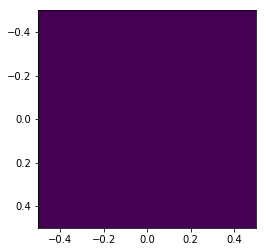


Filtro Corrente: 
 [[[ 0.03740808  0.02601211  0.017378   -0.00974554  0.09115925
   -0.02666715  0.03301897  0.05253523 -0.02777896  0.02467151
    0.02931508 -0.00043097 -0.02737657 -0.01686506 -0.02026796
   -0.01279564]
  [-0.02014925  0.03446176 -0.02948934  0.00940757 -0.02742662
   -0.07836611 -0.01356932 -0.00968238 -0.00420197  0.01757919
    0.00927783  0.01577951 -0.01285825  0.03312643 -0.01991228
   -0.02781263]
  [-0.01950688  0.04182554  0.0257998  -0.03261899 -0.00583819
    0.03857932  0.01417653 -0.00869724 -0.01022457 -0.0328755
   -0.00659005 -0.00780556 -0.03306546  0.00449781  0.06072553
    0.00904827]
  [ 0.04047691 -0.01658382 -0.01209991  0.00875222  0.04285364
   -0.03448846 -0.02987383 -0.02608766 -0.02451339 -0.00996179
    0.01015722 -0.02617283 -0.03889637  0.01338289 -0.03453513
    0.00546954]
  [-0.01267094  0.04760598 -0.03313679 -0.03984333  0.02131702
    0.03122143  0.03790704 -0.06395344  0.03126027 -0.03949985
   -0.03842515 -0.0309338   0.04795

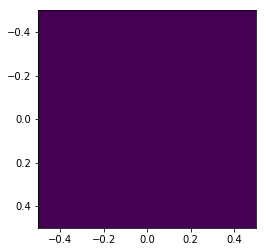


Filtro Corrente: 
 [[[-2.49543641e-02  5.53876717e-02 -5.60745899e-02 -2.31557061e-02
   -9.61219113e-02 -1.71786123e-02 -9.07856484e-03 -3.41890312e-02
   -9.94239292e-03 -6.10148247e-02 -2.43351681e-02  3.06587574e-02
   -2.19355438e-02  4.21744998e-02 -1.02871985e-02  1.45674910e-03]
  [-5.24051304e-02  4.20142998e-02 -8.20071356e-03 -4.37530521e-02
   -3.49694297e-02  5.98687638e-02 -2.94159709e-04 -4.22197824e-02
   -2.20531436e-02 -3.71604708e-02  2.52655089e-02 -8.75865098e-03
   -7.71162831e-03 -4.58796432e-02 -2.58884390e-02 -2.43701012e-02]
  [ 1.60977380e-02  1.00167463e-01  3.92569558e-03 -2.28921449e-02
    2.84298400e-02 -2.14966279e-03 -5.56037290e-03  4.31108296e-02
   -2.21422843e-03 -1.99240773e-02 -2.10681587e-02  3.09103173e-03
    1.50023900e-02 -2.08399332e-04  2.89343733e-02 -1.96471988e-02]
  [-6.04822262e-03  1.56379595e-02 -6.13498384e-02  3.40398557e-02
    3.13554073e-02  2.29277080e-02  6.63187699e-03 -1.09519560e-03
   -2.31357757e-02 -4.51345859e-02  3.0

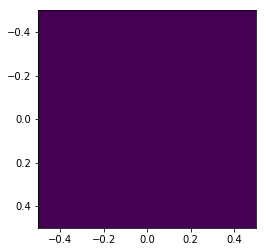


Filtro Corrente: 
 [[[ 2.57090564e-02 -5.27594193e-02 -6.90480867e-02 -9.93357669e-02
    1.99292590e-02  1.68954409e-02 -4.46073352e-03 -2.24276624e-02
    6.04268122e-03 -2.88703251e-03  1.45618397e-02 -1.31227904e-02
   -2.42050650e-02 -1.51928252e-02 -2.43709739e-02  2.45587443e-02]
  [ 2.81267639e-02  3.67272213e-02  6.51150053e-02  3.27876281e-02
    3.68519572e-02 -3.24921717e-02 -2.51347860e-02 -5.15336322e-02
    1.03058373e-02 -8.13639161e-05  1.14396796e-02  4.85568949e-02
    8.96303006e-02  1.93955092e-02 -4.56025951e-02  1.34231179e-02]
  [-2.97330489e-02 -1.82520775e-02 -1.57959351e-02  1.62935516e-02
   -4.14342274e-02 -1.14468929e-02  7.75134896e-02  2.87755369e-02
    3.93962244e-02  3.61469001e-02 -2.12764990e-03  1.53992686e-02
    1.49932681e-03  6.60790970e-02  3.65637215e-02  2.57506642e-02]
  [ 9.30418953e-03  1.86532807e-03  4.78664976e-03 -6.06524767e-03
    4.27182222e-03  2.72259731e-02 -1.02766666e-02  2.36608014e-02
   -5.12282314e-02 -4.85303184e-02 -8.2

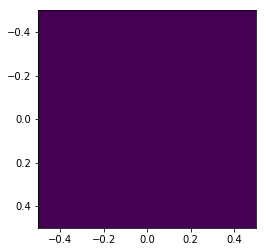


Filtro Corrente: 
 [[[ 1.69255621e-02  1.13074671e-02 -1.00546452e-02  1.74009858e-02
    3.70324879e-02  3.05624666e-03  3.53114509e-02  1.78095450e-02
    2.78613159e-02  5.69444346e-02  6.09970779e-04 -3.19433831e-02
   -5.00940302e-02 -4.46508340e-03 -2.26249793e-02  1.40762663e-03]
  [-4.12160662e-02  1.61764752e-02 -8.87699397e-03  8.62491217e-02
   -4.15646743e-02 -1.69687735e-02  2.44784588e-02  3.34415951e-02
   -1.29723614e-02  1.39127587e-02 -3.31624995e-02  3.58669831e-02
    1.81268248e-02  1.45120991e-02 -4.65504969e-02  2.00960565e-02]
  [-1.38261774e-02  1.58534462e-03 -1.44609345e-02 -5.08997207e-02
    1.75099581e-02 -2.15818996e-03 -5.20968000e-02  1.19806271e-02
   -5.20451712e-02 -3.18232428e-02  1.04569998e-02  1.17678811e-02
    3.67471912e-02  4.31093749e-02  1.62224598e-02 -1.18490682e-02]
  [ 5.24486327e-02 -2.97355354e-02  1.25914575e-02 -3.89024359e-02
    6.40375194e-03  1.85306024e-02 -3.49500687e-03  3.22311345e-02
    1.65467268e-02  1.57610854e-02  4.3

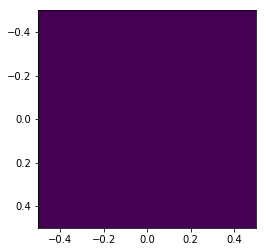


Filtro Corrente: 
 [[[ 0.01050926 -0.02347369  0.04863971 -0.03924509 -0.05067712
    0.038963   -0.0165447   0.04697335 -0.01577789 -0.02009023
    0.01609597 -0.00458524  0.03987693 -0.01719909  0.03608964
   -0.03492068]
  [ 0.05229258  0.01754494  0.06568739 -0.01041676  0.04412915
   -0.04011105 -0.02861641 -0.01568988 -0.01247104 -0.02324404
    0.04573925  0.01163508 -0.04254781  0.05488397 -0.00337134
   -0.02587925]
  [ 0.02146186 -0.06035575 -0.06366446  0.01073873  0.02630351
    0.04434943 -0.02281135  0.03670429  0.00121855 -0.02249135
    0.01678754  0.07496869  0.0129598   0.00135127  0.02467502
   -0.03639987]
  [ 0.01090649 -0.02350487 -0.02826019 -0.00272777 -0.01282044
    0.02445566  0.03590735 -0.00773004  0.06038496 -0.00589758
    0.02406221  0.00129134 -0.08508741 -0.01764118 -0.00402765
   -0.00526232]
  [-0.03247148  0.01285883 -0.03318675 -0.02032316  0.0185951
    0.01318072  0.05074415  0.01645001 -0.05008146 -0.03892964
   -0.00569555  0.00044862 -0.01776

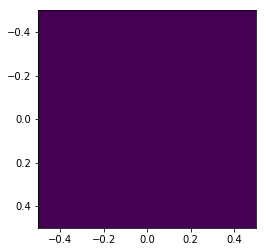


Filtro Corrente: 
 [[[-9.25765403e-03  3.01398685e-02  3.09664638e-02 -7.22663508e-02
   -2.73631197e-02 -2.71661828e-02 -2.06351172e-02 -5.49340779e-02
    2.03889208e-02  2.47534274e-02  1.43750831e-03 -2.78657963e-02
    2.26749554e-02  4.53626727e-03  4.95275163e-02 -8.14671241e-02]
  [-4.88514501e-03 -6.21923478e-02 -1.62402597e-02  1.64944568e-02
   -2.39964569e-02 -6.08781315e-02  2.75340808e-02  4.18291953e-02
    3.31132400e-02 -5.84662122e-02  6.12382230e-02 -3.72745818e-02
   -1.41432049e-02  3.99802069e-02  9.90203384e-03  5.40216733e-02]
  [ 1.22844453e-02  6.39775520e-03  3.01423773e-02 -8.42906108e-02
    8.88099802e-03 -4.21947537e-02 -2.06505869e-02  1.33269120e-02
    3.96890812e-02 -3.97471393e-02 -3.80337483e-02  2.13130800e-02
    2.11602436e-03  5.44665042e-02  9.46689018e-03 -4.16100882e-02]
  [-4.18548542e-03 -5.22465633e-02  6.02273108e-02  4.12081464e-02
    2.38747284e-02  1.00108890e-02  2.73210567e-02 -1.05827752e-02
    3.04506655e-02 -2.83592648e-02  3.7

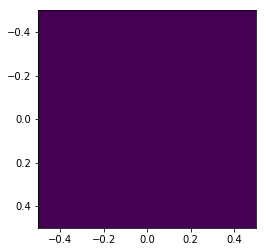


Filtro Corrente: 
 [[[ 3.78474022e-03 -3.40368318e-03  5.55952810e-02  6.74510601e-02
   -3.65999131e-02  1.74236525e-02  6.37189173e-02  7.14791249e-03
   -7.70768405e-02 -3.71724079e-02  6.82983704e-02  7.35137371e-03
   -2.78119800e-02 -6.32033445e-02  2.26863453e-02  3.64117632e-02]
  [-9.50724097e-05  2.74373165e-02 -3.96936135e-02 -2.82482938e-02
    2.80941778e-02  1.82269441e-04  2.87298177e-02  1.97128878e-02
   -1.17131822e-01  3.08430626e-02  1.70138792e-02 -3.12827437e-02
   -3.04519689e-02 -4.09684347e-02 -5.78943892e-02  1.51334359e-02]
  [ 5.60673072e-02  4.42063246e-02  2.87721942e-02  1.99685145e-02
   -3.23543357e-02  4.88947522e-02  1.70973459e-02  5.68281958e-02
   -6.39670774e-02 -1.34094492e-02 -3.08297042e-02 -4.06370975e-02
   -6.23286141e-02  4.16330745e-02 -1.08605443e-02 -4.35355176e-02]
  [-3.28717259e-02  5.51799801e-02  1.51350678e-02 -6.29888809e-04
    8.65489780e-03  4.94818363e-02 -2.41889672e-02  3.76427123e-02
   -3.40276855e-02  1.99067694e-02  2.4

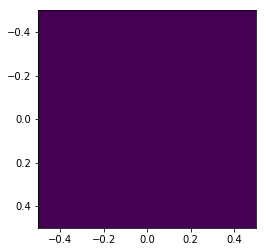


Filtro Corrente: 
 [[[ 2.32870932e-03  3.17507957e-02 -2.31803416e-02  8.80634016e-03
   -1.23172251e-02 -5.03308029e-02  3.64417400e-02  4.73045831e-02
    2.02034371e-02  1.60979203e-02  3.09166070e-02  4.91131752e-02
    2.86909224e-03 -2.97284428e-02 -8.58561896e-03 -6.89387509e-03]
  [-1.66343465e-02  5.33944970e-02 -1.35616250e-03 -2.50595637e-02
    1.13600467e-02  3.62274944e-02  1.06818015e-02  2.58963028e-02
   -6.22828275e-02 -6.42750069e-03 -3.96863913e-02  6.05529195e-02
    1.00395332e-02  7.55071024e-03 -1.76110229e-02 -1.34126653e-02]
  [ 3.55602757e-02  2.98962704e-02  7.00546290e-02  9.17950550e-04
    8.32902080e-03  4.20723896e-02  8.80892902e-03  2.75816195e-02
   -4.81092319e-02 -1.54650047e-02  2.34839158e-02 -1.03664370e-02
    6.35662155e-02  2.77453473e-02 -5.42818490e-02 -2.13157572e-03]
  [ 2.04717423e-02  5.17190654e-02  1.18790204e-02 -2.69523311e-03
   -1.27248269e-02  1.23701195e-02 -7.78566303e-03 -2.94828200e-02
    6.14071041e-02 -1.30156161e-02  7.7

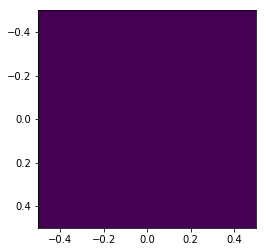


Filtro Corrente: 
 [[[ 0.00544191 -0.03966276 -0.02031402 -0.05070981  0.03670138
    0.02067858  0.01662185  0.00741198 -0.01267934 -0.0739383
    0.03257179  0.01554359  0.01987049  0.02664183 -0.03360156
   -0.0103179 ]
  [-0.01469983  0.00546889  0.04668741 -0.01023003  0.03529244
    0.01904257  0.01863477 -0.06193797 -0.00477571  0.08532669
    0.00481508  0.07268615 -0.04664647  0.01210269  0.05975204
    0.03498905]
  [ 0.05250023  0.02169028  0.03869705  0.02953163  0.03528005
    0.03172742 -0.00376077 -0.04139014 -0.0384825  -0.02523227
   -0.02321515  0.05918575  0.00850409  0.00177548 -0.04307127
   -0.01837302]
  [ 0.06762629  0.01344485  0.01805696  0.00546191 -0.03060059
    0.02586326  0.02744294  0.02719442  0.00323253 -0.02810215
   -0.03319462  0.03136373 -0.06190118  0.02557149  0.02866305
   -0.04137587]
  [-0.0354504   0.0093881   0.02334523 -0.00770644 -0.03343685
    0.00967603 -0.02244649  0.00232255  0.01057806 -0.00154692
    0.01840248  0.00796756  0.00164

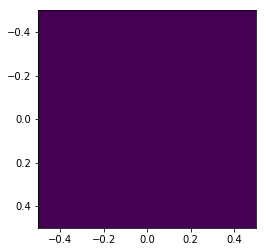


Filtro Corrente: 
 [[[-0.02599732 -0.01308988 -0.03282741 -0.01098585  0.05926215
    0.03298157  0.01126651 -0.0020495  -0.02359664 -0.03481584
   -0.00530228 -0.01219791  0.00456322 -0.01428745 -0.02941886
    0.04186623]
  [ 0.00779651 -0.02577297 -0.0266982  -0.05327746 -0.03750953
   -0.03203504 -0.06091654 -0.03307696 -0.02873692 -0.00585272
   -0.04949027  0.08755152  0.04679152 -0.0160548   0.02666254
   -0.04145662]
  [ 0.04039321 -0.0610872   0.00914095 -0.04679437  0.01324551
   -0.00618686  0.0346541  -0.0086061  -0.01693786  0.0186768
   -0.00512504 -0.01842605  0.03031712  0.06003774 -0.00848902
    0.00417349]
  [-0.05611685 -0.00752302  0.06245083  0.00292345 -0.00966702
   -0.11052573 -0.0012129   0.03521157 -0.0457789   0.01153489
   -0.01575985  0.03544908  0.03435001  0.00668454  0.00316218
   -0.0182891 ]
  [-0.02896262  0.00710897 -0.00252853  0.02147499 -0.05678193
   -0.02955994 -0.01169489 -0.02017413 -0.02569767  0.02747793
    0.03763492  0.07754488  0.03167

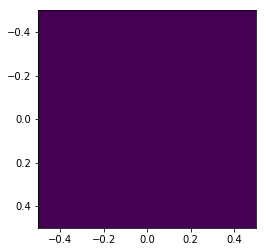


Filtro Corrente: 
 [[[ 2.75644570e-02  1.30902595e-02 -2.11886490e-02  7.49701441e-03
   -1.20161218e-02 -3.14464594e-02  2.07884594e-02 -1.93730017e-02
    1.95395716e-02 -5.64214639e-02 -1.94799783e-02 -2.16991246e-02
    5.61063672e-02  6.72200843e-03 -3.23709796e-02 -3.97403414e-03]
  [-5.49269520e-02  2.31686971e-02  7.44450707e-02 -3.83753670e-02
    4.09456249e-02  3.82880411e-02 -2.39975402e-03 -1.30186015e-02
    1.76541064e-02  5.00286910e-02 -2.19330470e-02 -2.13405580e-02
   -5.05878452e-03  8.61675083e-02  1.43604290e-02 -2.38973499e-02]
  [ 3.22892186e-02  5.63799849e-02  7.36881214e-02 -1.85737145e-02
   -2.66697451e-02  9.70242929e-03 -2.96995737e-02 -8.04806203e-03
   -6.61064185e-02 -1.99543827e-02  3.26808984e-02  2.05080550e-02
   -1.33682633e-02 -1.47851491e-02  8.01493999e-03 -8.49298896e-03]
  [ 9.16405228e-03 -3.93404684e-02 -1.64947587e-02  2.89585256e-02
    4.26380209e-02 -8.63178181e-03  2.04690185e-03  8.30288033e-03
   -7.66920993e-02  1.89774234e-02  1.9

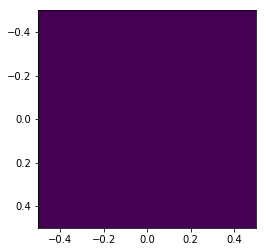


Filtro Corrente: 
 [[[-3.32611374e-02 -5.80041926e-03  3.24273783e-02  2.54892274e-02
   -1.55644367e-03 -4.18504043e-02  2.14627311e-02  2.29915265e-02
    4.31083185e-02  2.96194736e-02  2.81033258e-02 -2.08282089e-02
    4.30907995e-02 -2.34735145e-02 -5.24314565e-02 -3.18094175e-02]
  [ 1.54809190e-02  1.37672884e-02  4.71474561e-02 -5.11242738e-02
    1.23373265e-03 -1.58575692e-02 -5.23494877e-02  2.74481169e-02
   -2.30613768e-03 -7.43983381e-02  4.64147534e-02  1.31618285e-02
    5.95219514e-02 -2.49977604e-02 -2.45541894e-02  3.47130728e-03]
  [-9.38842938e-02 -4.37442678e-02 -1.01739868e-02 -7.68303787e-02
   -1.37450051e-02 -6.60953486e-04 -2.84290861e-02 -4.40657579e-02
   -1.83667326e-02 -2.05782175e-02 -2.60596300e-02  6.48096887e-03
    4.57278918e-03  1.36270624e-02  2.59295502e-02  2.07505402e-02]
  [ 1.59753574e-02 -2.86377008e-02  2.14114456e-05 -5.60541177e-02
    6.44033162e-02  6.03383934e-02 -1.31484324e-02  8.79987403e-03
    7.28334880e-03  3.92810778e-02 -5.0

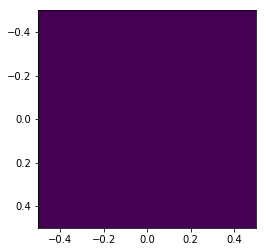


Filtro Corrente: 
 [[[ 0.03298703 -0.0248367  -0.06629609 -0.0343433   0.03670333
   -0.02833557 -0.02272777 -0.00698258  0.00673211  0.00908146
    0.04865829  0.02648783  0.03453771  0.02180107  0.00506595
    0.02606308]
  [ 0.01352144  0.04202555 -0.02701137  0.07381165  0.04868337
    0.01181646 -0.02351427  0.05644512 -0.02449973 -0.06065035
    0.01142646  0.03526397 -0.02668292 -0.0510543   0.00616223
   -0.0623627 ]
  [ 0.00134702 -0.06185694  0.04573232  0.00197723 -0.06208698
    0.01117712  0.02323099  0.00199985  0.01451501  0.01742477
   -0.02433678  0.0013879   0.00658746 -0.01216483 -0.00969173
    0.03978901]
  [ 0.02288701 -0.02290513  0.01681534 -0.00874068  0.02003584
    0.01998798  0.01989185 -0.01195757 -0.02109531 -0.01328227
    0.01081969  0.01495959 -0.00690428 -0.01452556  0.04892823
   -0.02980153]
  [ 0.05801637  0.01558921  0.01283547  0.02541801 -0.0004676
    0.01404366 -0.0428254  -0.0717941   0.03186993  0.05168974
    0.02193301 -0.03612496  0.01700

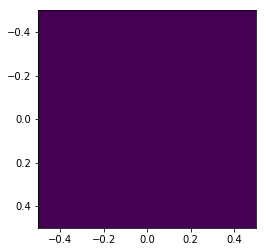


Filtro Corrente: 
 [[[-1.37441147e-02  3.56409461e-02  1.84812023e-02  5.98628485e-04
   -1.15062431e-02 -1.97166982e-02 -4.85378588e-02 -6.23231925e-02
   -7.33503242e-02 -2.31855157e-02  3.28315510e-02  1.53319400e-02
    3.89299540e-03  3.83487284e-02 -7.68797434e-03 -9.12769559e-02]
  [ 1.58553056e-02  3.71902101e-02  7.93745421e-02  6.44502267e-02
   -4.00145185e-02  2.14030158e-02 -4.89985381e-03  4.47677679e-02
    3.83141511e-03 -1.91221717e-02 -3.20267524e-02  3.77989676e-04
   -3.93817199e-02  5.65365000e-02  2.69290301e-02 -2.83261823e-02]
  [ 6.47376663e-04  5.19425803e-02 -7.27391353e-02  1.18616938e-02
   -3.92750591e-02 -1.67918903e-02 -2.49275422e-02 -3.74498200e-02
   -1.26135964e-02 -1.06042461e-02 -5.28727697e-03  2.32502066e-02
   -4.35678723e-02  2.54132647e-02  1.72043505e-02 -1.31684311e-02]
  [-1.38076350e-02 -2.23323774e-02 -4.61026433e-02  5.48962749e-03
   -1.06075941e-02  4.63008111e-03 -2.77931974e-02 -8.26761149e-03
    6.25104262e-02 -4.09829653e-02 -4.1

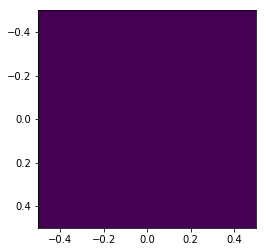


Filtro Corrente: 
 [[[ 1.22737360e-02  3.14131238e-02  3.16090848e-02 -2.11822712e-02
   -1.56656427e-02 -2.00619725e-02 -3.13515812e-02  1.60064195e-02
    2.43912092e-02 -1.35223328e-02 -5.58651695e-02 -5.31869925e-02
   -8.62761503e-03 -1.07308402e-02 -6.18747143e-02  3.55255444e-02]
  [-6.56066378e-02 -8.52536201e-02  1.03840250e-02  1.37332105e-02
    3.31334451e-02  1.83793411e-02 -2.07715417e-02 -4.15422613e-02
    2.20672967e-03 -3.63645057e-02  6.70424173e-02 -2.21008952e-02
   -1.63814578e-02 -1.86772720e-02  2.38932461e-02 -1.79265655e-02]
  [ 5.89789253e-02 -9.01753890e-02 -2.82005357e-02  3.29855394e-02
   -4.18002392e-02  2.15328966e-02  3.88230751e-02 -1.36432000e-02
    5.67260823e-02 -3.00750249e-02 -2.03622806e-02  4.42828671e-03
   -3.84831357e-02 -1.95912796e-02 -1.33829569e-02 -5.62280822e-02]
  [ 6.68174854e-02  2.70216611e-02 -5.36708782e-03 -3.22011916e-02
   -1.29597704e-02  5.08755452e-02  2.33309892e-03  2.43794240e-02
    2.00703754e-03  1.31184513e-02  8.6

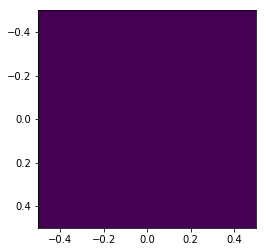


Filtro Corrente: 
 [[[ 2.84551642e-02  1.93349941e-02  5.30875985e-02 -4.76540346e-03
    4.73301804e-02 -1.06417314e-02  6.59512241e-02  1.13044438e-02
    3.55068997e-02  1.72793687e-02 -9.12190336e-02  3.68673961e-02
   -4.54266990e-03  4.37987344e-03 -1.45238166e-02  1.05436705e-02]
  [ 1.33271546e-02 -4.42131576e-02 -9.72677697e-03 -1.18059139e-02
    2.51357755e-02 -3.06302833e-02  4.18870288e-02 -3.81171448e-02
    1.97048993e-03  2.36440685e-02  5.02185588e-03  1.86157396e-02
    6.22587881e-03  1.11211546e-02  3.17707143e-02  1.07794311e-02]
  [ 7.00947894e-02  5.41664016e-02  4.55928719e-03  5.00134601e-02
   -4.94278949e-02 -6.60484166e-02  5.86858058e-03 -5.18164262e-03
   -8.97250312e-03 -6.75433254e-03 -4.61982354e-03 -3.17994872e-02
   -2.55668861e-02 -5.11171987e-03 -4.37671176e-02 -8.74064671e-03]
  [ 4.70846644e-02 -1.63600765e-02 -3.52415291e-02 -3.21085591e-02
   -4.55692905e-02  2.43142090e-02 -5.08142471e-02  3.78286475e-02
    8.58561309e-03 -6.07245178e-02  4.6

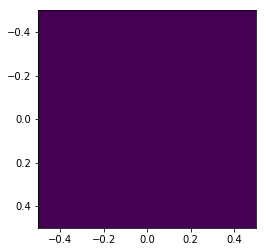


Filtro Corrente: 
 [[[-0.01245918 -0.0180351  -0.01831111  0.01845573  0.01994397
    0.02927315  0.03039916  0.02776101  0.05567842 -0.00790289
   -0.00195367 -0.04359459 -0.00855066 -0.05327564  0.03653699
   -0.02509032]
  [ 0.02283486  0.08061105 -0.0412976   0.03426693  0.0047816
    0.01192928 -0.00769119 -0.04295557  0.0100912   0.04375971
    0.00943201 -0.07233189 -0.05686672  0.01581985 -0.02488045
    0.03130695]
  [-0.0323167  -0.01997038  0.03768756 -0.00638365  0.0186295
    0.03913714  0.06333976 -0.02302547 -0.00917476 -0.02209486
   -0.00856957  0.07577415 -0.00045556 -0.03070023 -0.00890655
    0.01909542]
  [-0.04962435  0.01429955  0.02731797 -0.03508975  0.01588602
   -0.02813507 -0.04753399  0.02845263  0.01238374  0.01664857
   -0.00521512 -0.03844914  0.0015113   0.00570073 -0.03516078
    0.02542848]
  [-0.01654676 -0.01985355  0.00268445 -0.04908931 -0.03139192
   -0.03368724  0.03854546 -0.02680994  0.02761289 -0.04860594
    0.0040391  -0.02267973 -0.016275

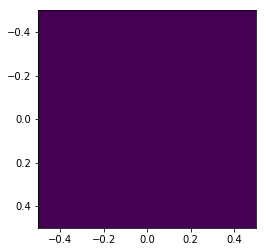


Filtro Corrente: 
 [[[ 0.02674211 -0.02861778 -0.02445558  0.03785581  0.00992763
   -0.0275228  -0.01287897 -0.04866038 -0.0300423   0.01077539
    0.01097611  0.04806461 -0.01016459 -0.02857869 -0.0004229
    0.02258604]
  [ 0.04036324 -0.05371001  0.04353706  0.00486118 -0.03780359
    0.04161926 -0.00164053 -0.02060337  0.02533224  0.01103774
   -0.03136555 -0.08221227 -0.0131391   0.01005509  0.00462306
   -0.01195405]
  [-0.01012802 -0.00946084 -0.01865547 -0.0596008   0.07759641
   -0.01643532 -0.01115179 -0.04083481 -0.00221886 -0.06483733
   -0.03733512 -0.07994242 -0.02188767  0.00219795 -0.02253133
   -0.06071587]
  [-0.02515245 -0.02279402 -0.06259143 -0.0514267   0.05423741
   -0.03020997  0.04524858  0.00518331  0.00965318 -0.05043811
    0.01527852  0.00257492 -0.07000827  0.03544878 -0.01109475
   -0.03233368]
  [-0.0304233   0.0194893   0.02102707  0.01316525 -0.0046209
    0.06598646 -0.03144512  0.0536218   0.00476393  0.03326121
    0.00145519 -0.03997639  0.001458

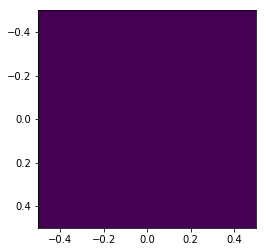


Filtro Corrente: 
 [[[-0.02998308  0.04567777  0.01877651  0.04647797 -0.00904322
   -0.03718523  0.0525509  -0.04560011  0.01064931 -0.05771232
    0.00856447 -0.02480741  0.0047684   0.03247196  0.04255938
   -0.00103889]
  [ 0.03462911  0.05048676  0.02964898 -0.00441005 -0.02363984
    0.02115816 -0.01833391  0.02150466  0.06577648 -0.02166563
    0.00537783 -0.02334993 -0.01671334 -0.02072172  0.00375783
    0.0313815 ]
  [ 0.02942642  0.03577835  0.01523667  0.00719182 -0.00710417
   -0.00866857 -0.00938838 -0.00545109 -0.03388127  0.02855681
    0.02788316 -0.01222584  0.03225346 -0.0033437  -0.01146513
    0.00738819]
  [ 0.03878581 -0.01304947  0.02690206  0.02902568  0.01934997
    0.03903182  0.00992306  0.00054272  0.02792734 -0.0156348
   -0.01979224  0.00856336  0.00071286 -0.00601797  0.06852554
   -0.04265247]
  [ 0.04136983 -0.0534191   0.04433208 -0.03799301  0.08868568
   -0.04260102 -0.00266827  0.12455841  0.00502036 -0.06210847
   -0.01019243  0.03724164 -0.02714

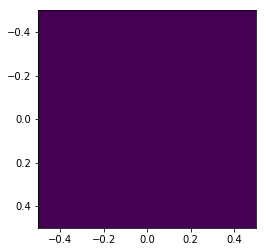


Filtro Corrente: 
 [[[ 1.99686540e-02 -4.98999716e-02 -2.16542162e-02  1.22591441e-02
   -1.07778782e-02  1.75483380e-02  2.13176289e-03  6.39122760e-03
    4.05634747e-02  7.61380855e-04  1.42666256e-02 -1.03385058e-01
   -1.79065835e-03  1.53048456e-02  3.29260230e-02 -6.81764020e-03]
  [ 3.11932948e-02 -3.43981944e-02  3.61774275e-02 -3.94114365e-02
    2.20400819e-02  1.94548827e-02 -3.97112571e-02  1.77945822e-02
    5.39952017e-02 -7.69737172e-02 -5.57961603e-02 -1.32771797e-02
   -2.12467128e-02 -6.43937968e-02  1.17317050e-02  4.04035678e-02]
  [-1.87573083e-02 -5.60505075e-03 -6.16806900e-02  1.56690592e-02
   -2.52250327e-02  2.79876095e-02  5.89547562e-02 -3.87062602e-02
   -4.08432307e-02  1.77013808e-02 -1.30724950e-02  6.55733214e-02
    1.95050968e-02  1.07414211e-02  1.71639375e-02 -7.65754435e-03]
  [ 6.72177916e-02 -2.83461548e-02  2.46701223e-02 -5.57278268e-02
   -8.87087562e-02 -7.43946282e-03 -4.16306837e-02  2.47069431e-02
   -1.53093210e-03 -1.00546075e-02 -1.2

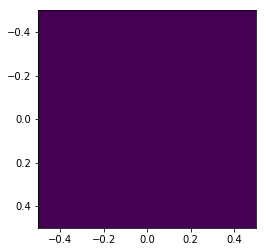


Filtro Corrente: 
 [[[ 9.09848418e-02 -1.14899116e-02  6.03359902e-02 -4.47838436e-02
   -1.66141071e-02 -1.22724831e-03  2.08451547e-02  1.99103653e-03
    6.68542490e-03  3.33215329e-02 -1.00225178e-03  6.02338697e-02
    3.73265786e-02  4.87350021e-03  3.53470496e-02  5.50379936e-02]
  [-3.04017013e-02 -1.12607972e-03  1.99697931e-02  1.31531614e-02
   -3.35052876e-03  5.14603302e-03 -6.98442536e-03 -4.44018986e-02
   -1.68880073e-02 -1.61769015e-02 -7.26067144e-02 -4.33100334e-02
   -1.07105649e-02 -2.02708017e-03 -8.19229223e-02 -3.03808703e-02]
  [-1.72668097e-02  4.00667062e-04 -2.98282852e-02  1.09594666e-02
    2.67618894e-03 -4.94532600e-03  4.65498280e-02 -6.92769567e-02
   -6.75693875e-02 -3.36071272e-02 -1.93613127e-02 -8.67421461e-03
   -1.66348743e-02 -6.89214169e-03 -9.57262303e-04 -1.86901151e-02]
  [-9.41678845e-04 -4.99239903e-02 -6.61624460e-02 -1.46448610e-02
   -3.57369467e-02  2.54919836e-02 -2.99932411e-02 -1.81967390e-02
   -3.52165680e-02 -1.75043896e-02  6.4

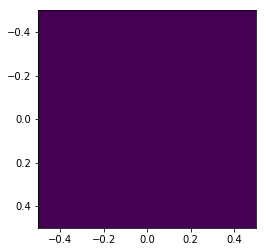


Filtro Corrente: 
 [[[ 0.03432069  0.00239421 -0.01179123 -0.0435098   0.00053562
   -0.00928799 -0.03415189  0.00956462 -0.04318643 -0.04048539
   -0.03327071 -0.03420712  0.02762388 -0.02161654 -0.00286991
   -0.0573636 ]
  [-0.00409905  0.04465198 -0.04026694  0.00785886  0.03082424
   -0.01668149  0.00081055 -0.06081825 -0.00032514  0.05284054
    0.04464707  0.01392476  0.02376531 -0.0114445  -0.04872347
   -0.01757456]
  [ 0.0316861  -0.00718424  0.00766061 -0.0152221   0.05091563
    0.02851897 -0.08180416 -0.00348864  0.05104152 -0.06904888
    0.0179181   0.02697548 -0.02036756  0.03628952  0.00471882
   -0.00791363]
  [ 0.07195094  0.0081865   0.00914922  0.01847065 -0.00733299
    0.06260828 -0.01725424  0.03117524 -0.01959558  0.04193543
    0.01765969 -0.00786173 -0.01369776 -0.02239937 -0.01740173
   -0.06615609]
  [-0.01371699  0.00607359 -0.01448553 -0.04052572  0.00159827
    0.00861913 -0.06074393 -0.04217081  0.05245565  0.02921225
   -0.0065811  -0.00400116  0.0277

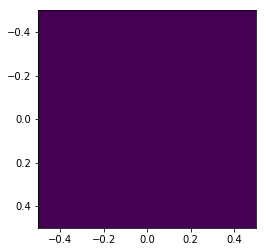


Filtro Corrente: 
 [[[ 3.22576229e-02  4.01466794e-03  5.23735635e-02  2.95830028e-02
    3.76178295e-03 -1.61641249e-02 -6.21335389e-03  1.25211187e-02
    2.13470103e-02  7.80211219e-03 -2.32160946e-02  8.47739198e-03
   -1.64635881e-02  1.35842379e-03 -2.47068575e-02 -3.53223771e-02]
  [-3.26664754e-02 -2.89798375e-02 -1.05623284e-02  4.27951981e-03
    5.55277914e-02 -4.02309175e-02  7.41404276e-03  1.14912992e-02
    1.71688266e-02 -2.93677847e-02 -5.56315064e-02  2.82369578e-02
   -2.10501831e-02 -6.30110240e-02  5.18407521e-02 -3.12194063e-02]
  [ 3.24498980e-02 -2.77401213e-02 -3.49656693e-02 -5.33417677e-02
    3.50327754e-02  8.86731293e-03  2.49874823e-02 -3.32461294e-02
   -2.60514779e-02  4.86448069e-02  5.80598282e-02 -6.65955783e-02
    3.17809929e-02  1.20537713e-03 -5.18545124e-02 -2.39896682e-02]
  [ 1.00743231e-02  3.65076899e-02 -5.15165788e-02  4.15132970e-02
   -2.68065040e-02 -4.62094568e-02 -2.76491742e-02  4.19456424e-02
   -1.98332409e-02  5.69534859e-02  1.2

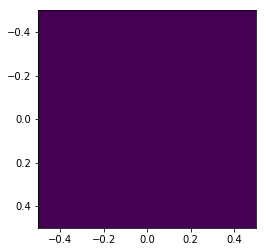


Filtro Corrente: 
 [[[ 0.04389486 -0.06673605 -0.02642713  0.03730851 -0.00339353
    0.00596476 -0.00214925 -0.01277408 -0.02432235 -0.0297291
   -0.01570933  0.03696997 -0.01398169  0.00991524 -0.02331494
    0.03727921]
  [ 0.06324753  0.01273029  0.01374155 -0.00040922  0.03500721
   -0.03580632 -0.032649   -0.01512239 -0.03186636 -0.01524611
   -0.0045082  -0.04572057  0.02644522  0.06356362 -0.00280633
   -0.01210541]
  [-0.0157811  -0.00351209  0.01135503  0.02854344  0.01580802
    0.00936665  0.12093942  0.06769233 -0.02044234 -0.02120544
   -0.03188767 -0.05483692  0.03764401 -0.0152496  -0.01696716
    0.02258483]
  [ 0.04095697  0.0038756   0.05056107  0.00743155  0.03485255
   -0.02978515 -0.04381183 -0.00543863  0.08795065 -0.06947627
    0.03024919 -0.01277298 -0.01272345 -0.02439146 -0.01036059
   -0.00609115]
  [ 0.01240521 -0.02621153 -0.08800323  0.00990119  0.02152801
   -0.04751675 -0.02075191 -0.01895204 -0.01802661 -0.01720258
    0.03237928  0.00172621  0.00182

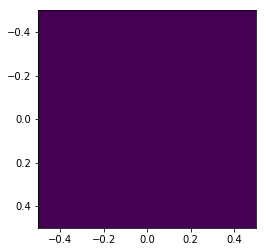


Filtro Corrente: 
 [[[ 1.47348789e-02 -6.32331855e-03 -2.03438706e-02  2.36893791e-02
   -1.83770757e-03  2.80190828e-03 -5.58003697e-02 -2.74465315e-02
   -1.44646549e-02  4.95146311e-02  5.86397047e-02 -2.97288208e-02
    2.78148097e-02 -6.41380807e-02  6.67729029e-02 -5.32341627e-02]
  [ 4.17541106e-02  5.68334208e-03 -2.95706879e-02 -5.63142004e-03
    9.50559439e-03 -5.37629925e-02  3.05042705e-03  3.59048899e-02
   -4.26063450e-02 -3.90122630e-02 -5.15148533e-02  1.68629161e-02
    1.27791330e-02 -3.48572506e-02  8.58908200e-02  2.82728784e-02]
  [ 1.08520185e-02  3.10013179e-02  1.89982453e-02  2.13089338e-02
   -1.40573327e-02 -2.60619593e-02 -3.95497232e-02  2.91545308e-02
    2.78849883e-02 -3.41035921e-02 -1.61441374e-02  8.03975950e-02
   -1.07028093e-02 -1.03526158e-02 -3.73837705e-02  2.90178045e-02]
  [ 1.11956261e-02  4.99905796e-02  7.74314397e-02 -2.94938436e-02
    2.31515643e-02 -1.37142448e-02  9.87641663e-03 -5.86426861e-03
   -9.95229628e-03  3.82902969e-02  9.8

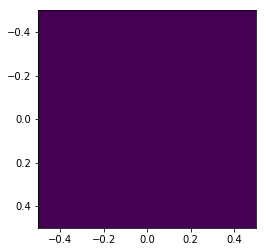


Filtro Corrente: 
 [[[-5.69514242e-02 -3.31842257e-02 -5.59119913e-02  1.82130774e-02
    3.42673147e-02 -3.61048045e-02  2.78922500e-02  5.74361316e-02
    4.50885086e-02  2.64329910e-02  3.60038424e-03 -7.47283098e-04
   -1.19111557e-02 -2.21040793e-02 -4.53964598e-03 -2.68688692e-02]
  [-2.16596365e-02 -3.86532939e-02 -6.54131660e-02 -1.35730385e-02
    3.55426819e-04  3.99283347e-02  1.89029082e-02 -6.24564606e-02
    8.45753035e-02  3.27431122e-02 -3.65836598e-02 -9.32281363e-03
   -8.06044109e-02 -8.18373460e-04  2.36247761e-02  6.34263956e-02]
  [-4.26447442e-03 -2.08061354e-02 -4.02018868e-03 -1.97039140e-02
   -1.55531365e-02  5.95673592e-02 -3.24788081e-02 -2.07911816e-02
   -2.27160278e-02  3.76974130e-02  2.73726862e-02 -2.48147702e-02
    1.84233878e-03  6.01770315e-02 -3.24307963e-02 -2.96496599e-03]
  [-1.93062462e-03  2.58378108e-02  1.76518428e-02  1.85675951e-02
    7.07425635e-02 -1.39129067e-02  3.60422226e-03  7.32460856e-03
   -1.66153328e-02 -3.83201375e-02 -4.2

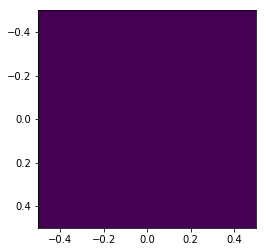


Filtro Corrente: 
 [[[-3.37682012e-03  5.91908604e-02 -2.52937656e-02 -7.93975421e-03
    6.26360760e-02 -1.06647748e-02 -6.77064825e-03 -4.87313174e-02
    6.64257925e-02 -2.27841202e-02 -2.21958696e-02 -1.84459872e-02
   -1.74463719e-03 -1.07288267e-02  3.69534662e-02  3.71589579e-02]
  [ 2.39091863e-02  7.38915277e-02 -3.62636736e-03 -1.68056564e-02
    4.87720779e-02 -1.33644877e-02  2.63604364e-02  1.97655087e-03
    3.07806602e-02  1.88115768e-02  2.02650405e-02 -3.42774374e-02
    4.35063387e-02 -2.13293529e-02 -1.50411307e-03 -6.04333680e-02]
  [ 1.05454882e-02  1.37561669e-02 -3.17553274e-02 -5.69420064e-03
   -5.92177817e-02  3.72711449e-02 -2.26182309e-03  1.48772956e-02
    3.12829582e-02 -1.45738111e-02  2.41462646e-02 -1.22479178e-02
    6.03001542e-03 -5.29774482e-02 -6.61594949e-02  4.39783824e-02]
  [ 3.26448957e-02 -2.17916501e-02  2.15708610e-02  9.97770575e-03
    4.39187602e-02 -2.63253162e-03 -3.38191340e-02 -8.85647890e-02
   -3.53860302e-02  1.41025927e-02 -3.8

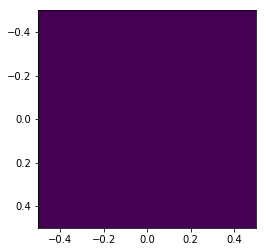


Filtro Corrente: 
 [[[-2.12758320e-02 -2.97510642e-03 -2.68546733e-02  1.24962500e-02
   -3.47571770e-02  5.77430132e-03  3.41895626e-02 -6.42308429e-03
    1.27614038e-02  3.54857829e-03 -7.38904183e-02  2.09378919e-02
   -4.69324715e-02  1.92506535e-03  2.66664658e-02 -2.65546754e-02]
  [-5.92783029e-03  2.16199948e-02  3.33731850e-02 -1.09069510e-02
    7.82645067e-02  1.81317733e-03 -4.12041486e-02 -4.62147380e-02
   -2.82202291e-02  2.03240527e-02  1.44145815e-02  5.76698499e-02
   -1.89839918e-02  1.92747915e-03  3.71674298e-02  3.30767551e-02]
  [ 7.06779950e-03  3.24226256e-02  2.44305582e-04 -6.92617193e-02
   -1.33368249e-02  4.14567611e-03  6.26875837e-03 -3.46501981e-02
   -3.00488383e-02  1.07642168e-02  9.26781841e-03 -1.53829740e-02
    2.65418408e-02  3.96433415e-02 -1.67385324e-02 -6.99619885e-02]
  [ 1.67717797e-02 -5.22596473e-02  1.57762225e-02 -1.04688415e-02
    1.17604177e-02  3.41672725e-02 -2.37298558e-02 -7.12971876e-03
    4.07929677e-02  2.55170095e-02 -5.4

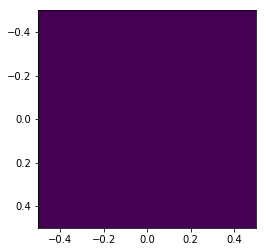


Filtro Corrente: 
 [[[-0.01691337  0.00799306 -0.02711909 -0.01393037  0.00476269
   -0.01778399 -0.01130972  0.02987731 -0.00382887  0.01299235
    0.03767493 -0.00914423  0.00067899  0.02324159 -0.02292201
   -0.01281435]
  [ 0.03604869  0.01428511  0.00471007 -0.03091675  0.05649255
   -0.01371842 -0.00020955 -0.03159645 -0.03328525  0.01671868
   -0.03226551  0.00924858 -0.00243952  0.00574918  0.01511855
    0.04181877]
  [ 0.00536297  0.0458576   0.0217243   0.07544726 -0.0305855
   -0.02239118  0.00741823  0.01581835  0.02390482 -0.0218903
   -0.03739622  0.02529866 -0.06294287 -0.06120968  0.08061994
    0.01882508]
  [-0.02036554 -0.00250313  0.03188043  0.00391811  0.03322438
    0.03813068 -0.00498685  0.01941292 -0.01096645 -0.01996162
   -0.01153565  0.05914123 -0.01346054 -0.03901571 -0.00657727
    0.04643897]
  [-0.03301401 -0.01213692  0.00655875  0.01779163  0.02123738
   -0.02950025  0.05284191 -0.00370621 -0.02398212 -0.03208107
   -0.01650902  0.04023034  0.022083

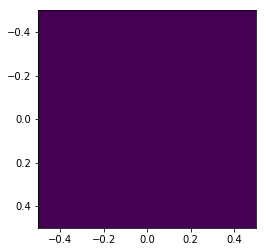


Filtro Corrente: 
 [[[ 3.13501467e-02 -1.60406181e-02  3.31772572e-02  3.02312126e-02
   -5.19355507e-02  1.76396223e-02 -2.75399650e-03  2.17983754e-04
    1.07304077e-02 -2.09641443e-02  1.44569449e-02  6.09878400e-02
    3.87866072e-02 -3.53966764e-02 -5.74295487e-02  4.23148519e-02]
  [-2.06933681e-02  3.28573613e-03 -1.73693572e-02 -7.66710957e-03
   -2.69565738e-02 -6.55492298e-02 -6.52601827e-02  3.23843311e-02
   -3.09674921e-02  1.74447097e-02  2.42585986e-02  2.25778307e-02
    4.49749134e-03  1.72529568e-02 -3.93152889e-02 -2.38735843e-02]
  [ 4.74540128e-02 -3.68507733e-03 -1.83303511e-02 -1.01639790e-02
   -2.31799691e-02  2.95915044e-02  4.06682390e-02  1.60315070e-02
   -7.71419961e-03 -8.33179922e-03 -1.87756507e-02  8.28632120e-03
    1.25560154e-02 -1.18181633e-01 -4.30265120e-03  4.42681128e-03]
  [ 4.47822243e-02  1.90100799e-02 -2.86704553e-02  2.96437478e-02
   -4.41921517e-02 -1.42832095e-02  3.16530151e-02  2.85615922e-02
   -5.67672615e-02 -2.11569374e-02 -4.4

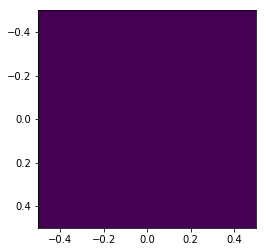


Filtro Corrente: 
 [[[ 2.27674581e-03 -5.12455088e-02  1.16595472e-02  3.81024256e-02
   -1.92001576e-02  1.75672635e-03  1.46111736e-03  3.30863345e-02
    2.40828931e-02  2.31312052e-02 -1.35624849e-02 -2.40968127e-03
    6.24995803e-02  1.77009764e-02 -2.80471501e-02  1.53974993e-02]
  [ 2.48175368e-02 -8.24816792e-02  5.19712427e-02  8.73265030e-03
    5.37528885e-02 -5.17336443e-03  3.54593000e-02 -8.63673689e-02
    4.17242180e-02  4.24526458e-02  1.37852794e-02 -1.81904109e-02
   -1.24536620e-02  2.16536229e-02 -1.95283033e-02  6.04832711e-03]
  [-1.18321556e-02  3.78818818e-02 -1.37497628e-02  8.88355390e-03
   -2.36512022e-02  2.86684304e-02 -1.48190051e-02 -5.55065216e-02
   -4.86779041e-03  3.74119683e-02 -3.04278841e-02  2.55061645e-02
    4.20767062e-02  3.20240786e-02  1.37798639e-02  1.91580401e-02]
  [ 5.50909549e-02 -4.56689811e-02  2.79481758e-02 -3.44017171e-02
   -2.06971791e-02 -3.65913612e-02 -8.35749806e-03 -3.80649095e-02
    1.69959419e-02 -6.90331441e-02 -2.1

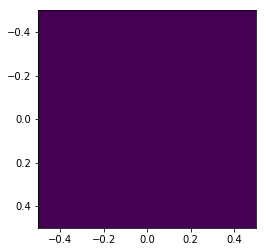


Filtro Corrente: 
 [[[-4.87602718e-02 -1.89736316e-02 -2.92996424e-02 -1.36099247e-02
    4.48230437e-02 -2.71568937e-03 -1.17270232e-02 -2.47516585e-03
   -2.77165244e-02 -4.22150802e-02 -2.51228935e-02 -1.78983328e-03
    4.53554376e-02 -8.13811297e-02  2.19385220e-02 -3.06579983e-02]
  [-3.85714206e-03 -2.40160371e-03  2.61856521e-02 -5.02959688e-02
    2.51392263e-02 -1.57665900e-02  6.13283075e-02 -4.08602902e-04
   -7.15793813e-02  2.76245872e-03 -1.39070077e-02 -1.13148434e-03
   -1.45428028e-02 -1.31016289e-02  2.47969506e-02  3.03123837e-02]
  [-1.16252211e-02  3.51886322e-03  5.88950235e-02  1.52340658e-02
    9.62648881e-03 -1.45674481e-02  3.41897026e-03 -1.13440617e-02
    1.04687189e-02 -1.13652363e-02  3.22361415e-02  4.27707270e-02
    3.02254929e-02  5.99291879e-02 -3.75246583e-02  1.89275492e-02]
  [ 6.07262925e-02  1.21539974e-01 -3.17782920e-02  1.68601779e-04
   -3.99914144e-02 -2.61446812e-02  1.80459981e-03 -4.44341675e-02
   -2.04630699e-02  4.74574208e-02 -7.1

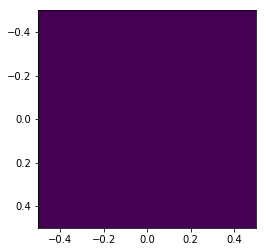


Filtro Corrente: 
 [[[-0.05101177  0.08565099 -0.01263175  0.02085866 -0.04140123
   -0.0171368   0.02487378  0.01314599 -0.04323159  0.01670316
    0.02708356  0.03829543  0.00682081  0.01085231  0.01531766
    0.01502158]
  [-0.0257303   0.00475715  0.04849754 -0.0209175   0.03581722
   -0.03475425 -0.00199267 -0.01064023 -0.0044479  -0.05082585
   -0.05359622 -0.02358241 -0.01862871 -0.01997538  0.03773056
    0.0144105 ]
  [ 0.00636674  0.02607932 -0.00311404  0.02615723 -0.03815685
    0.04022791  0.04899223 -0.07619768  0.05509368 -0.07853806
    0.00727896  0.03689879  0.02730565  0.03915114 -0.02001229
   -0.00149038]
  [ 0.0186597  -0.03553824 -0.05917396 -0.02424033 -0.04005217
    0.02480876  0.06217665  0.06918213  0.01053459  0.0425025
    0.0603636   0.04464041  0.05195255 -0.04257818 -0.03362503
   -0.00924868]
  [-0.01949115  0.01567084 -0.02716787  0.00026326 -0.00611977
   -0.01655836 -0.0358133  -0.03673963  0.06832588 -0.02182736
    0.01332847  0.02727295  0.04040

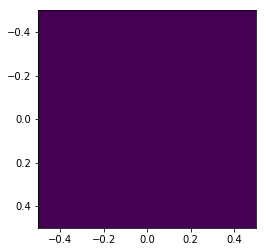


Filtro Corrente: 
 [[[ 0.0621682  -0.00788613 -0.04869838  0.06626521  0.00742263
    0.02464938  0.02617076  0.0049418   0.01866527  0.02709705
    0.04330115 -0.00525306  0.00916942  0.01519984 -0.03819106
   -0.05913291]
  [ 0.02706075  0.03071445  0.0312104   0.02761258  0.03247895
   -0.07231453  0.01096562 -0.01219317 -0.03922875  0.05048831
   -0.00802094 -0.04688168 -0.04165619  0.01431264  0.05371436
    0.05558736]
  [-0.03249491 -0.0241258   0.04714718 -0.02573524  0.04768495
   -0.11786112  0.0049038   0.01798379  0.02204343  0.02140122
    0.01221652  0.01795536 -0.06338203  0.02698913 -0.01111827
    0.00361728]
  [-0.03288212 -0.03856666 -0.00236587  0.00526972  0.01019584
   -0.03208552  0.08051172 -0.02403788  0.00709935 -0.00856931
    0.00180553  0.01131293  0.0229785  -0.05730923 -0.01746176
   -0.00187587]
  [ 0.0128082   0.0138158   0.02004146  0.00405282  0.0152409
    0.00742323 -0.03825539  0.00297392  0.02138944 -0.04331918
    0.00533755 -0.04052453 -0.02928

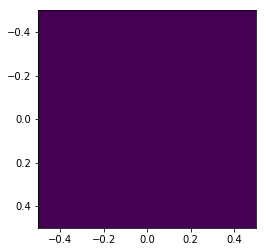


Filtro Corrente: 
 [[[ 0.03239038 -0.02661098  0.00939741 -0.02036294  0.06171892
    0.0114051   0.05456439 -0.06935856 -0.01739895  0.00864924
    0.00211594  0.00269696 -0.0221145  -0.01564467 -0.02418841
   -0.0518147 ]
  [-0.00025021  0.08235168  0.01063018  0.03111972 -0.01271073
    0.00547481  0.04563394 -0.06641589 -0.02314914  0.01300955
   -0.07096002  0.02039788  0.07012961 -0.01145172 -0.00152095
    0.03519074]
  [ 0.02760595 -0.02489776 -0.02393371  0.08397804  0.03713024
    0.01075086 -0.01614966  0.0011482   0.03072314 -0.01386044
    0.03304816 -0.01704412 -0.03517624 -0.02168082 -0.01296211
   -0.00088057]
  [-0.02007099 -0.02008949  0.0217062  -0.01087811  0.01767971
   -0.01623392  0.00811135 -0.01507068 -0.04213341  0.00439235
   -0.03447626  0.02321117 -0.02407753  0.02700337 -0.0087124
   -0.0369394 ]
  [ 0.0327731  -0.03327424  0.00418703 -0.00221877 -0.02677763
    0.0274656   0.04851149  0.01527595  0.01152801  0.02650588
    0.00657699 -0.04672331 -0.00507

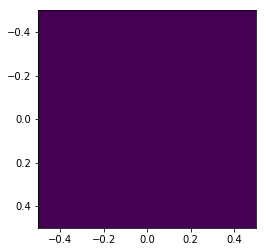


Filtro Corrente: 
 [[[-6.29771377e-02  5.67255023e-03 -2.54913025e-02  5.02012721e-02
    5.48450070e-02  3.60643808e-02 -3.63727282e-02  1.21945899e-02
   -2.19518710e-03  2.31709445e-02 -6.72560312e-02  1.32713520e-02
   -1.33902025e-02  2.79840567e-02  1.33092270e-02 -6.63038896e-03]
  [ 5.46642466e-02 -7.10580252e-03 -3.58310054e-02 -7.59772099e-03
   -1.52836230e-02  7.30485585e-03  4.48627237e-02 -4.31408166e-02
   -4.04368260e-03 -3.57966815e-02  7.06556756e-02  2.22964935e-02
   -6.58703867e-02 -5.01599121e-02 -4.74592492e-02 -4.14049485e-02]
  [ 2.88520319e-03 -6.83483322e-03  3.86973746e-02 -1.47920489e-02
   -3.78849003e-02  1.59220318e-02 -5.81445342e-02  8.32618003e-03
    6.73696845e-02  3.30959421e-02 -1.09010313e-02  6.14756474e-02
    2.51481698e-02 -4.03902486e-02  6.14555143e-02 -8.98670500e-04]
  [ 1.09353153e-02 -3.96281756e-02  2.01933665e-02 -6.63518048e-02
    5.97986360e-02  4.28904603e-02  7.38048045e-03  9.38938480e-03
   -2.49271065e-02  4.27071455e-03  4.3

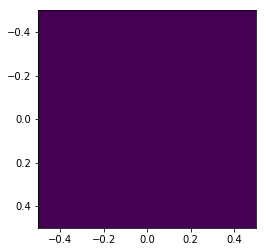


Filtro Corrente: 
 [[[-1.44316239e-02 -2.44281807e-03  4.15043476e-02  6.19695819e-02
   -1.02573133e-02 -1.70120598e-02  3.71413358e-02  4.66200218e-02
   -2.59710127e-02  2.15647625e-02 -5.10947413e-02  4.76022219e-02
    2.22954829e-02 -2.42428126e-02  4.18993384e-02  8.05387572e-02]
  [-5.95844085e-02  4.24818334e-02  2.80980770e-02 -4.19610514e-02
    3.07419166e-02 -1.31794926e-02  4.85721250e-02  7.70500883e-02
   -3.04630750e-02 -7.32338092e-02 -3.34403528e-02  3.87407747e-02
   -1.51189107e-02  2.69627049e-04 -4.33168703e-02 -2.35554914e-02]
  [ 5.57204249e-03  9.70517290e-03  7.77489701e-02  5.58879978e-02
    2.07365443e-02  7.79781237e-03  3.86140159e-02 -4.65509845e-02
    8.96367109e-02  1.75320996e-02 -3.54442066e-02  1.36649582e-02
   -2.54656892e-02  1.83649186e-03  9.82542376e-03  4.37605199e-03]
  [-6.54569285e-02 -4.93712108e-03  2.45017720e-02  3.93454492e-02
    9.57262066e-03  2.10132543e-02 -1.49145558e-03  1.50457109e-03
   -7.59928546e-02  1.19289037e-03 -1.7

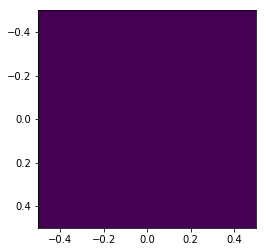


Filtro Corrente: 
 [[[-1.87808643e-02 -1.49633841e-02  1.69027966e-03  1.83178586e-02
   -2.54884021e-03 -6.48997170e-02  3.37969202e-03 -3.93449292e-03
    4.57361245e-02  2.70172886e-02  1.55212041e-02 -1.00076101e-02
   -1.11848909e-03 -6.20280335e-02  2.10923738e-02  6.55519896e-02]
  [-7.88497982e-02  4.15087297e-02 -2.49666420e-02 -1.84749998e-03
   -2.68310391e-02  1.62247023e-02 -2.75210939e-03 -3.07115254e-02
    5.62842796e-02  2.89146198e-03  2.48500620e-02  1.43452587e-02
    1.75594304e-02 -6.35561444e-05  1.49561129e-02  2.58789840e-02]
  [ 3.31556556e-03 -4.20589792e-03 -4.35159160e-03  2.83053075e-02
    6.37636532e-03  3.79601759e-02  1.87692907e-02 -3.30543035e-02
   -8.94399851e-03  1.75212783e-02 -1.95966474e-02  3.93056374e-02
   -2.46840230e-02 -3.51344581e-03  2.87366376e-02  1.64032365e-02]
  [-1.40790028e-02  4.17886363e-02  4.52060094e-02  6.67879254e-02
   -1.75055513e-02  8.30702322e-03 -2.97477481e-02 -1.36113883e-03
    1.05464982e-02 -4.86593474e-02 -5.8

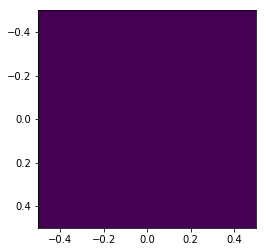


Filtro Corrente: 
 [[[ 3.61294110e-02 -5.04841066e-02  1.61224030e-02 -1.46099141e-02
    3.25372841e-04  3.63178179e-03  4.16545076e-03 -4.00516565e-02
    9.74204781e-03 -6.48515177e-02  2.28007302e-02 -3.60792575e-02
    1.21319351e-02  7.63223616e-02  4.71143359e-02 -4.00495073e-03]
  [ 1.69509707e-02 -2.28529672e-02  7.77093785e-03 -7.47941193e-02
    3.56326613e-02  1.59080486e-02  2.69135841e-02 -7.50040871e-03
    5.50913889e-02 -3.01543365e-02 -2.48059624e-02  1.46364612e-02
   -6.25762075e-02  6.54436757e-02  2.31557802e-02  4.88647972e-02]
  [ 3.74316109e-02  1.84331300e-02  7.62377322e-03  6.35389449e-02
   -4.05782335e-03  8.72494568e-03 -3.34740120e-02 -4.71941876e-03
   -1.06777336e-02  5.77459397e-03 -7.93526613e-03 -6.21873391e-03
    6.19042029e-02 -1.80519521e-02 -3.05991851e-03  1.71167037e-02]
  [-1.87847196e-02 -6.43041235e-02  2.12018744e-02 -1.38293725e-02
    5.67226263e-02 -5.95224621e-02  2.09702946e-02 -7.60660612e-03
    4.77775475e-02 -3.85353919e-02  6.2

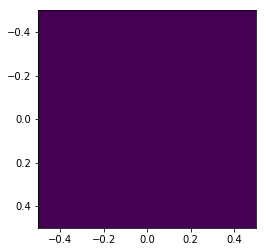


Filtro Corrente: 
 [[[-2.02109529e-02 -4.35543660e-02  2.73122562e-02  7.28313513e-03
   -4.58854200e-02  4.87407839e-02 -2.96812094e-02 -3.59712406e-02
   -2.33653513e-02 -8.36161681e-03 -2.75326766e-03 -7.43729266e-03
   -9.75561895e-04  5.32152254e-02 -3.65553591e-02  7.15701672e-02]
  [-1.85204092e-03  2.26220320e-02  8.97143602e-03  5.70017300e-02
    2.53815224e-02 -3.71569234e-02  1.19947905e-02 -2.23875685e-02
    3.53236877e-02  3.41660721e-02  4.56917659e-02  3.67345468e-02
    9.53692138e-02 -7.01718930e-03  2.13395640e-02 -6.95142107e-03]
  [-9.10753220e-03 -5.53128725e-02 -3.68816504e-03  2.51851908e-02
   -1.81691832e-02  4.94480092e-02 -7.07471163e-03  5.59789063e-02
   -3.44657731e-03  6.91454602e-02 -8.00536275e-03  3.06101461e-02
    1.17612414e-02 -1.12743504e-02  1.21277384e-02  3.51225241e-02]
  [-2.12778652e-02  4.92577236e-02  4.61794070e-02 -6.55783812e-03
    2.27522685e-02  3.93232829e-02 -4.08558105e-02  2.39766746e-02
   -1.20582590e-02 -2.64440633e-03  3.2

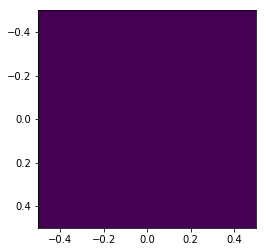


Filtro Corrente: 
 [[[-3.63505312e-02  1.31898337e-02 -1.16525454e-02 -2.96590169e-02
    4.59567112e-02  6.76782115e-03 -5.84294299e-02  5.66933854e-02
   -2.49192945e-03  2.67484136e-02  2.08632452e-02  1.24893126e-02
   -5.28743262e-02 -5.66671080e-03  3.70133061e-03  4.61690166e-03]
  [ 3.81618064e-03  6.25241897e-02 -1.76273894e-02  1.93685253e-02
    6.06444504e-02 -5.68989668e-03 -6.63049124e-02  7.25216679e-03
   -3.52041259e-02  1.62954763e-02 -3.65837912e-02  2.20982613e-02
   -1.09759560e-02  1.45153233e-02 -6.57303630e-02 -9.69373905e-03]
  [-3.88128775e-02  5.84391959e-02 -1.89338669e-02 -2.28513046e-02
   -2.61589888e-02  3.52590843e-03  1.03241433e-02  3.12080185e-02
    1.29297279e-02  1.82167048e-02 -1.55244929e-02  6.15638123e-02
   -3.03051713e-02  2.57043343e-02  7.87432775e-03 -4.16019204e-03]
  [ 3.01344243e-02 -1.36834308e-02 -1.02648606e-02  3.00726551e-02
    1.84675273e-03  4.89132178e-03  8.56160569e-03 -1.34245425e-02
   -1.76106182e-02  3.96315214e-02  7.4

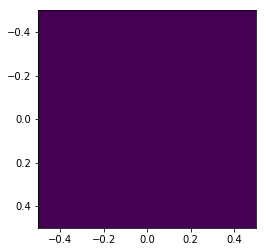


Filtro Corrente: 
 [[[ 1.95664087e-02 -4.30779062e-02  3.46149449e-03  7.85256891e-02
   -3.15622787e-02 -4.94032553e-03  1.31371813e-02  3.21111140e-02
   -4.21595653e-02  4.88596610e-02  6.42602502e-02 -4.65309665e-02
    3.18801370e-02  3.26493858e-03 -6.16481802e-03  3.20208645e-02]
  [ 2.72055818e-02 -1.72560858e-02 -4.30953553e-02 -4.91778374e-02
   -1.55285068e-02  7.59981776e-02  1.60286568e-02  1.30402944e-02
    7.12371574e-02  6.83517712e-02 -2.23417020e-02  2.83423473e-02
   -1.48664666e-02 -3.24427827e-02  2.14350054e-03 -4.44127619e-02]
  [ 2.25138032e-02 -3.99846979e-03  1.68322284e-02 -3.86255390e-02
    2.74632972e-02  1.29715964e-02 -2.88460538e-02 -2.95140129e-02
   -3.41126210e-02 -7.40499486e-03 -2.11673332e-02  2.92760193e-02
   -6.35725920e-02 -4.83858635e-02  7.85826002e-03  2.50480145e-02]
  [-1.57786931e-02  2.78531730e-02  8.50700853e-03  1.72765925e-02
   -4.91870660e-02 -7.53944088e-02  5.80129634e-02  2.32130207e-02
   -1.07350113e-02  5.60884483e-02  2.0

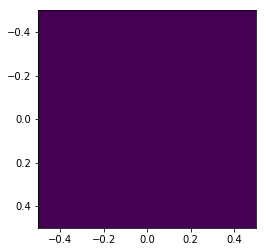


Filtro Corrente: 
 [[[ 3.34361575e-02  2.19976648e-02 -5.95201565e-02  3.78108874e-02
   -4.01558506e-02  6.43195522e-03  8.02926079e-04  9.10109630e-03
   -3.83250434e-02 -1.76330185e-02  2.86606793e-02  7.20575014e-03
   -2.18926587e-02 -1.71215682e-02 -4.36091027e-02  4.26388803e-02]
  [-4.77661359e-02  1.91266644e-02 -2.43168363e-02  4.32348128e-02
   -1.18884060e-01  1.70113941e-02 -2.73969725e-02 -1.26888566e-02
    8.80790573e-03 -1.98145546e-02 -3.79722620e-03  2.48706193e-03
    1.42763610e-02 -4.98726581e-02 -1.45912821e-02  3.57033694e-02]
  [-4.69251169e-02  1.53813580e-02  2.43180806e-02 -1.72621707e-02
   -8.12428970e-03 -6.99283954e-02  3.76009706e-04 -6.46785584e-02
    3.41773079e-02 -5.11731726e-02  6.20468314e-03  2.07278313e-02
    3.62801811e-02 -2.77680212e-02 -1.35774896e-02  2.92141718e-04]
  [ 3.45483905e-02  2.00041179e-02  1.98853009e-02  1.01836115e-02
   -1.71189215e-02  9.43951143e-02  3.40690595e-02  1.74356958e-02
   -6.44335319e-02  2.18277571e-02 -7.5

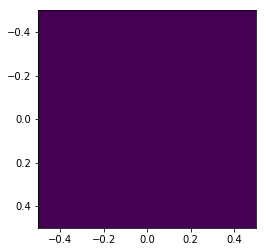


Filtro Corrente: 
 [[[ 1.28403236e-02 -1.85038852e-02 -2.02644156e-03 -7.03472021e-03
    1.04378761e-02 -1.64776150e-02 -2.02600293e-03  2.00099187e-02
    2.29408094e-02 -5.12848850e-03  6.63985627e-02 -3.38503529e-02
    1.75051055e-02 -1.60865590e-02 -2.41335695e-02 -2.35515641e-02]
  [-7.38819372e-03  3.19184851e-02  1.03892986e-02 -4.32697622e-02
   -3.06312834e-02  4.05223112e-02  2.80306672e-02  7.65165387e-03
   -3.50643034e-02 -3.59170679e-02 -4.99373334e-02  5.16054229e-02
    2.32257396e-02 -4.51183985e-02  3.09288247e-02  5.69606094e-03]
  [ 6.16842950e-02 -3.17675499e-02 -1.99773705e-02 -4.31006856e-02
    9.71462175e-03  2.42598524e-02 -4.54525191e-02 -1.61555791e-03
   -1.61372888e-02 -6.28168371e-03  7.72378559e-02 -4.04980443e-02
   -3.01964252e-02 -1.31389311e-02 -2.13048858e-02 -1.26773565e-03]
  [ 2.77520608e-02 -3.81821403e-02  1.19623387e-02 -4.77045746e-02
   -2.23794404e-02  1.07200416e-02  5.33320163e-02  2.34532739e-02
   -4.14500658e-02  4.60637129e-02 -4.6

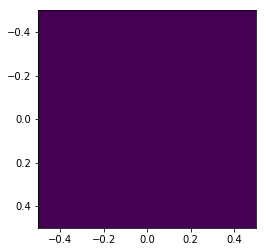


Filtro Corrente: 
 [[[ 0.03255149 -0.00744493  0.01440283 -0.0641047  -0.01469393
    0.06782648 -0.03705462  0.03092693  0.02092164 -0.02979989
    0.03090095 -0.00376918 -0.01093962  0.04573407 -0.00760019
   -0.01211147]
  [ 0.00660333  0.01950676 -0.04475463  0.00998603  0.00321532
   -0.02273955 -0.04106722 -0.0134665  -0.00425291  0.01085551
    0.0348675  -0.01706163 -0.04645304  0.03043485  0.02172377
    0.04184557]
  [-0.01624949  0.00232323 -0.02527334  0.08897063  0.006183
   -0.00588919  0.01378829  0.01011105 -0.00469782  0.02218989
   -0.00451575  0.03400587 -0.04770805  0.0513616   0.03176823
    0.02699265]
  [ 0.00565079 -0.02353887  0.0614134  -0.05132054  0.03359951
   -0.017449    0.01595432 -0.0169267   0.0847514  -0.06993895
    0.04840506  0.0152356  -0.01843786 -0.00151095 -0.05837028
    0.01230836]
  [-0.02694698  0.02016339 -0.03504052 -0.00750312 -0.06846691
   -0.02516807 -0.0526488  -0.02806614  0.04293268  0.03965599
    0.05959636 -0.00282986  0.012037

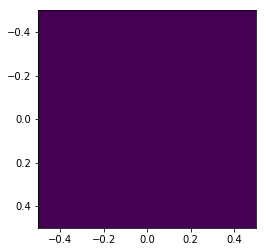


Filtro Corrente: 
 [[[ 0.04030523 -0.03899538 -0.02149033 -0.00711048 -0.0412774
    0.00050476 -0.03679715  0.03720147 -0.0059628  -0.05661404
   -0.01982868  0.06090511  0.02746781 -0.02121236  0.00058314
   -0.0335262 ]
  [ 0.06343096  0.05507469 -0.03618106 -0.00624863 -0.03374482
   -0.04599579  0.01796202  0.05332287  0.02634342 -0.04149925
   -0.03510297 -0.00981259 -0.04236853 -0.01424177  0.03409037
    0.01363282]
  [-0.02430226  0.01359187  0.00119445  0.02507655  0.00362808
    0.01790631  0.01644543  0.0032004   0.0328432  -0.05459091
    0.02955852 -0.01119619  0.00366263 -0.01028545  0.00776788
    0.02272944]
  [-0.00083759  0.03002423 -0.01748763  0.02554569  0.0042806
    0.03691626 -0.04854583  0.02120642 -0.03286676 -0.02645
   -0.04327393  0.02972789 -0.02077642 -0.05362713  0.0016466
    0.03988977]
  [ 0.0143714   0.00799141  0.00639623 -0.02180033  0.06005927
   -0.01481748 -0.00389322 -0.05668496  0.02714001 -0.02547904
    0.00864987 -0.00752628  0.01279202  

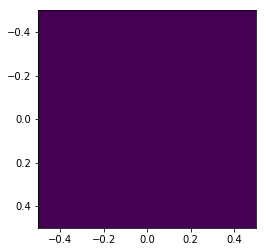


Filtro Corrente: 
 [[[ 3.19565623e-02  2.44502802e-02  4.20938917e-02 -2.00068873e-02
    1.24906714e-02 -1.16963941e-02 -1.97692290e-03 -4.36355565e-02
    1.74474236e-02  1.14755837e-03  3.76022447e-03 -5.08940209e-02
    2.34026507e-02 -3.65806006e-02  2.74105452e-02  4.36200965e-02]
  [-1.14539145e-02  1.24521822e-02 -1.81640276e-02  1.27080182e-02
   -1.59620781e-02  6.55390378e-03  2.54924485e-03 -8.14868819e-03
    3.92112109e-02 -2.85849098e-02  1.46353905e-02  6.18089360e-05
    6.52958289e-02  1.57334040e-03 -3.78074977e-02  6.43350736e-02]
  [-7.15822027e-02  1.77570712e-02  1.07246024e-04 -4.22228816e-02
    2.41311796e-02 -3.12089820e-02  8.00970020e-03 -8.35275073e-03
    4.83821751e-02  1.17893940e-02  3.08933152e-02 -1.25498310e-02
    2.42997823e-02  4.07319209e-02 -4.48574813e-02 -6.46502823e-02]
  [-9.56356025e-03  6.89549807e-04 -2.86974754e-02  1.86458446e-02
   -4.73170705e-02  2.44266040e-02 -6.88858817e-03  2.14904778e-02
   -2.57767439e-02 -1.16779758e-02  4.4

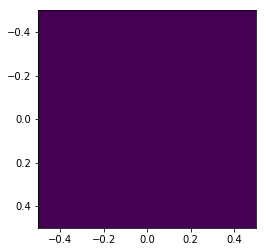


Filtro Corrente: 
 [[[-1.46573588e-02  5.27474592e-02  2.29710706e-02 -9.28851844e-03
    1.98382861e-02  3.56926170e-02 -1.64038333e-02  2.25331726e-02
   -1.65601611e-02  1.63177854e-02  5.64010012e-02 -2.93848008e-02
   -1.60360121e-02  8.40510319e-02  2.88272637e-02 -5.08353824e-02]
  [ 1.10679809e-02 -9.72652237e-03  1.78261494e-02  2.30648679e-02
    1.66163263e-03  3.87900649e-05 -1.70269923e-02 -1.51297415e-03
    4.31808900e-02  2.32722358e-02  4.60086824e-02 -1.45469805e-02
    3.53110543e-02  7.29977764e-02 -3.80347617e-02 -3.14618304e-02]
  [-2.90098716e-02  5.26106259e-02  4.18440727e-02  2.00762478e-02
    2.50729068e-02  4.85949088e-02  2.20655864e-03 -5.39346015e-02
   -6.44710889e-02  2.90295947e-02 -1.07386909e-03 -2.13099349e-02
    3.05936102e-02 -7.18585892e-02 -1.89898716e-02  3.75368429e-02]
  [-2.34307684e-02  1.51368666e-02  1.64422311e-02  1.19897778e-04
    2.17203680e-02  3.48675355e-02  5.09941779e-02  3.85716708e-02
   -2.61790062e-02  2.55440131e-02  2.5

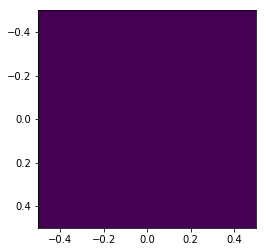


Filtro Corrente: 
 [[[ 1.11684442e-02 -1.69675711e-02 -5.74175763e-03 -4.60992394e-02
    7.10908661e-03  7.40432020e-02  3.08465581e-02  3.97605056e-02
    4.55088763e-02 -8.47658401e-03  2.52572755e-03  2.64218096e-02
   -3.22855352e-02 -1.61846954e-02 -7.54586696e-02 -1.02481550e-02]
  [-1.59857270e-02  4.45920188e-02  5.24604346e-02  4.68551828e-02
    4.23237207e-02  8.86013132e-02  4.29987334e-02 -9.86109210e-03
    9.06339148e-03 -2.41136507e-02  1.84295744e-02  1.27070358e-02
    1.38742937e-04  3.77808312e-02 -1.01909485e-02 -2.44532272e-02]
  [ 4.60784381e-02 -3.38970646e-02 -1.28994650e-02  3.15077257e-02
   -4.03275709e-02 -2.28349713e-02 -3.06560101e-02  1.04236392e-02
    1.14001926e-02  4.47921128e-02 -1.99108374e-02  4.89314224e-02
   -1.35060698e-02 -6.95846184e-03  1.96608317e-02 -7.92344433e-02]
  [ 3.73958496e-02 -4.90822354e-02 -1.34845594e-02  1.78784586e-03
   -4.49848049e-02 -9.77072959e-02  3.82887368e-02  5.84407101e-02
    1.49082955e-02  1.42001534e-02 -1.2

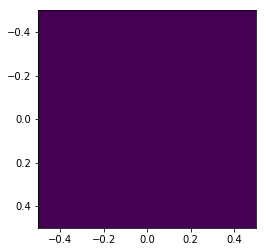


Filtro Corrente: 
 [[[ 3.12310807e-02  8.28970856e-03  1.43592277e-02 -3.93519166e-03
    8.64634617e-02  2.29226684e-02 -1.58489228e-02 -8.57136679e-03
   -3.17952044e-02 -1.78028778e-02  1.87339516e-03 -1.95152110e-02
    2.19731343e-02  2.46299740e-02  8.54230402e-03 -4.01687345e-02]
  [ 3.29262298e-02  3.11684906e-03  5.05930502e-02 -9.24737835e-03
    2.85726899e-02 -4.97057183e-02 -8.26358669e-03  1.53930047e-02
   -3.53175573e-02 -5.77752530e-03  5.50685084e-02  5.74960312e-04
   -2.39056188e-03  1.42993044e-02  1.74222167e-02  4.58744060e-03]
  [-5.28857064e-02  5.94210145e-04 -1.07522002e-02  5.43128936e-02
   -6.83580545e-03 -7.27136557e-03  2.41150752e-02 -3.72985657e-02
    4.14710810e-02  4.77720148e-02  3.17677525e-02  2.89030098e-03
    7.80217880e-02 -2.89091816e-02  4.12860302e-02 -6.92610660e-02]
  [-7.53327280e-03  8.72716823e-03  3.64504706e-03  2.64343934e-02
   -3.66472509e-02  3.92877496e-02  3.22411015e-02  7.15210535e-02
   -1.91145749e-02  4.32867047e-03  3.4

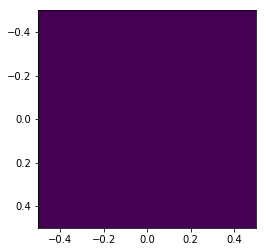


Filtro Corrente: 
 [[[ 0.03431635  0.03227831  0.00441398  0.05686917  0.03198947
   -0.02871805 -0.02685452  0.02463944  0.02117816 -0.01439861
   -0.02882408  0.0002557   0.00812078  0.07181406 -0.01826615
   -0.00091775]
  [ 0.02958511  0.02886893  0.02632416  0.03309496  0.02082061
    0.03585425  0.02851215 -0.01393051 -0.04804271  0.0054279
    0.02688213 -0.02759994  0.0278453   0.01904038  0.0390943
   -0.0128675 ]
  [ 0.02176605  0.03113381 -0.02167002 -0.02515202 -0.02211394
   -0.00139396 -0.01027847 -0.00577529  0.00334002 -0.02278156
   -0.05295386 -0.02064179  0.02617224  0.00982347 -0.01286557
   -0.01932439]
  [-0.01306151  0.00916539 -0.03111119 -0.02207347 -0.02006173
    0.00359532  0.00175558  0.0314653  -0.02308092  0.0550648
    0.00256946 -0.005682   -0.00853703  0.00806361  0.0450135
    0.0242194 ]
  [ 0.03613017  0.0394325  -0.00117859  0.01706257 -0.03150951
   -0.025684   -0.01268796  0.01693132  0.01466165 -0.07452912
    0.01654598  0.01620709 -0.04639085

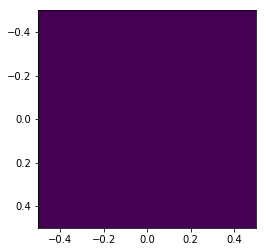


Filtro Corrente: 
 [[[ 2.10007798e-02  3.53119710e-02  1.27146532e-02 -8.40784333e-02
   -4.63246870e-02  4.65965812e-02  4.91258447e-02 -3.35230219e-03
    8.70099639e-03  4.23800304e-02 -1.24738411e-02 -2.29041335e-04
   -2.62294644e-02  1.92494606e-03 -1.37711876e-02 -5.41100945e-02]
  [ 4.65840302e-02  3.47083708e-03 -6.05115943e-02 -5.32472028e-03
   -2.09540943e-02 -2.81150677e-02  4.94898400e-03 -4.30605735e-02
   -2.27324913e-02  2.53648499e-03  4.91302941e-02  4.74108256e-02
    3.25812932e-02  1.93450889e-02  1.96846675e-02 -9.71014527e-02]
  [-8.42626719e-02  2.51096525e-02  1.31735504e-02  5.98403789e-03
    6.50101697e-03  3.30297549e-02  9.33155799e-03 -6.00639285e-02
   -2.58777588e-02  2.36354075e-02 -2.70201348e-02  2.01680579e-03
    3.44243540e-03  2.06208275e-02  1.89270457e-02  6.88063757e-02]
  [ 3.48322572e-02  2.03839945e-02  2.66293285e-02  4.40060733e-02
    1.04269281e-02  1.70417073e-02  8.64989228e-03 -2.30914239e-02
   -1.79841998e-02 -1.74124452e-02 -5.6

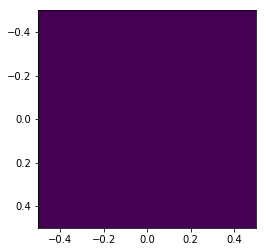


Filtro Corrente: 
 [[[ 7.05349270e-04  6.69722797e-03 -2.75805823e-02 -3.27731027e-02
    1.64662230e-02 -2.41565741e-03 -7.03164186e-03 -1.93931562e-02
    2.10361197e-03 -5.65043637e-02  1.53846778e-02 -2.97824558e-02
   -2.75452543e-03 -5.18741465e-02  1.31263994e-02  8.45790123e-04]
  [-5.18392488e-02  4.78821632e-02 -1.34395683e-02  9.35112262e-02
    2.47234997e-02 -4.65426319e-02 -4.16146462e-04 -2.44968001e-02
   -2.31411655e-02 -8.62749023e-03  3.09571299e-02  4.22011030e-02
    4.10533040e-02  6.51397621e-03  3.08769213e-02 -3.66155640e-02]
  [-4.64994684e-02 -1.71155395e-02 -3.07180942e-03 -1.57046232e-02
   -5.07765577e-02  2.17447717e-02 -2.70319224e-02  4.52180338e-02
    6.45029988e-02  2.42760385e-03 -5.60785492e-03 -1.06716652e-02
    2.79654863e-02  6.30221447e-03  8.66114279e-02  2.01971780e-02]
  [ 3.08675109e-02  1.68910157e-02 -3.49977122e-02  6.30930236e-03
   -4.67949650e-02  7.47403754e-02  2.25968610e-02  2.51590820e-02
   -4.22512528e-02 -3.36119321e-02  1.8

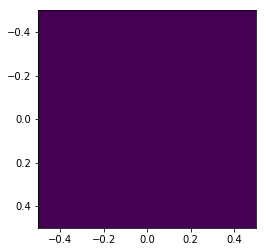


Filtro Corrente: 
 [[[ 0.03507239 -0.01705232 -0.05682045 -0.02209181 -0.0020458
   -0.06070235 -0.03768802  0.09496184 -0.04255814 -0.00152946
    0.0577164   0.01779408  0.01291309  0.03217318  0.019202
   -0.03758883]
  [-0.05134227 -0.00392142 -0.01921288 -0.01282737 -0.01138775
   -0.00033377 -0.02634238 -0.0029233   0.04070787 -0.00691478
    0.02899612  0.01297366  0.02685666 -0.05909946 -0.0325405
   -0.02021743]
  [ 0.01308911  0.02360394  0.01354069 -0.0333833   0.0650026
    0.01732059  0.01493474 -0.0171351   0.04029116 -0.00286159
   -0.00017701 -0.04814627  0.02344194 -0.02379254  0.03962843
   -0.00496049]
  [ 0.01765312  0.00536465 -0.00694974  0.00473483 -0.02068294
    0.04876284 -0.03593419 -0.02161813 -0.03846628 -0.00485664
    0.02890374  0.0161841  -0.01858006  0.02756179 -0.01068518
    0.03760038]
  [-0.01396253  0.00660898  0.04109473 -0.04832854  0.00019322
    0.00747503  0.03368161 -0.04054786  0.0319532  -0.01202552
   -0.00881916 -0.04927495 -0.04300806 

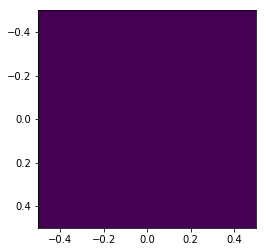


Filtro Corrente: 
 [[[ 0.03631439  0.03214124 -0.02578428 -0.00882637  0.0238351
    0.07257349  0.02468767 -0.00505463 -0.02339914  0.01823706
    0.00470224 -0.01737471  0.02307221  0.01099389 -0.01764183
   -0.11307196]
  [ 0.04827115 -0.01527089  0.00764976 -0.00316149  0.00713008
   -0.04568381  0.02193911 -0.02292691  0.00663013 -0.02904503
    0.00415564  0.00453585  0.06507741  0.01454506 -0.04275814
    0.01192538]
  [ 0.02481563 -0.06473526 -0.01993657 -0.06694212  0.03660509
    0.04439137 -0.00973074 -0.01820008 -0.04784678 -0.00922984
    0.01983752 -0.01223885  0.05696039  0.03553086  0.01188629
   -0.05418976]
  [-0.01099219  0.01255565 -0.02085627 -0.02843188 -0.00208304
    0.01855632  0.03401624  0.02060964  0.06261927 -0.04307147
    0.02461244 -0.00769136 -0.01802305 -0.00363591  0.0633831
   -0.0075384 ]
  [ 0.01244225  0.0359671   0.00726809  0.00533057 -0.02418658
   -0.0689659   0.04779233 -0.0191691   0.0124366  -0.01676338
   -0.0191057  -0.00913133  0.067977

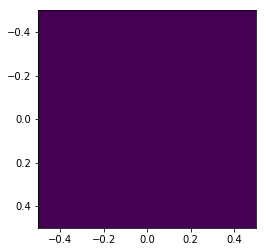


Filtro Corrente: 
 [[[ 0.05990586  0.02181759 -0.05064481 -0.0244023   0.04171822
   -0.03185479  0.00630034  0.0325803   0.00331586 -0.09801266
   -0.04066145 -0.0137522  -0.00782971  0.00329537  0.03469797
    0.06176076]
  [-0.00143523 -0.02758974  0.05042537 -0.00986041 -0.01064968
    0.0095825   0.03895384  0.00328803  0.03220681  0.05250724
   -0.02433782 -0.01112029 -0.0218483  -0.04593224 -0.01569025
   -0.00365438]
  [ 0.01507624  0.00748785  0.00684049  0.00191772 -0.00279397
   -0.05520878 -0.01858756  0.02277629 -0.06690496 -0.01216989
    0.05119948 -0.01057066 -0.00313331 -0.08268697  0.0271072
    0.01909777]
  [ 0.0201783  -0.03951126  0.01963819 -0.00204728 -0.07287793
   -0.04931964 -0.0025069   0.00800902 -0.00790498 -0.01167824
    0.00786997  0.0011836  -0.02855818  0.00160877  0.01750231
    0.00483358]
  [-0.0457411  -0.01354369  0.01198592  0.02594418  0.00474783
    0.01357009  0.00275037 -0.0311218   0.01235578 -0.00700496
    0.02610955 -0.0347713   0.00237

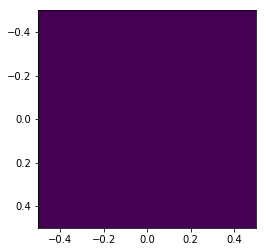


Filtro Corrente: 
 [[[ 0.00455617  0.0772076  -0.03517606 -0.03793139 -0.03843415
   -0.0398697  -0.02003513  0.00467274 -0.01329023 -0.0013438
    0.03461441  0.02666445 -0.03738176  0.00550935  0.01412552
    0.04853162]
  [ 0.04234476 -0.05057535  0.04002954 -0.03487894  0.0168742
   -0.02841703  0.07136572  0.01427041  0.02201714 -0.00446307
   -0.02625468  0.04118998  0.01881806 -0.04123173  0.0192972
   -0.01060232]
  [ 0.01073409 -0.00614137 -0.00168167  0.04661256  0.01311102
   -0.08923131  0.03359151  0.00849421  0.00277736  0.0313723
   -0.03555336 -0.06030766  0.06414604  0.00389885  0.05493092
    0.03172513]
  [-0.0402204  -0.00115928 -0.00461924 -0.02621143 -0.03410709
   -0.00574185 -0.05431383  0.00021336  0.02991    -0.01116176
    0.04437644  0.02273414  0.00824789 -0.01898856  0.05878648
   -0.01251347]
  [ 0.0383355  -0.01610167 -0.02331365  0.11581118  0.03641227
    0.0303971   0.063149   -0.03002776 -0.04961018 -0.00566522
    0.07298569  0.06731414 -0.03230713

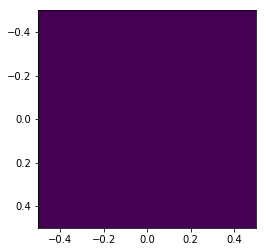


Filtro Corrente: 
 [[[ 0.01021515 -0.0358057  -0.04156126  0.01177381 -0.02568235
   -0.05404351 -0.0145211  -0.02651585 -0.034015    0.01414776
   -0.02022138  0.02260469 -0.00539911 -0.05128077  0.03025493
   -0.0095777 ]
  [-0.05730843  0.0178865  -0.03665031  0.02008231  0.01868824
    0.04421732  0.02776096  0.01362692  0.03663477 -0.05699771
    0.05888675  0.02006834  0.00433986 -0.04292807 -0.0023162
   -0.00706853]
  [ 0.03844567 -0.03718394 -0.03721422 -0.0328237  -0.00843764
   -0.01101627 -0.03777568  0.04588752 -0.04811771 -0.02609751
    0.04589588 -0.00706961  0.03221766  0.00715463  0.01847512
   -0.02949191]
  [-0.01559946 -0.04689708 -0.00736361  0.00122427  0.04324095
   -0.01644921 -0.01078117  0.03638433 -0.0190437  -0.01051985
    0.01451026 -0.00697074  0.00506771 -0.00346444  0.04852414
    0.011489  ]
  [-0.0568583   0.01281659  0.00600579  0.0283368  -0.00284588
    0.06072019  0.0231053  -0.04885822  0.00530519 -0.00874289
   -0.0467002  -0.03648998  0.08245

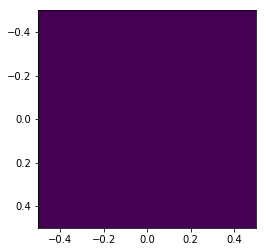


Filtro Corrente: 
 [[[-7.99188715e-02  2.36088961e-02 -6.54574651e-03 -3.50785395e-02
   -6.69964342e-03 -2.63140238e-02  3.26456393e-02  8.00419258e-02
   -9.51520162e-02 -6.57468548e-03  4.08008588e-02 -1.24410520e-02
   -3.38029012e-02  4.80584742e-03 -6.26675849e-02  3.05771010e-02]
  [ 5.72441853e-03  1.40575027e-02 -2.19707651e-04 -2.77145476e-02
    6.72912561e-04  1.49660597e-02  1.14081358e-02  2.60290564e-02
   -4.93956610e-02  5.67319886e-03  6.49262189e-03  2.09128035e-02
    2.07770361e-02  3.44451828e-02 -1.29521968e-02  3.89351060e-02]
  [-5.47698783e-03 -2.03492435e-02  5.14028848e-02 -3.53328213e-03
   -2.24021480e-02 -7.42670739e-02 -1.19269482e-02  3.37830460e-02
   -9.16520636e-03  6.18362236e-02  1.06208426e-02  1.35612476e-02
    7.18136122e-02 -1.30665775e-02  6.60401082e-03 -4.44748273e-02]
  [-3.23896426e-02  3.62027145e-02  3.47164758e-02 -7.11816127e-03
    1.12840476e-02  2.11302449e-02 -4.13114625e-02  5.51162784e-02
   -2.37633069e-02 -5.34010545e-02 -1.4

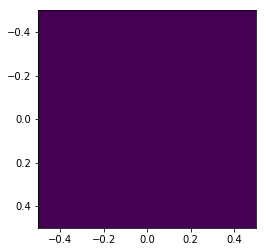


Filtro Corrente: 
 [[[ 0.01676644  0.08125874  0.00927749  0.03168362 -0.01550362
   -0.01852612 -0.07408618  0.02436242  0.01943144 -0.01531672
    0.02343957 -0.0272235   0.01625452 -0.01636623  0.07505759
    0.02414856]
  [ 0.00811398  0.04681484  0.00246673  0.02243312  0.02559837
   -0.08076039 -0.02487118 -0.03960464 -0.01599608  0.06034339
   -0.03998733  0.01770915  0.01149598 -0.03158324  0.02856266
    0.0427036 ]
  [-0.08902349 -0.00161403  0.00460094 -0.00040857  0.03969061
   -0.01635504  0.01330753 -0.08719829 -0.03068992 -0.0608243
    0.01299412  0.02928907 -0.03755399  0.00378701  0.02420728
   -0.06940236]
  [-0.06782791  0.03428015  0.04231862 -0.01507612  0.03966604
   -0.07630823  0.05099492  0.01815054 -0.04881852  0.03891556
   -0.03191683 -0.08174043 -0.00597721  0.05799573 -0.0372743
   -0.03652037]
  [ 0.04550533  0.03921814 -0.1358257   0.02765464 -0.04834538
    0.01354359 -0.06788082  0.05597293  0.00598271 -0.01717149
    0.01933169 -0.01284007  0.052434

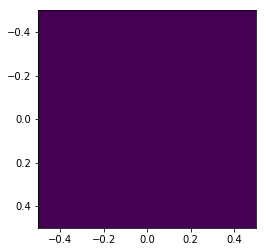


Filtro Corrente: 
 [[[-2.30694777e-02 -4.40666143e-02  5.91193637e-02 -1.94153739e-02
    6.20045596e-03  1.68256627e-02  5.24316861e-02 -3.35660274e-02
   -1.46633120e-03 -3.60302555e-02  1.89209525e-02 -2.29781386e-02
    2.14430759e-02  2.23034958e-02 -5.39046768e-02  1.66709435e-02]
  [-1.01533967e-03  2.67905986e-03  1.94161318e-02 -7.25256769e-02
    6.70709050e-02  1.54877165e-02 -5.09844200e-02 -3.45432989e-03
   -1.77183797e-02 -4.86554794e-02 -6.82351054e-02 -3.80831884e-02
   -1.40812223e-02  3.52317265e-03 -4.40322330e-02  5.48751781e-02]
  [-1.99651194e-03 -3.63954329e-02  3.73134186e-02 -1.29311861e-02
    7.79764679e-02  3.57161135e-02  7.26579671e-03  1.89657825e-02
    4.77670884e-02  4.40839101e-02  4.59958074e-02  1.27000118e-02
    2.40364290e-02  1.35807578e-03  1.81642892e-02 -2.42470627e-02]
  [ 4.85074304e-03  4.19212006e-02 -3.42299909e-02  1.79238959e-02
    7.15949701e-03 -5.18592286e-02  2.19001541e-02 -2.29444914e-02
    1.08032181e-03  3.49866772e-02 -3.0

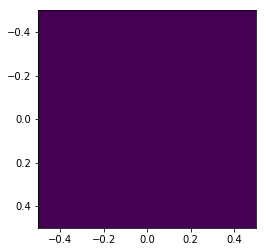


Filtro Corrente: 
 [[[-2.69902955e-02 -2.37884825e-02  1.50657133e-02  4.11946250e-02
    3.72477439e-02 -3.44055322e-02 -4.99680552e-02  5.35238825e-02
   -1.02168075e-04  3.89278607e-02 -1.28761821e-02 -6.22427727e-02
    1.88673982e-02  7.84729769e-03 -2.77534409e-02  4.92249520e-02]
  [ 1.94974989e-02 -6.23234366e-03 -1.73565563e-02 -4.05007793e-02
    8.77220619e-03  3.97398302e-04 -2.14953744e-02  2.28543041e-02
   -4.28830549e-02 -3.02175941e-02  5.20033430e-02  4.14160380e-02
   -4.17622340e-02 -3.20912914e-03  2.88205457e-02 -2.02037261e-02]
  [ 2.43485039e-02 -4.06787903e-03 -1.29974431e-02  5.21144536e-02
    3.29217529e-02  3.00943742e-03  2.11018008e-02  9.69279684e-03
   -5.56144229e-02 -8.82850155e-03  1.01368042e-02  4.98989217e-02
   -3.39511885e-02 -1.73120189e-02 -1.11012336e-02  8.83958860e-03]
  [-6.84491634e-02 -8.74485436e-03 -1.06955179e-02  1.11975316e-02
   -2.76454970e-02 -6.92605250e-02 -7.32252223e-02 -4.04921156e-02
   -2.90620084e-02 -5.44590592e-02 -6.5

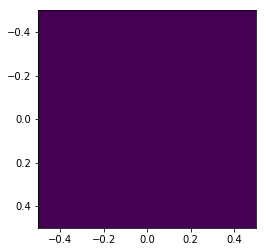


Filtro Corrente: 
 [[[-0.01899668  0.00830809 -0.00892433 -0.01519345 -0.00911428
    0.02806371 -0.03885643  0.01706759  0.01193257 -0.03697472
   -0.00535447  0.08397077 -0.04552001  0.02331574 -0.00417586
   -0.03029047]
  [-0.01159012  0.02360765 -0.01167136 -0.03585653  0.04430504
   -0.03930629  0.00892044 -0.01017719  0.01437078  0.03906116
   -0.06167381  0.00301826 -0.01759931 -0.02816832 -0.01575868
    0.00376557]
  [ 0.05095542  0.01843965 -0.02277389 -0.0074982   0.03536661
   -0.03189866  0.02597956 -0.01047722 -0.01323358  0.05103967
   -0.03705058  0.04133764  0.05774396  0.01969407 -0.03402604
    0.017837  ]
  [ 0.01175676  0.02906125 -0.03082275  0.00849138 -0.00574158
   -0.05954195 -0.02026558  0.00236836  0.03534023  0.04630533
   -0.01103597 -0.0564775  -0.02001686  0.062457    0.03437524
   -0.05697453]
  [ 0.02461702 -0.02798745 -0.01160712 -0.03005417  0.03410748
    0.02004652 -0.05549495 -0.04059185  0.0525934   0.05105526
   -0.08327308  0.01735603  0.0548

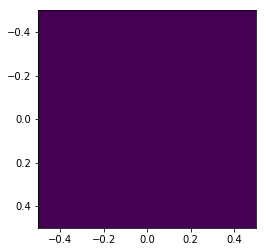


Filtro Corrente: 
 [[[-1.82465426e-02  2.85348452e-02 -4.45004585e-02  1.00990197e-02
    2.15900519e-03  5.97570341e-02  1.26528961e-02 -2.50969616e-03
   -2.81107908e-02  5.84326510e-03  5.06885025e-02 -3.02522210e-02
    9.38773952e-04  3.90932330e-02 -1.99866308e-02  2.20353128e-02]
  [ 3.51503900e-02  1.17263418e-03  4.92534834e-02 -1.74860160e-03
   -4.47285165e-03 -7.84707031e-02  3.14960545e-04 -1.14459345e-02
   -4.47937626e-02  4.63114473e-03 -2.17944525e-02  1.21180904e-02
    3.13815636e-02  1.89923093e-02 -2.41202496e-02  9.91437571e-02]
  [ 2.48301142e-02  3.00554177e-02  4.64495343e-02  4.17568653e-02
   -5.14026799e-02 -2.13226907e-02  2.63107009e-02 -3.83572643e-02
   -4.27264031e-02  6.15630403e-02 -1.79113082e-02  3.29580879e-02
   -6.05078087e-02 -9.28261488e-03  2.95283618e-03  9.00568141e-02]
  [-5.53771905e-03 -3.07488861e-02  1.72782274e-02 -1.30099247e-02
   -2.80078201e-02  7.36794003e-02 -2.81808198e-02 -5.81706207e-02
    1.13073490e-02 -2.04541389e-02 -6.9

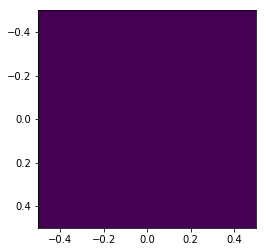


Filtro Corrente: 
 [[[-5.05783673e-02 -1.52049288e-03 -1.21682984e-02 -2.20743110e-02
   -1.38352181e-02  1.66970213e-02  1.08757436e-03 -3.60943479e-02
    1.31351054e-04  3.55635507e-02  1.14838148e-02  6.37223657e-03
    2.11725396e-02  1.59848122e-02 -3.82639048e-02  1.39046094e-02]
  [-1.79905950e-02  1.44712980e-02 -6.67618591e-02 -2.45136663e-03
   -2.97589868e-04 -2.95635143e-02  5.07477383e-03 -5.64230490e-03
   -8.88572767e-03  5.10351836e-02  2.22264259e-02  2.19495534e-02
    4.77806651e-02  1.68498851e-02 -5.72520036e-03 -2.02290854e-02]
  [ 4.14664058e-02  5.33987060e-02 -1.66635377e-02 -3.55788274e-03
   -6.10321816e-02  5.65940301e-02 -6.15906585e-02 -3.61772083e-02
    8.36683856e-03 -8.04393161e-03  2.03872455e-02  1.32476096e-02
   -4.60685931e-03 -5.01624915e-02  2.78792522e-02  4.00400871e-02]
  [ 1.93008653e-02 -6.02949010e-03  7.38590899e-02 -3.09075444e-02
    1.13361092e-03  1.55237604e-02 -1.14350856e-02 -1.49957112e-02
    1.63439129e-02  1.57616060e-02  1.9

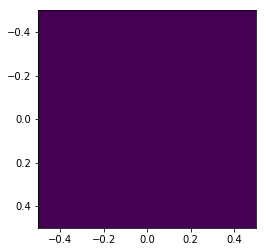


Filtro Corrente: 
 [[[ 3.56938906e-02 -6.05248181e-04 -1.47910143e-02 -1.60734452e-02
    4.42989176e-02  1.71147611e-02  2.38816881e-02 -3.38279173e-02
    2.01020511e-02  2.52812060e-03 -2.47023278e-03  2.03859097e-02
   -2.99159028e-02 -2.29331784e-02 -3.80751017e-03  7.41542853e-02]
  [-7.64639901e-02  2.98649938e-02 -6.66738848e-04  3.90919514e-02
    3.39320214e-02  6.32212601e-02  1.25563731e-02 -8.04460709e-02
   -1.79377761e-02  1.75657922e-02  2.83624256e-02  1.85294678e-03
   -1.96224303e-02 -1.10367983e-01 -4.82998991e-02  3.10955414e-02]
  [-4.37755113e-02 -1.95243645e-02 -7.14861635e-05  1.14492746e-03
    3.84934942e-02 -3.33838244e-02  2.44246044e-02 -2.75888697e-02
   -7.02628901e-02  1.93021859e-02 -9.92610771e-04 -1.36254173e-02
   -3.55640766e-02  3.64375907e-02  3.20852483e-02 -2.33214508e-02]
  [-3.29162881e-04  1.55455718e-02  4.92522465e-03  3.85963043e-04
    5.46869088e-02 -4.24453169e-02 -8.80793402e-03 -4.64314202e-02
    1.04542988e-02 -2.44603850e-03 -1.5

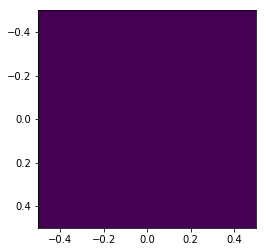


Filtro Corrente: 
 [[[ 2.64890818e-02 -3.61099546e-02  8.64553781e-04  6.78894766e-03
   -1.05733759e-02  1.80275975e-03 -1.46821397e-02 -5.85608386e-03
   -1.80444296e-03  1.68438541e-02  2.28447090e-02  5.34130520e-03
   -3.12779106e-02  6.16244394e-04  8.06398872e-02 -3.78268413e-02]
  [-5.13551573e-02  7.56731275e-02 -2.06990152e-02 -4.77394731e-02
   -4.62231412e-02 -1.17506217e-02 -7.85153447e-02  8.78832823e-02
   -2.95125210e-03 -1.94888211e-02  4.83091614e-02  1.98322812e-03
   -1.55545892e-02  3.00271311e-02 -2.58751214e-02  5.55531851e-03]
  [-8.66694247e-03  5.24972625e-02  6.23730077e-03  5.16817188e-02
   -7.23234833e-05  7.20137952e-02  5.86475596e-02  1.17797534e-02
    2.76125232e-02 -3.48634469e-02  2.22283676e-02 -3.30256148e-02
    1.31024600e-02 -8.02908547e-02 -1.98465780e-02 -4.13800274e-02]
  [ 4.59351670e-03  3.36429663e-03 -1.20302111e-02  7.52917448e-02
    5.00025677e-02 -3.50399603e-03 -2.56127059e-02  3.96915771e-02
    1.58752842e-02 -1.65713490e-02  2.4

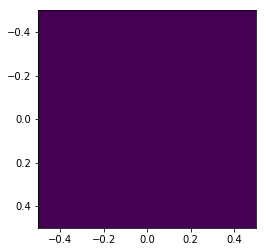


Filtro Corrente: 
 [[[-0.02801596  0.04239134 -0.01111563  0.01631766 -0.07648861
   -0.01777116  0.02994146  0.02595475  0.02101459 -0.07995521
    0.00206358  0.0186587  -0.00483487 -0.02148865  0.02115101
    0.00700604]
  [-0.01044648 -0.01825219 -0.04067231 -0.0641067  -0.02816903
   -0.03454724  0.02092553  0.03283784 -0.00974944 -0.00748916
   -0.01888044  0.04491762  0.10002315 -0.05602122  0.0132558
   -0.03035113]
  [ 0.04459944 -0.01777706  0.01368448  0.03075267  0.03207948
    0.02575993 -0.0153132   0.03990197  0.03650341  0.02212763
    0.01871844  0.0088114  -0.00316811  0.00911037 -0.02173389
   -0.00852885]
  [-0.02872436 -0.03430241 -0.03203034  0.05439476  0.0150495
    0.03575999 -0.05906635 -0.03487872  0.04326018  0.00656692
   -0.11739623  0.01836233  0.04304677 -0.01397005 -0.12162843
   -0.02422035]
  [ 0.02027757 -0.10139946  0.03394272  0.03520468  0.01390612
   -0.00238688 -0.05215867  0.02649933 -0.05178337  0.01719317
   -0.00044956  0.00387003 -0.047105

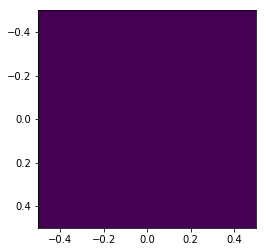


Filtro Corrente: 
 [[[ 0.01230155  0.01726491 -0.05229439  0.00395774  0.03390575
    0.03725382 -0.02840038 -0.0291497   0.00674643  0.01772434
   -0.02824825 -0.04861422  0.0004035  -0.01817814 -0.04560812
    0.03185607]
  [-0.03915217 -0.01999741  0.08990739 -0.02480723 -0.01845849
    0.05216043  0.06922988 -0.02857001  0.02266693  0.04238628
    0.07569054  0.0428398  -0.04777574  0.00467444  0.01931471
   -0.00651733]
  [-0.01287956 -0.04151417 -0.01267588 -0.02472465 -0.00962653
    0.03020132 -0.03752028 -0.02732849 -0.00997372 -0.03936353
   -0.00473157 -0.00190446 -0.00940184 -0.01834667  0.01863123
   -0.04939858]
  [ 0.04208607  0.00033004  0.00328406  0.03773076 -0.02854382
    0.00127712 -0.0263784  -0.00415227 -0.03670843 -0.06209103
   -0.03907374 -0.03692334  0.04047968  0.03017327  0.07473675
   -0.02663355]
  [ 0.05636391  0.00575256  0.0537639   0.03753282  0.05050931
    0.01813103 -0.01047038 -0.03467522  0.02252192  0.00013769
   -0.00218496 -0.01687003 -0.0141

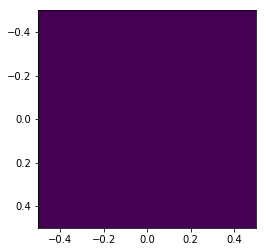


Filtro Corrente: 
 [[[ 0.03163338 -0.05618485  0.04360187 -0.00984129  0.00427379
   -0.02407251  0.01072956 -0.02186673 -0.0682044   0.03162823
    0.00234216 -0.01850312  0.0309216  -0.03644043  0.06639204
   -0.05801706]
  [-0.02805565  0.02085111 -0.02874349 -0.03793529  0.02047157
   -0.04685996  0.02261676  0.03228328  0.03609086 -0.01169916
    0.00086442 -0.00595686  0.02973684  0.03392897  0.01826069
   -0.00760835]
  [-0.01888939 -0.00375283 -0.0399889   0.0192349  -0.00825611
   -0.03148771  0.0223255  -0.06748018 -0.00565524  0.09868263
    0.01173075  0.00034355  0.05690273  0.06106191 -0.05034817
    0.02041667]
  [ 0.00841834 -0.01471088 -0.03481691 -0.04151417 -0.00169451
    0.01814315 -0.0560834   0.01209905  0.06512725 -0.03381318
   -0.07299802 -0.00243517 -0.0499131   0.02550636  0.02536642
   -0.04614159]
  [-0.00082172  0.01217167 -0.01242612  0.08060953 -0.00911647
   -0.03942609  0.05803017  0.01432365 -0.04525194 -0.00648748
   -0.0185187  -0.07554476 -0.0159

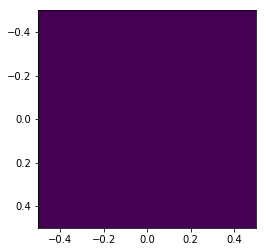


Filtro Corrente: 
 [[[-0.00593766  0.02941326  0.0221643  -0.18366978 -0.29416092
    0.01304864 -0.12325366  0.01643526  0.03400798  0.09274717
   -0.06262323  0.05929467 -0.14521122 -0.31746382  0.02442812
    0.00859459 -0.07081016  0.03887411  0.04123724  0.20039462
    0.04500442  0.08954607 -0.00648541  0.13438333 -0.2205338
    0.1266766  -0.02791875  0.0570381  -0.07651491  0.15979619
   -0.0594925   0.10773539  0.15903683  0.07408555 -0.13807723
    0.03583674 -0.01782517  0.04596965 -0.05063405 -0.01877261
    0.22781324  0.13068048  0.11215108 -0.0228744  -0.12538892
   -0.11562997 -0.24883746  0.08032914 -0.03488865  0.00395982
   -0.03689919  0.021462   -0.0431931  -0.02908988  0.13893437
   -0.0143987   0.06288534 -0.20989931 -0.14889496  0.01887947
    0.03325537  0.03248545 -0.10039082  0.10854588  0.14875545
    0.16190163 -0.01305092  0.02562883  0.111446    0.0237783
   -0.08138315 -0.07921965 -0.05883646 -0.05499584  0.06993507
   -0.00850483 -0.15365915 -0.1291042

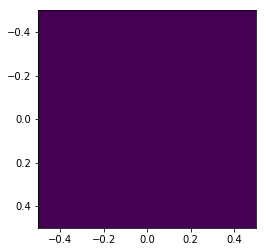


Filtro Corrente: 
 [[[ 0.21327974  0.15117458  0.07706334 -0.27110445 -0.09055531
   -0.06186809  0.08559418  0.08235886 -0.01197355 -0.0645889
   -0.179925   -0.01872903 -0.05134608  0.12016261 -0.07997489
   -0.15303389 -0.30665973  0.06489432 -0.17525846  0.14813538
   -0.40908726 -0.08937219 -0.07536085 -0.11408677  0.14735534
    0.09667094 -0.28317221 -0.26363696  0.04808176  0.05217992
    0.09855624 -0.14950091  0.15157561 -0.13939855 -0.0958026
   -0.1633344  -0.12156854  0.37537909 -0.09516938  0.13394939
   -0.00400418 -0.0954863  -0.07754833  0.04134056 -0.0204603
   -0.00806018  0.10001641 -0.05079785 -0.0905691   0.06367501
   -0.04423313 -0.22983026 -0.17683526 -0.03541356  0.07152231
    0.16856338  0.09046883  0.04048803  0.21536805 -0.23635442
    0.0288945   0.03808676 -0.02099653  0.06681956  0.05176392
    0.03654076  0.02345055  0.16809333 -0.02595229 -0.00182751
    0.09440634  0.13054748 -0.19319685  0.23967034 -0.01356652
   -0.12092015  0.1745943  -0.12385046

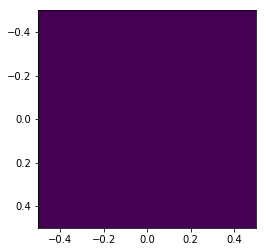


Filtro Corrente: 
 [[[-1.43645390e-01 -2.32185429e-02 -4.09087936e-02 -3.97755715e-02
   -4.05711695e-02  3.05385053e-02 -5.59211036e-02 -2.77727641e-01
    7.62165036e-03  1.49454964e-02  8.89915930e-02  7.34653481e-02
    9.08212470e-02 -8.48048925e-02 -1.69837164e-01  3.53083982e-02
    1.45839777e-01  6.31419715e-02 -5.70854026e-03 -1.76072176e-01
    1.47152151e-01 -5.14750198e-02 -3.35513569e-02  7.12167004e-02
    1.96639342e-02  3.28242457e-02 -1.85969472e-03 -1.85554843e-01
   -2.12865409e-01 -1.36719210e-01 -1.88181833e-01 -1.81412145e-01
   -4.26408666e-02 -6.01646152e-02 -1.55248613e-01  1.42906009e-01
    5.74726969e-02 -1.12739077e-02  1.10702400e-01  2.62888712e-01
   -5.80474529e-02 -1.08088677e-04  4.78400835e-02  7.69838310e-02
    2.19814609e-02 -8.31752205e-02 -8.88415126e-02  8.79662781e-02
   -7.68326113e-02 -8.40383579e-02  2.63925844e-02 -2.04221757e-01
   -2.57248988e-01  2.13755094e-01 -4.64058270e-02  2.69979918e-02
   -1.55196929e-02  8.89206216e-02 -1.1231

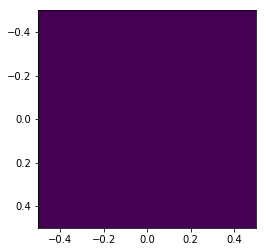


Filtro Corrente: 
 [[[ 0.08834717  0.20388427  0.05025916  0.14330697 -0.06065342
    0.03018636 -0.09902557  0.11726141 -0.07419071 -0.07685963
    0.02005758 -0.07902864  0.0185282  -0.21373163  0.1072754
    0.07592367  0.15437237  0.11603912 -0.08540961  0.10812713
    0.00878826 -0.24521725 -0.19244139 -0.06058599  0.09234432
    0.17617676  0.07504826  0.20024867  0.03749931  0.01674978
   -0.16967202 -0.13317424 -0.13937612 -0.12332398  0.16678426
   -0.19463012  0.02575275 -0.01271727 -0.09599954 -0.06447373
   -0.11902779  0.13974711 -0.03191313  0.04232528 -0.12426339
    0.02777276 -0.04430851 -0.14683694  0.00478318 -0.16198969
    0.08458206  0.03380127 -0.00790256  0.22532193 -0.06261983
   -0.01828366 -0.21521234 -0.1131407   0.28655821  0.10658685
   -0.01395321  0.07551369 -0.13790803  0.13925449  0.18088855
   -0.03813747  0.29943082  0.00057535  0.04841767 -0.09630564
   -0.03100852  0.01614417  0.0017471  -0.14127241 -0.03346433
   -0.15575922 -0.00759291 -0.198760

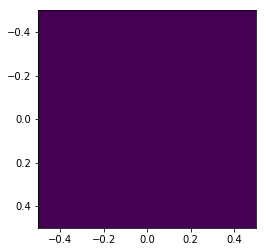


Filtro Corrente: 
 [[[ 0.11340676 -0.27601293  0.14549293  0.05253672 -0.14398526
   -0.11797373 -0.10909415  0.12001271  0.06924228  0.04833005
    0.12228453  0.0634812   0.13782883  0.11863477 -0.10572474
    0.0295271  -0.19513324 -0.04106512  0.22929681  0.0188489
   -0.20572644  0.17865391  0.0042419  -0.01985802 -0.02529431
   -0.06307623 -0.11529692  0.16900204 -0.18122749  0.22024904
    0.05173591 -0.02331789  0.16328437  0.23296785  0.07927396
   -0.20928793 -0.02271129 -0.04124076 -0.04375041  0.11390893
    0.01588778  0.04495772  0.08395507  0.0118816   0.01807681
    0.05829029 -0.0471693  -0.005963   -0.20270052  0.08428237
   -0.04672469 -0.09247432  0.37214    -0.12874326  0.04328739
    0.07465173  0.0834541  -0.04748755  0.05618175 -0.15052321
   -0.11003335 -0.02935987  0.02441617 -0.06430522  0.09480558
    0.12821547  0.07544554  0.13214529  0.1689608   0.18058878
   -0.14533877  0.11560478  0.06035763 -0.10145104  0.17492454
    0.06004179  0.04633972 -0.004868

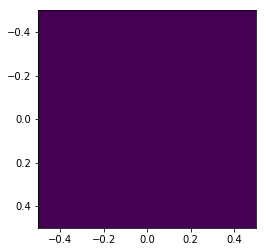


Filtro Corrente: 
 [[[-0.02824096 -0.07674698  0.04487194 -0.12893093 -0.18291005
   -0.12668279  0.0663241   0.0964678  -0.17626996 -0.09614078
    0.05408323 -0.05758031  0.00754702  0.10899352 -0.10373303
    0.14606429  0.10011433  0.05237157  0.00082278 -0.08152938
    0.09377429  0.15939449  0.01008916 -0.11058777 -0.06735122
    0.11564509 -0.02753181  0.29524704 -0.23857065 -0.15546265
   -0.13203049 -0.15867895 -0.06216845  0.12516865  0.11100677
   -0.13548037  0.08577823  0.0029365  -0.22304617  0.26013667
    0.04003391 -0.00466729  0.28563473 -0.05767787 -0.07457627
   -0.06583605 -0.08527295 -0.04046475  0.24399073 -0.01052687
   -0.12817971  0.16283459  0.20135574  0.15435739  0.17643044
   -0.06325881  0.05749301  0.20685929 -0.01032513 -0.21112901
    0.04701676 -0.12584139  0.13671576 -0.13198294 -0.09240325
    0.16302572  0.16654784  0.1447444   0.31943856 -0.16018583
   -0.04571751 -0.04494813 -0.07183138 -0.19576908 -0.04831773
    0.28167895 -0.05467987 -0.27874

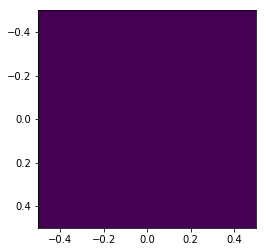


Filtro Corrente: 
 [[[ 0.16033031 -0.04453691  0.04508606 -0.12859291  0.01136323
    0.20693802  0.19073439 -0.00569849  0.11583257  0.18454149
   -0.0416454   0.23120906  0.04909326 -0.0548967   0.06636395
   -0.22586836  0.10914932  0.20090913 -0.07605514 -0.04430538
    0.29387461  0.17723311  0.09093901  0.07545236  0.00369813
    0.23763532 -0.07223003 -0.0743349   0.05795501 -0.01887649
   -0.0551768   0.16431719  0.11267764 -0.03695303  0.15500884
   -0.05467551 -0.11717719  0.10356597  0.00870936  0.27236684
   -0.04115005  0.20747136 -0.08553287 -0.05180992  0.00479534
    0.11270868  0.10909423 -0.04712332 -0.21338648 -0.16712645
   -0.04407783 -0.21707718 -0.00213977 -0.10447834 -0.02581492
   -0.00842401  0.06827607 -0.06346839  0.09204838 -0.1512761
   -0.33437232  0.19583322  0.14784097 -0.11191877 -0.28067761
   -0.24291117  0.09508656  0.01801675  0.19208423  0.04799443
    0.02391654 -0.15292196  0.07009605 -0.00237209 -0.05804893
    0.08853026 -0.02748519 -0.122402

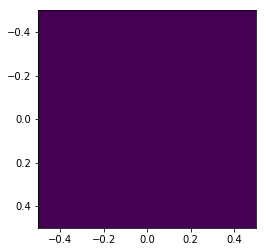


Filtro Corrente: 
 [[[ 0.06384529 -0.19209507 -0.11815185 -0.03755556  0.03969515
    0.13777573  0.10747978  0.1139577  -0.09324557 -0.12890456
   -0.03934607  0.042545    0.27201549 -0.0466962   0.08550686
    0.02794873 -0.25335187 -0.15382063  0.28479755 -0.21055695
   -0.14159711 -0.0853825  -0.11460684  0.08866997 -0.18209721
    0.14113754 -0.14970318 -0.02187814 -0.13448759  0.1974084
    0.07798534 -0.06163735 -0.07254122 -0.06179267  0.15340396
   -0.08432259 -0.2530536  -0.16353161 -0.22097017  0.11266935
   -0.0803451   0.37256411  0.07775116  0.22623139  0.02268746
   -0.14470069  0.08164329 -0.09900309 -0.13593012  0.0849648
   -0.02065774 -0.20222766 -0.08681163  0.04030889 -0.12585318
   -0.12372275 -0.07308981 -0.03777421 -0.02455752 -0.02550143
   -0.1547128  -0.01744263  0.15585393  0.05727438 -0.20170767
    0.35991964 -0.04011236  0.25126579 -0.04998003 -0.22099919
    0.0049095   0.15346763 -0.1089605   0.06601374  0.09538114
   -0.04664094  0.11020619  0.0014454

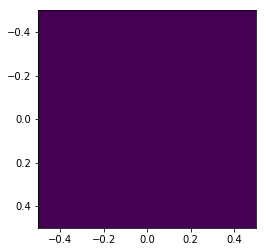


Filtro Corrente: 
 [[[ 0.03323587  0.08037605 -0.23895921 -0.05140541 -0.12677181
   -0.08264598 -0.1504782   0.17961417  0.01080987 -0.15609101
   -0.04446751  0.00817385 -0.18046572  0.06716944 -0.05207424
   -0.1158785   0.09608427 -0.03043439  0.13474137  0.1570927
   -0.14840518  0.05535867  0.1541565  -0.01546068  0.07185921
   -0.01432779  0.05234712 -0.06818108 -0.0252582   0.04886214
    0.02106438  0.19124585 -0.13524779  0.04452538 -0.17991515
   -0.00538714  0.01114543 -0.16665713 -0.11030642 -0.06435399
   -0.07350251  0.10493563  0.07086667 -0.03006862  0.04743083
   -0.02122231  0.16981731 -0.00838798  0.00274771 -0.14728721
    0.13009048 -0.28790037  0.09915567 -0.0284698  -0.14009288
    0.00474197 -0.03198274 -0.03142213  0.01181637 -0.14676141
    0.0586386  -0.02008533 -0.19250351  0.03477165 -0.09851463
    0.0471459   0.07010201  0.00148978  0.03736704  0.27979494
    0.06793864 -0.0683484  -0.01039979 -0.10815636 -0.12354804
    0.10799949  0.14707913 -0.059620

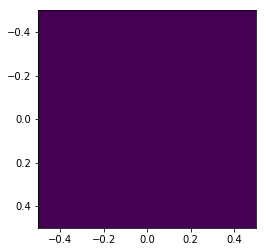


Filtro Corrente: 
 [[[-9.80863407e-02 -2.16606806e-01 -3.11659698e-01 -2.41235554e-02
   -1.12166854e-01  6.52590033e-02 -8.76049655e-02  1.33465952e-01
    2.02979102e-01 -2.99310051e-02  1.04705817e-01  1.68448384e-01
    5.63694876e-02 -3.21511163e-02  8.86758290e-04 -2.34654427e-01
    1.70720309e-02  6.45288919e-02  1.63095416e-01 -5.22289315e-02
    1.93157207e-01 -9.16999332e-02  2.14588113e-01  7.41144079e-02
    3.85808882e-03  5.98937150e-02 -8.34943096e-02 -1.06869278e-01
   -3.14765921e-02  1.14288682e-01  2.18122927e-01 -2.70310603e-01
   -1.23138603e-01 -5.83128929e-02  2.37851530e-01 -1.43973491e-01
    7.23409763e-02  6.93943062e-03 -7.38217745e-03 -2.61597708e-01
    7.08928250e-02 -4.45537631e-03 -7.17769074e-02  1.82984562e-01
    1.07575823e-01 -3.55857233e-02 -1.08999786e-01  6.59271047e-02
    3.76185054e-01  1.21653969e-01  1.40939085e-02  8.20320033e-02
   -2.36487693e-01  1.98046459e-01 -2.52358920e-01 -1.24263955e-01
    1.21968367e-02 -9.61230046e-02  2.0243

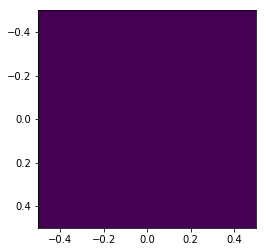


Filtro Corrente: 
 [[[ 0.02661971 -0.1341817  -0.07500302 -0.13162975  0.00505741
    0.02142842 -0.13794177 -0.09276652 -0.01325904 -0.11288083
   -0.21425653 -0.00552883 -0.059962   -0.00091472 -0.1661509
   -0.09879641 -0.08201881 -0.12006559 -0.12527049 -0.26699394
    0.19784189 -0.14387814  0.08549002  0.13453285  0.05108253
   -0.00309143  0.02760649 -0.0420217  -0.0857995   0.09068764
   -0.37449962  0.0358492  -0.17302189 -0.01725214 -0.07068907
   -0.05434905 -0.12025552 -0.13467426  0.19350988  0.07644754
    0.05336436  0.0470463  -0.13094552 -0.04746348 -0.01189276
    0.15608419  0.00988432 -0.06466415 -0.13594664 -0.30871826
   -0.11280474 -0.11575737 -0.0639598  -0.1498256   0.0892722
    0.05864253  0.16562484  0.1033907  -0.03265598  0.20292626
    0.07202541  0.08555825  0.07213638 -0.06347708  0.13176327
    0.03615117  0.0558744  -0.09872919  0.28514865 -0.07397999
    0.0492593  -0.18045113 -0.23953608 -0.07022265 -0.06571129
    0.00042189 -0.07065033 -0.1590875

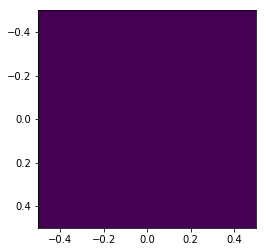


Filtro Corrente: 
 [[[-0.1225276   0.10003938  0.1316658  -0.16483108 -0.04048023
   -0.13582518 -0.09190568 -0.0215713   0.01269052 -0.13043678
    0.13363426 -0.01688141  0.07433457  0.04871428 -0.14813612
   -0.25752173  0.22952083  0.09613725  0.05648659 -0.05823212
    0.1169077  -0.11544244  0.11011245  0.06828542 -0.18333047
   -0.06982256 -0.08321412 -0.00304638  0.05520482  0.15302908
    0.03247863 -0.02022858  0.15941102  0.00650318 -0.07472664
    0.07685269 -0.1076225  -0.23165246 -0.10567194 -0.00900027
   -0.01060348 -0.23933474  0.06650556 -0.20438325  0.09983518
   -0.04265355  0.14356345  0.12754629 -0.12309411 -0.05991253
   -0.06185944 -0.10151956  0.05409149 -0.09442131  0.04285716
    0.03356126 -0.09888591  0.29770688 -0.00193578 -0.1891584
    0.11186733 -0.06741968  0.03598455 -0.04982739  0.01152532
   -0.02745164  0.31207154 -0.04154062  0.01552482 -0.13916924
   -0.08294711 -0.07117708  0.0319131  -0.14372382 -0.03293275
   -0.00734871 -0.02530694  0.027617

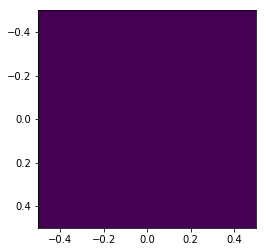


Filtro Corrente: 
 [[[-1.46698342e-01 -4.72329416e-02  2.06294139e-02 -8.82641851e-02
    1.25399349e-01  5.43572285e-02 -4.30404038e-03 -1.59455860e-01
    2.36398356e-01 -9.55763628e-03  3.65364619e-02 -1.82836657e-01
    7.87916620e-03  3.51615219e-02 -3.22035128e-02  4.73764341e-02
    1.01030763e-01  1.54727034e-01 -3.01227978e-02 -5.14628516e-02
    8.03834918e-02  1.78112109e-01  9.18499362e-02  2.06423971e-02
   -1.82509029e-01 -4.78249212e-02 -5.25708057e-02  1.60100717e-02
    5.50587305e-02  3.58374491e-02 -1.78382544e-01 -6.45728233e-02
    1.92355076e-01  8.25040393e-02  2.30488741e-01 -1.03784695e-02
    2.66452707e-01 -1.47184388e-01  9.07150861e-02  2.21460560e-02
   -2.81680984e-01 -1.30392778e-02  2.52903821e-01  1.79385106e-01
    1.31735195e-02  4.44145314e-02  6.90730941e-02  2.66672386e-01
   -2.36548339e-01 -2.01812455e-01  9.15636527e-02 -7.43041215e-02
    6.78797061e-02  4.37664082e-02 -2.12357141e-01  1.76312002e-04
   -1.83433839e-01  7.16530001e-02  5.4057

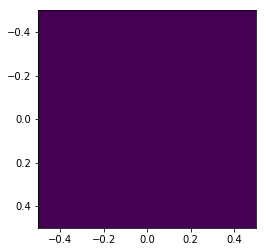


Filtro Corrente: 
 [[[ 6.44960642e-02 -4.84407429e-02 -2.31898154e-01  1.72185414e-01
    2.60874283e-01 -2.85512245e-02 -1.26558785e-01 -8.10277433e-02
    9.50920803e-02 -8.00416771e-02  1.13901931e-01 -2.06741380e-02
   -2.73374342e-02 -1.23081652e-01 -3.06388511e-02  1.65293450e-01
    2.14270387e-01 -1.46793612e-01  6.72297700e-02 -1.51254693e-02
   -7.54268070e-02 -7.24555708e-02 -7.24332620e-02 -1.82220593e-01
   -1.83789332e-01 -2.32049760e-02 -1.03248619e-01 -2.39384296e-01
    5.79968837e-02 -9.79968078e-02  6.10869796e-02  2.32322784e-01
    3.88019063e-02 -8.76796550e-02  1.58046693e-01 -6.02281380e-02
   -2.36715072e-01 -1.48391463e-01  1.58554580e-01  8.82709089e-02
    2.27116873e-02  9.92796830e-03 -6.24391229e-02 -1.48537459e-01
   -2.76524409e-01 -7.45501799e-03 -1.95366365e-01  7.10369453e-02
    2.63124976e-01 -1.45814435e-01  7.22889958e-02  1.83206404e-01
    2.91535673e-02  6.95048581e-02  2.98284513e-01 -7.50706878e-03
   -6.24225646e-03 -2.01416843e-01 -1.1969

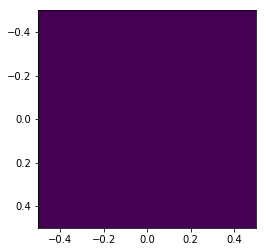


Filtro Corrente: 
 [[[ 1.03754844e-01  5.85511877e-02 -6.50428195e-02  5.00621403e-02
    2.41449035e-01 -4.75627753e-02 -6.28230905e-02  1.42095228e-03
    6.88665530e-03 -1.54305029e-01  7.16703830e-02 -1.21215548e-02
   -2.37941428e-01 -8.69572409e-02 -3.90594434e-02  3.15740350e-01
    1.14441515e-01  1.00364325e-02  2.84975768e-02  4.97841795e-02
   -4.13284704e-02 -1.50265417e-01  2.89287862e-01 -8.53339186e-05
    1.53774452e-01 -5.65866118e-03  7.15553440e-02  9.97941837e-03
   -1.51146164e-01 -9.67655392e-02 -6.88764921e-02 -1.04568732e-02
   -2.04151439e-01 -3.86740626e-02  6.53734985e-02  4.67592048e-02
    2.10555439e-01  8.39569881e-03 -2.17763524e-03  1.12516466e-01
   -9.36651923e-02 -2.15892980e-02  2.04188255e-01  1.41177954e-01
    1.82181054e-01  4.43160211e-02 -2.76231497e-03 -5.17712444e-02
   -1.92122287e-02  8.75806791e-02  1.22834278e-01  1.18738846e-01
    4.80252445e-02 -2.71268250e-01  8.71268475e-02  4.15071945e-02
    1.36328184e-03 -1.76687218e-01 -9.2922

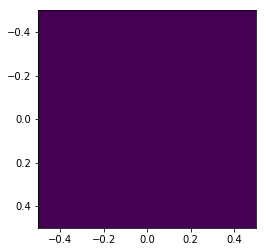


Filtro Corrente: 
 [[[ 0.2319276   0.02235713  0.04822076 -0.01711801  0.08675812
    0.13079495  0.22799368 -0.10911157 -0.00701442  0.11823167
   -0.05554823  0.29503883 -0.13273424  0.12943793 -0.14112327
   -0.1146194  -0.10282599  0.08538031  0.10017273 -0.06868986
   -0.09107916 -0.04501905 -0.02111191  0.06326176 -0.06961967
   -0.10445623 -0.06940986  0.22859563  0.03997598  0.03107365
    0.0720908  -0.12764323  0.07470686 -0.20785998  0.0516231
   -0.23807277  0.10983962 -0.19902961 -0.09839909  0.23311951
    0.03986363  0.02731926  0.10876323  0.03505367 -0.05225679
    0.13500674  0.04520059 -0.00567484 -0.07131031 -0.11379028
   -0.16634429  0.11870154  0.01670122 -0.08570036 -0.01412798
   -0.16154156  0.37518945  0.02877243 -0.07165431  0.03481455
    0.04315373 -0.10654497  0.19361886 -0.27334728  0.04385394
    0.05537706 -0.20798011 -0.21274808 -0.11265988  0.05530817
   -0.07849686  0.00977259  0.07125486 -0.35253688  0.11599501
    0.06496107 -0.14438115  0.132339

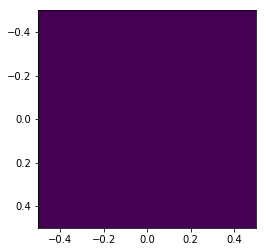


Filtro Corrente: 
 [[[ 0.05618492 -0.05289275  0.20954946  0.08958241  0.21245033
    0.13038348  0.11840683  0.01325715 -0.13401258 -0.05394877
   -0.11786075 -0.04141287 -0.12537509  0.15143665  0.13213073
   -0.06972064  0.02743955  0.03287097 -0.08488826 -0.0839646
    0.12142737 -0.01147045  0.10169479  0.01787507 -0.08777228
   -0.21590526  0.02111093  0.09140312 -0.21591939 -0.02879954
   -0.02161319  0.02487252  0.14185088  0.09216894 -0.03367349
    0.07275271 -0.02017949 -0.17426261 -0.03276271  0.01156796
   -0.13167959 -0.05374713  0.12219914 -0.13831118  0.022133
   -0.01845781  0.00582596  0.04378494  0.03229171  0.0181706
   -0.00386986 -0.02071158  0.0575819  -0.13803782 -0.11913876
    0.10253803 -0.17046178  0.00809074 -0.12526553  0.15945092
    0.07726785 -0.06147119  0.03373734 -0.05683487 -0.07854871
    0.1101144   0.04539616 -0.17858745  0.03058155  0.10146216
    0.16282046  0.08911193  0.21525752  0.08219046 -0.13849915
   -0.15069448  0.04832895  0.07166708 

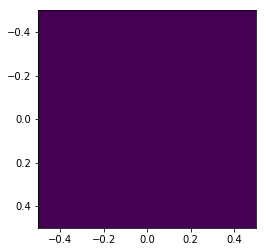


Filtro Corrente: 
 [[[-0.10294254 -0.16661258  0.05382584  0.02421064 -0.25173395
    0.04970994  0.03645245 -0.27018697  0.04785814  0.04758673
    0.21759201  0.05882734 -0.24890697 -0.02230544 -0.0281472
    0.12336133  0.12879023 -0.15845501 -0.11945512  0.15233251
   -0.19412689  0.13320408 -0.09414888  0.15845655 -0.11054118
    0.10439496 -0.00397344  0.23899309 -0.0435231  -0.19499783
    0.18755845  0.10378072  0.01337428  0.18359096 -0.01952409
    0.08514331  0.11222762 -0.19491424  0.05783111  0.00736208
   -0.07176278  0.19453334 -0.00428253  0.02419938  0.04959471
   -0.02963123  0.12135168 -0.12787157  0.10953256  0.25236723
   -0.16278407 -0.04272047  0.01644127  0.09790345 -0.10419079
    0.07535584  0.07262004 -0.06533127  0.07279574 -0.10574767
   -0.24997668  0.08936877 -0.03632327  0.01315756  0.04533089
    0.0999326  -0.24511283 -0.16289992  0.06551478 -0.03030493
   -0.00938868  0.1346721  -0.11898776  0.17090277  0.00607635
   -0.04100119  0.09824694 -0.124915

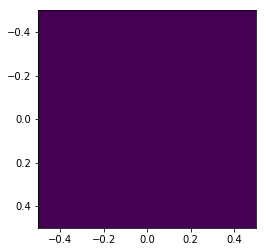


Filtro Corrente: 
 [[[ 0.02982081 -0.0420195  -0.0137523   0.10593043 -0.08030449
    0.23935693 -0.11519865 -0.00883567 -0.17518903  0.27439416
   -0.10887866  0.30210462 -0.02675653  0.03129475  0.00885273
    0.24575211 -0.11068973 -0.14388166  0.03064665 -0.14833193
   -0.11218253  0.06694285  0.08602905 -0.02721728 -0.11397403
    0.03707356 -0.00375864 -0.24945739 -0.005102    0.08426336
    0.10797796  0.1365725  -0.0032556  -0.12476972  0.0309431
    0.24382402  0.04338709 -0.14839683  0.27594617  0.27817049
   -0.0920731   0.02151464  0.20726006  0.04952613 -0.04187317
    0.01059106  0.00620547  0.30836903 -0.06372314 -0.02828562
    0.15791574 -0.05822827  0.05358755  0.06404045 -0.21236942
   -0.04335333  0.07485861  0.20083101 -0.05705889 -0.02808459
   -0.04205893 -0.04015058 -0.08578755 -0.01671024  0.01818052
   -0.07374338  0.03633923  0.00141564 -0.02181116  0.00688635
    0.04915172  0.03807565  0.10796294  0.07397466  0.17563935
    0.01124323 -0.01596578 -0.029168

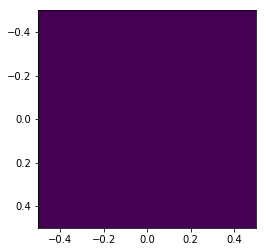


Filtro Corrente: 
 [[[ 0.01593678  0.12950353 -0.21383672  0.2730377   0.14135098
    0.07145656 -0.08048125 -0.02113383  0.00516381 -0.03798839
    0.30629446 -0.02688683  0.05568175 -0.08179347 -0.07078614
   -0.02285655 -0.06564015 -0.17902183 -0.12863816  0.0754425
   -0.23995106 -0.05246407 -0.08430386  0.01775397  0.10458827
    0.00628394 -0.07996653  0.05202182 -0.00440193  0.19032816
   -0.13272056 -0.18514829 -0.01674326  0.27736752 -0.0058385
    0.07744004 -0.12469803 -0.04360398  0.08722812  0.00404067
    0.05776051  0.0294007   0.13278436 -0.01245909 -0.09542671
    0.06450215  0.19341722  0.05328472 -0.01693634 -0.08349342
   -0.07308736 -0.07864766  0.06327248  0.11252451 -0.02768723
   -0.12284228 -0.17151048  0.13036526  0.23467491 -0.22319324
   -0.05313339 -0.21771239 -0.00607362  0.03240769  0.25276739
    0.03078694  0.2961999  -0.03847863 -0.01164557 -0.04528647
    0.03250239 -0.0399572   0.15923803 -0.08900529 -0.01472481
   -0.05445848  0.20649796  0.0288061

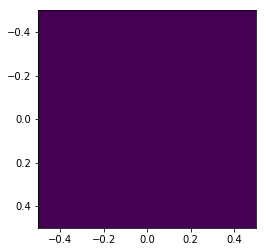


Filtro Corrente: 
 [[[-9.73172093e-02 -9.04847283e-02  1.83640962e-01  1.03569249e-01
    2.77778050e-01  1.13839797e-01 -3.10453265e-02 -7.17481150e-02
    3.47799489e-02 -2.40544675e-02 -1.57264082e-01  2.86223548e-01
    1.73906399e-01  2.48342205e-02  4.82880903e-02  1.21376747e-02
    1.73959999e-01  1.42274007e-01 -1.31048157e-01  1.06128767e-01
    1.07437119e-01 -1.46657704e-01 -1.59441515e-02 -2.13099347e-02
    1.24437873e-01  6.99274209e-02  1.21217435e-01 -1.88229296e-01
   -2.76729890e-02 -1.22868294e-01 -6.60853687e-02  1.35527127e-01
   -1.34652523e-01 -7.47018874e-03 -5.46990618e-02 -1.65166748e-01
   -1.76147867e-02 -1.05599197e-01 -6.11259424e-02 -2.03028464e-01
   -1.60781230e-02  8.20958747e-02 -1.41047193e-01  7.97682297e-02
    6.71360672e-03 -2.68497570e-02  1.66683758e-03 -1.02090978e-01
    1.90170932e-01  2.60208076e-01  9.26410737e-02  6.86086608e-02
    2.01431810e-02  4.17447779e-02  2.61683788e-01  1.26368037e-01
    9.43837916e-02 -2.78021466e-01  2.3476

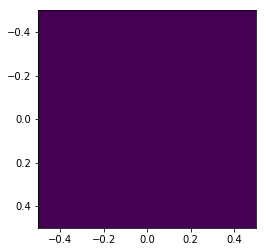


Filtro Corrente: 
 [[[-9.11690478e-03 -1.62641023e-01  1.58205937e-01  1.73506337e-01
    2.71672990e-02 -1.63017728e-01 -5.90003903e-02 -4.67298087e-02
    1.27956211e-01 -8.32142714e-02  1.35405013e-01 -8.17794558e-02
    1.29809224e-02  3.20215287e-02 -1.56613520e-01  2.58057423e-02
    3.19851418e-02 -1.55094418e-01  4.71470521e-02 -8.99291720e-02
    2.41846259e-01 -2.78406767e-01  2.55022108e-01  9.92358973e-02
   -4.38448411e-02 -1.02642362e-01 -2.04146471e-04  7.79911405e-02
   -1.81314665e-02 -7.88299053e-02 -1.54585116e-01 -1.07096787e-01
   -2.43023800e-01  4.25442207e-02 -6.36944090e-02  1.35743780e-01
    3.78553044e-01 -2.88082332e-01 -7.63426238e-02 -8.56738658e-02
    1.90662639e-01 -1.12818600e-02  7.31881225e-02  7.46968801e-02
    1.06877032e-01  3.77029256e-02  8.66930799e-02  7.71187188e-03
   -1.29589098e-03 -2.04286891e-01  6.84619820e-03  1.64384763e-01
   -1.28274198e-01  1.02763034e-01  1.87545528e-01 -5.56981046e-03
   -1.13704244e-01  2.11520453e-01 -2.6577

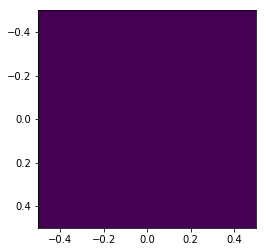


Filtro Corrente: 
 [[[-0.12271058  0.1456686  -0.13797202  0.02824132 -0.01938285
    0.00085027  0.02662816  0.21519374 -0.01846758 -0.07539936
   -0.02892237  0.33491205  0.23514892  0.01942016 -0.0136412
    0.02136576 -0.26099059  0.06521853  0.09644171  0.05998614
    0.0477424   0.14526107  0.05661627  0.10010088 -0.17959881
   -0.00465013 -0.0544636   0.12939744  0.18766749  0.22412534
    0.0487242  -0.0004081   0.09380187  0.06108881 -0.09290359
    0.12913833 -0.1978896  -0.04732705 -0.11167671  0.01924171
   -0.13533534  0.01974015 -0.05996984 -0.02202514  0.05972524
    0.08391146  0.03416561 -0.07263808 -0.08669813  0.03458111
   -0.06208942 -0.06207229  0.06333884 -0.03489271 -0.03932183
    0.23097997  0.17512275  0.17930526 -0.05391524 -0.04059121
    0.05598597 -0.25828788 -0.23606643 -0.09846972 -0.16259303
   -0.18465485  0.00830751 -0.08900261 -0.11862287  0.21786575
   -0.09766404 -0.17838672  0.0753224   0.04971623 -0.16213463
   -0.07240725 -0.17964473  0.059917

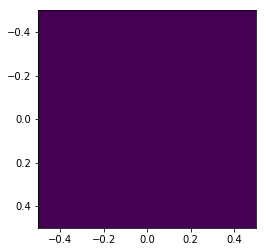


Filtro Corrente: 
 [[[-0.07976361 -0.05758822  0.07695923 -0.05511088  0.11417363
    0.02074406  0.12733072  0.26792954 -0.03185713  0.11959332
    0.34185292  0.066262   -0.24730867 -0.11442935 -0.07356252
   -0.12810933  0.16413299 -0.00589802  0.13450076  0.01118742
   -0.11780227 -0.21649448 -0.01821135 -0.00530346  0.16677972
   -0.12340453  0.12850424  0.16694551  0.12524302 -0.03328516
   -0.08095353 -0.18409049 -0.16094649  0.04227432 -0.04430269
    0.07586684  0.04275421 -0.05267174  0.06023364 -0.15991211
   -0.2178786  -0.23684326 -0.16877495 -0.21467764  0.26237285
    0.02018003 -0.28958698 -0.30665658 -0.38680197 -0.18007535
   -0.00551806 -0.0386622  -0.14971435  0.16968251  0.04770815
   -0.0559819   0.01040884 -0.07381534  0.23126539 -0.02464408
    0.02799085  0.16102296 -0.17405668 -0.11606264 -0.01423997
   -0.00333727 -0.08198323 -0.03749973  0.05236378 -0.20333743
    0.0489483   0.15476429 -0.02152105 -0.3202883  -0.11959276
   -0.10654473 -0.0626521  -0.12120

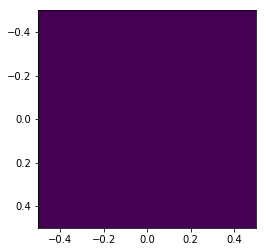


Filtro Corrente: 
 [[[ 0.04137929  0.14675407  0.36542956 -0.15499274 -0.05340927
   -0.12912488 -0.01694731  0.00365424 -0.26181282 -0.06916765
    0.08327494  0.26238964  0.12621079 -0.15601207 -0.11974345
    0.19358821 -0.02467332 -0.10794945 -0.02696282  0.3043049
    0.04078302 -0.09007331 -0.0706564  -0.06263487  0.10185734
    0.1338777  -0.0183557  -0.00442168 -0.12840747  0.06282273
    0.10219753  0.13332508 -0.06582997 -0.05340273  0.0341149
   -0.13511496  0.11063078  0.09390221 -0.01651334 -0.11245587
   -0.02184039 -0.05386359 -0.00865015 -0.06904584  0.0609848
    0.07720438  0.1619793   0.29074384 -0.28349207 -0.16488592
   -0.20514086  0.01674043 -0.13241172  0.06078736  0.08652872
   -0.06867255 -0.05394919 -0.22722261  0.10888291 -0.02991921
    0.17685566 -0.0217339   0.04842996 -0.01777042 -0.09104247
    0.02990431  0.0922922   0.13348529  0.0289582  -0.01743663
    0.08400035 -0.10012156 -0.08115925  0.07092683  0.04868414
   -0.10978084  0.15946242 -0.05621528

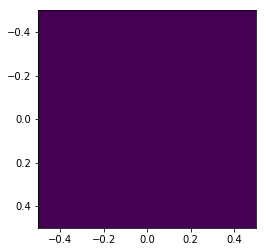


Filtro Corrente: 
 [[[ 6.45196589e-02  5.30059180e-02 -3.85540777e-02  4.46551262e-02
   -3.54252379e-01  2.66616209e-02  9.41561421e-02  3.08235250e-02
   -4.97488025e-02  3.80771126e-02 -1.02948286e-01 -1.43482490e-01
   -3.75356057e-02 -1.20899306e-01  2.16761553e-01 -6.67649864e-03
    2.97624614e-01  3.20245107e-02 -7.15084096e-02  6.44137733e-02
   -9.85494014e-02 -2.89190041e-01  1.07658098e-01 -4.85684607e-02
    2.51157840e-02 -2.08780907e-01  4.21127426e-02  3.42442858e-02
   -4.16026990e-02  1.72994971e-01  2.30361528e-02  2.07602718e-01
    2.22409948e-01 -2.05318702e-01  5.60053489e-02 -1.68358985e-01
    7.22830066e-02  7.38357204e-02 -9.82586137e-02 -2.20506989e-01
   -4.17844736e-02 -2.12672867e-02  1.80752431e-01 -4.40166859e-02
   -2.65600197e-02 -2.25083644e-01 -1.00850961e-02  7.07915252e-02
    5.16144151e-02 -7.39151575e-02 -1.84634070e-01 -1.18728501e-01
   -9.03404999e-02  1.09741101e-01 -8.83571705e-02  1.54105229e-01
   -6.55262959e-02  6.24748152e-02  7.5382

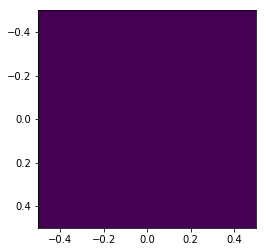


Filtro Corrente: 
 [[[ 0.01212017  0.11440455 -0.05752096  0.14191247  0.15774549
    0.02392778 -0.0887699   0.11046087 -0.25084518 -0.04767905
    0.26732648 -0.01114477 -0.14818343 -0.08467741  0.20679288
   -0.15035011  0.09803652  0.02362885  0.04147807 -0.1986829
    0.07962313  0.14254457 -0.19787913 -0.04742849 -0.24315571
    0.02865341  0.027321   -0.17057821 -0.03375762  0.01563647
   -0.02388565 -0.24581048  0.09512223 -0.02888683  0.06747653
    0.14618451 -0.0082982  -0.0572039   0.13087942  0.05891782
    0.07141818  0.19573335  0.12912108 -0.03515851 -0.02884395
   -0.06335396 -0.08041055 -0.11962224  0.12395624 -0.10975875
    0.00796459  0.0023953  -0.00093491 -0.05860946 -0.05587662
   -0.05177481 -0.17244917 -0.1559398   0.03328054 -0.0619286
    0.05527551  0.07749962 -0.17325117  0.06412187 -0.00348217
   -0.08717338 -0.03275563 -0.16952028  0.13041025  0.22895883
    0.00890521 -0.1984098  -0.12895451 -0.00981571  0.15016192
   -0.07731542  0.03985805 -0.1667962

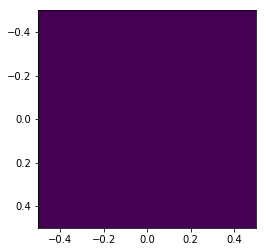


Filtro Corrente: 
 [[[-0.12029606 -0.23243942  0.09370911  0.18036101 -0.08721292
   -0.1951534   0.07214998  0.04014681 -0.12241146 -0.0811439
   -0.04748326  0.13052065  0.00134262  0.05857445  0.03055819
    0.11981594  0.02469092 -0.12454782  0.10899585  0.00424855
   -0.00380528 -0.00152211 -0.02279175 -0.02374225  0.17358534
    0.09148464 -0.10382977  0.23935749  0.16290953 -0.0364132
   -0.06251614  0.06190133  0.17951727 -0.02782374  0.04216529
    0.08969443  0.01570608  0.03457997 -0.18006163 -0.03266882
    0.05037436 -0.16604387 -0.03229651 -0.22076125 -0.08208182
   -0.00529368  0.08351249  0.19704702 -0.11542958 -0.15452844
    0.1279847   0.07361507 -0.04188655  0.14281557  0.02747427
   -0.02056799  0.08777961 -0.07527503 -0.0554718   0.17232257
    0.03609565  0.05060256 -0.17765936 -0.00137886 -0.05115995
    0.05634772  0.05953651  0.06223824  0.1127108   0.08670339
    0.26316416  0.16766547  0.02998328 -0.13968722  0.08108784
    0.00380044  0.00822102  0.1354837

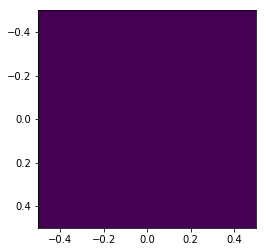


Filtro Corrente: 
 [[[-2.95861426e-02  1.55418250e-01 -8.14762606e-02  3.67408408e-03
    1.12862410e-01 -1.01816182e-01 -1.86060121e-01  1.97498983e-02
   -6.57173834e-02  3.83233409e-02  4.10692020e-02  2.28467369e-01
   -1.92245312e-01  3.99720186e-03 -1.30172381e-01  8.08054158e-02
   -2.20172329e-01 -1.14165298e-01 -1.42166159e-01  6.08863543e-02
    1.42769514e-01  9.00430057e-02 -2.57800469e-02 -1.75000600e-01
    3.11734301e-01 -3.08783460e-01  2.19775203e-01  9.34299448e-02
   -4.62987863e-02  9.75519515e-02 -1.57370140e-01 -1.68959923e-02
   -2.41547262e-01 -2.34314092e-01  4.39045759e-02  1.46463701e-03
   -1.50826444e-01  1.99845304e-01  6.23195595e-03  1.00981647e-01
   -1.01596469e-01 -4.96675467e-02 -1.65998584e-01 -1.00457866e-01
    2.62949080e-01  1.82121767e-01  2.14840870e-02  9.74624633e-02
    4.16588761e-02 -5.56937107e-02  1.69286058e-02  7.07052004e-02
   -1.38750464e-01  2.25612600e-01  6.23809709e-02 -3.03367631e-02
   -2.76272638e-01 -1.62012506e-01  2.1491

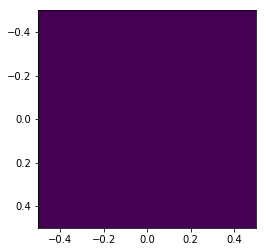


Filtro Corrente: 
 [[[ 9.00291635e-02  1.82897199e-01 -1.19760844e-01 -6.96472487e-02
    2.67372587e-01  5.05794137e-02  7.37657862e-02  4.02193989e-03
    1.55903193e-01 -8.62765311e-02 -2.98799050e-02 -1.16149622e-02
    1.58523378e-01  7.06474885e-02 -6.71135120e-02  2.46793188e-01
    2.65552358e-01  5.38665725e-02 -2.65880885e-01 -1.41595054e-01
   -1.16818107e-01 -2.23229483e-01 -1.86911445e-01 -1.28442641e-02
   -1.94777529e-01  5.36005221e-02 -1.88053368e-01 -3.54479221e-02
    6.88750391e-02 -7.87019282e-02 -8.85528086e-02 -2.87551813e-01
    3.21439910e-01  1.41868494e-01 -3.84715844e-02 -1.77707525e-01
   -1.39495943e-01  6.82272360e-02 -1.20023236e-02  7.43201545e-02
    5.29889354e-02 -1.44479494e-01 -1.09597568e-01  5.21342379e-02
   -4.89820640e-02 -8.62275066e-02  2.59194790e-01 -7.86421893e-02
    2.47143966e-02  3.59172273e-02 -9.34265413e-02 -6.05112231e-02
    7.59997313e-02 -1.61720767e-01 -4.63031807e-02 -1.44082014e-01
    3.76517609e-02 -1.26091356e-01 -8.2519

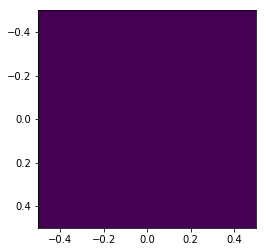


Filtro Corrente: 
 [[[-0.10848554  0.15056672 -0.00828291  0.20550899 -0.06250245
    0.26953789  0.07894411  0.09549775 -0.01278167  0.03848593
   -0.04050952 -0.10620639  0.03812174 -0.20915556 -0.10882728
    0.05214183 -0.07174761 -0.21518692  0.10201784 -0.03273709
   -0.0741535  -0.00220797 -0.14356476 -0.07092204 -0.21721027
   -0.07238739  0.08241418 -0.03127144  0.05895721 -0.13116268
    0.06899706  0.21701939 -0.14011557 -0.26296581  0.13930177
    0.0009431   0.06087369  0.09885161  0.38112261  0.07699228
    0.11926681 -0.06906678 -0.06867785  0.13851448 -0.22345703
   -0.09892617  0.04514574 -0.06939596 -0.24578876 -0.0367583
   -0.01106344  0.10999955  0.17015154 -0.15559844  0.16163592
   -0.16643834  0.12665673 -0.10883267  0.07962722 -0.13432915
   -0.27402009 -0.10644375 -0.11348336  0.10658305  0.11754145
    0.00926683 -0.11245295  0.1298165   0.04717524  0.05895113
    0.15909733 -0.13999626  0.25932748  0.00065289  0.21348317
   -0.05523766 -0.06438745 -0.238111

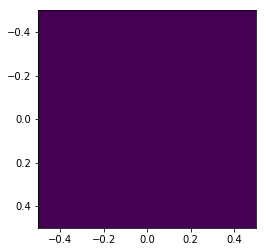


Filtro Corrente: 
 [[[-0.14932215  0.03905102  0.04108246 -0.05125606 -0.06158722
   -0.08729406 -0.01357884  0.05762946  0.03229415  0.2705726
   -0.09674173 -0.13929397 -0.24421517 -0.08936061 -0.14110604
    0.15746566  0.14719106  0.12294631 -0.08764163  0.00983741
    0.1112767  -0.06814087  0.05711489 -0.02983578  0.01496682
    0.07351911  0.00376717 -0.18691448 -0.10912847 -0.1534581
    0.03522846  0.13348152 -0.07111271  0.13614241  0.03589766
   -0.0674552   0.07255354  0.03095279 -0.15610785  0.13055438
    0.19574236 -0.02074719 -0.00217177  0.23061979 -0.06983267
    0.05663656 -0.23478207  0.07008837  0.13858524  0.06587389
    0.01654496 -0.15938019 -0.28932869  0.06992762  0.1837254
    0.06473934  0.08832827  0.01614147 -0.16047441 -0.09712675
    0.17139899  0.04653453 -0.21044863  0.0091719  -0.00097692
    0.34977737 -0.0322686  -0.04354975  0.1015395  -0.12458301
   -0.13745426  0.13933105 -0.17439934  0.08318041 -0.18723615
   -0.07803427 -0.02154346 -0.26840723

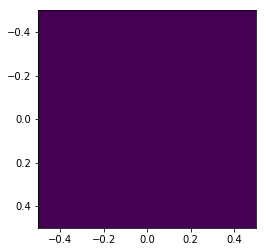


Filtro Corrente: 
 [[[-0.01112715 -0.14125318 -0.15317705 -0.21497403  0.13414056
    0.00952587 -0.08231798 -0.20733534  0.01208767 -0.09872142
   -0.10965531  0.0935109  -0.00570423  0.16701117 -0.05459115
    0.05917663 -0.18562997 -0.14908792 -0.0035519   0.1003855
    0.16960036  0.07109892  0.09393735  0.09523913  0.17273778
    0.14076986  0.01267707 -0.16823679  0.14033388 -0.08974627
   -0.16984605 -0.15156537  0.07169736 -0.10051396 -0.13397021
    0.04588534 -0.17026943  0.02376046 -0.09546597 -0.11950877
   -0.01916302  0.14880469 -0.11872195  0.01144692  0.21426854
    0.17458132  0.0446199   0.20243523 -0.04424556 -0.21609289
   -0.1356076   0.12080696  0.02197172 -0.42545243  0.13911649
   -0.09944057  0.04829838  0.03052111 -0.23717272  0.01975883
   -0.03683758  0.03501157  0.03197498 -0.09505391  0.08947013
   -0.19362023 -0.00226558 -0.11175513  0.02508682  0.00311626
   -0.08024526  0.09509727 -0.07781252  0.03696516  0.11750211
   -0.18779129  0.1619018   0.333420

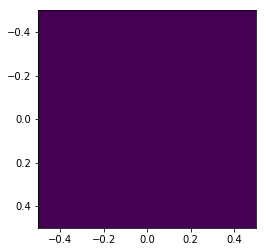


Filtro Corrente: 
 [[[-0.05932696 -0.14296805  0.01761901 -0.12927283  0.10636027
    0.16353053  0.07710876 -0.15653834  0.09198331  0.17585827
   -0.30635779  0.12604036  0.25057384  0.04939889 -0.17962871
   -0.10731961 -0.02782563  0.14761578  0.26129649 -0.278313
   -0.17336666 -0.04927936  0.18862653  0.14597799  0.06859145
   -0.34079566  0.00311859 -0.0466605   0.02393778  0.20136722
    0.02445198 -0.06967697  0.04480611 -0.08366496 -0.14748706
   -0.01017945 -0.04443958  0.1332103  -0.06578103  0.03824268
   -0.18350406  0.04259662  0.10671176  0.12875194  0.18227662
   -0.12954739 -0.01167004  0.15974566  0.04731783 -0.16013206
    0.00867541  0.07792507  0.07579407 -0.0528077  -0.1011799
    0.09174884 -0.13518655  0.09916064  0.10572095  0.06646856
   -0.02849398 -0.02620676  0.14476781 -0.00051973 -0.02401247
    0.0054376   0.02112025 -0.09971185  0.01338513 -0.29754633
   -0.14020533  0.08387689  0.02412968  0.12253395 -0.06055116
   -0.08334278 -0.12355426 -0.14541183

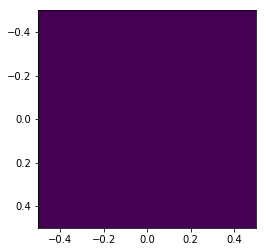


Filtro Corrente: 
 [[[ 0.02316741  0.14048334 -0.02545872  0.03870714 -0.06930065
    0.12722677  0.23231121 -0.00964502 -0.09517105 -0.24467974
    0.01169603 -0.02617417 -0.12149309 -0.03254693 -0.03606404
    0.10977595 -0.11946324 -0.07501016 -0.00277416  0.06613975
   -0.02154778 -0.07958076 -0.01238219 -0.04900154 -0.14291746
    0.16321499 -0.14312218  0.15941708 -0.05373689  0.01134879
   -0.03994509  0.07580806  0.01171255  0.16094792  0.39320669
    0.28724696  0.04082972 -0.02841252  0.01798552  0.02678655
   -0.02240201 -0.01797481 -0.02210465 -0.01476122 -0.02036809
   -0.12218773 -0.10402504 -0.03697041  0.06069704 -0.23942828
   -0.25289549 -0.28427058 -0.04962374 -0.175811   -0.07401636
   -0.15832303 -0.07563171  0.08345421 -0.19001981  0.03456922
    0.21319385  0.09575715  0.16200292 -0.06346865 -0.14933116
   -0.06499665 -0.14275762  0.21174419  0.23957826  0.11018015
    0.05018513  0.21859093 -0.15496887  0.06285738 -0.23623961
    0.13423042  0.08870246 -0.19811

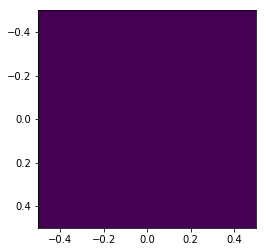


Filtro Corrente: 
 [[[-0.12251235  0.16057765 -0.05699783 -0.03489741 -0.18549304
   -0.00633624 -0.25957362 -0.2250229   0.00841995  0.03400331
    0.10638952 -0.05565748 -0.08266392 -0.19693182  0.01790995
   -0.00448404 -0.31760959  0.02482891  0.10025388 -0.16516046
    0.14179505 -0.07455676 -0.02849789  0.10207569 -0.02278354
    0.17860079  0.02725655  0.0921368   0.01512016 -0.07122
   -0.09263286  0.01493941 -0.13900424 -0.02149916 -0.00091982
    0.26074013 -0.00220303  0.0517699   0.11888331 -0.17093166
    0.063231   -0.14378661  0.20545504  0.02334997  0.10825103
   -0.06346635 -0.37782041 -0.07653362  0.20336192  0.10916105
   -0.04000209  0.01395408 -0.04875736 -0.06664898  0.27776605
   -0.02784554 -0.08886052 -0.04998939  0.23474227 -0.05727036
   -0.07138128 -0.00146317  0.21189918 -0.00618986 -0.02319943
    0.07947191 -0.12957834  0.01616156 -0.01287534 -0.10031869
    0.18907813  0.0205365   0.1706508  -0.08807856  0.24180148
    0.00813601  0.17216703  0.01790401

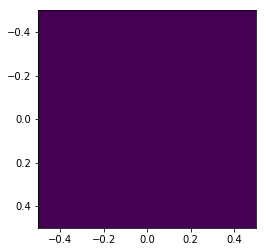


Filtro Corrente: 
 [[[-0.01917182 -0.28543694  0.07861041 -0.34864474  0.16513634
   -0.02984828 -0.16377023  0.0660026  -0.03336319 -0.28731394
   -0.31131788  0.02022366  0.21382789 -0.21403739 -0.09779138
    0.10072359 -0.13535361  0.24102442 -0.0175641  -0.11378958
   -0.18961324 -0.07383758  0.16296348  0.21754429 -0.06682484
   -0.01422544  0.06964619 -0.07000694  0.02322341  0.22115699
    0.11155204 -0.06323926  0.18161437  0.04028396  0.14541532
   -0.19287426 -0.33099672  0.30487233  0.16796234  0.0187569
   -0.13502551  0.21922069  0.03594089 -0.14906101 -0.17555007
   -0.19408981  0.00847678  0.0986926  -0.01529903 -0.16404349
   -0.02174423 -0.11563483  0.16201704 -0.04445227  0.08895472
   -0.16136143  0.01818132 -0.11299214  0.10388186  0.10127094
    0.0116175   0.08367942  0.14401825  0.05358712 -0.01902035
    0.10111103  0.18038695 -0.0516268   0.1267469   0.04533693
   -0.21876691  0.13260249  0.05982073  0.02606021 -0.23039968
    0.14221202 -0.0358105   0.166755

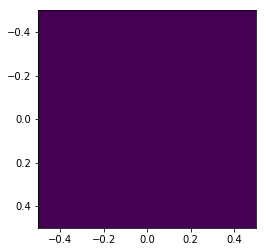


Filtro Corrente: 
 [[[-2.22002383e-01 -5.91577634e-02 -1.32689756e-02  2.82381911e-01
   -8.64032635e-02 -1.67414402e-02 -1.68379492e-03  1.69935320e-01
   -3.64577383e-02  5.72992563e-02  1.71590772e-01 -8.21108343e-02
    5.27356765e-02 -1.09238756e-01  7.73732939e-02 -1.20508842e-01
   -3.44720478e-02 -2.89718701e-02  6.49512360e-02  1.44045183e-01
    1.59434962e-02 -8.99639240e-02 -7.81986015e-03  1.36944931e-01
    3.58515904e-01  1.90266560e-01  1.75262775e-01  3.37011177e-02
   -4.02761821e-02  3.30811138e-02  1.38021563e-01  3.62325154e-02
   -1.34954008e-02  1.18634847e-01  1.18113437e-01  4.44647247e-02
   -3.19767674e-04  3.44949318e-01  4.65269855e-02 -5.83392131e-02
    1.75514980e-01  8.73648220e-02 -2.79560933e-02  1.58912352e-01
   -5.98862731e-02 -3.57387137e-02  2.46570560e-01 -5.95660220e-02
    1.27232788e-01 -1.84622230e-01 -2.68558513e-02 -3.14017844e-02
   -1.95962660e-03 -2.88589600e-01 -4.10556576e-02  3.39857772e-02
   -2.16047186e-02  7.61361274e-02  6.6010

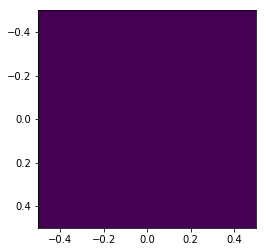


Filtro Corrente: 
 [[[-5.00709582e-02  1.06844849e-01  1.31397684e-01 -2.27618894e-02
    1.71669306e-01  2.51426778e-01 -1.27546274e-01  2.37559090e-01
    1.38755520e-01 -6.75996723e-02  4.18838301e-02 -1.90257140e-01
    1.10349179e-01  2.77734922e-02 -8.33454750e-03  8.38347122e-04
    1.93812832e-01 -1.66270212e-02 -2.55977262e-01 -8.17931920e-02
    4.01347535e-02 -4.80427139e-02  6.44230010e-02  7.40072011e-02
    2.54788240e-01  1.16423724e-01  1.91188174e-01 -3.46794225e-02
    4.63268043e-02  2.42984279e-02 -1.91686618e-01  3.47803818e-02
   -1.18563505e-01 -8.25095187e-02 -1.34034264e-01 -4.62547412e-02
    8.33011172e-02  1.02458116e-01 -4.17700834e-02  1.48272168e-01
   -9.71589999e-02 -1.26400691e-01  5.28934956e-05 -2.30921084e-01
    3.55821410e-01 -1.12981771e-01  7.79725189e-03  1.98621230e-02
   -1.31386624e-02  4.86893662e-02 -1.19427122e-02 -3.55609876e-02
    3.95885310e-02 -2.63570460e-01  2.72158314e-02 -2.25978553e-02
    7.19642239e-02  8.04813914e-02  2.8372

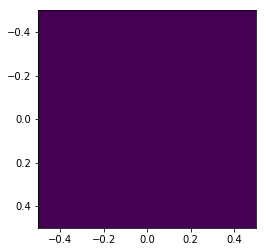


Filtro Corrente: 
 [[[ 4.03495893e-02 -7.92736582e-02  1.59976364e-01  5.22773835e-02
    8.21353637e-02 -2.34291482e-01  1.94640639e-02  5.21193375e-02
    2.56356678e-01 -1.08269387e-01 -1.59765280e-01  1.42275349e-01
   -2.43025662e-01 -9.53089999e-02  2.45516672e-02  1.37385840e-01
   -9.84194684e-02 -3.05821830e-02  1.52780026e-02 -2.05005663e-01
    2.20533687e-01  1.23174425e-01 -1.02792832e-01 -5.17240749e-02
    1.60641442e-01 -2.23840348e-01  9.61174681e-02  7.50312500e-02
    1.18477491e-01  9.18065526e-02  1.67902603e-01  8.29981226e-02
    1.39458801e-01  7.12408651e-02 -9.80851316e-02  3.39628449e-02
    2.05542092e-01  2.94757241e-02  2.61281730e-02  8.02196434e-02
   -2.22404741e-01 -2.00840960e-01 -2.26155404e-01 -2.30837131e-01
   -6.26510686e-02  7.41270961e-02  2.54120658e-02  2.61947939e-02
    8.04004572e-02  4.83746024e-02  1.22764021e-01  1.33699419e-01
    1.54702898e-01  1.33617393e-01 -1.05735042e-02  4.51573869e-02
    1.59427198e-01 -5.05558862e-02 -1.3025

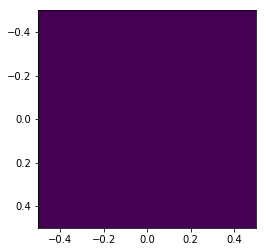


Filtro Corrente: 
 [[[ 1.41178670e-01 -1.33082947e-01  8.05538269e-02 -6.22948882e-03
    3.66304231e-02 -5.30680722e-02 -4.69902395e-02 -1.56461776e-01
    2.26768292e-01  1.13850569e-01  2.06191497e-01 -3.30367128e-02
   -7.14135231e-02 -1.17988757e-01 -1.57357861e-01 -1.47766728e-03
    8.74753787e-02 -7.79283464e-02  1.76988201e-01 -3.12156512e-03
   -1.45136073e-01 -1.98484550e-01 -5.74707440e-02 -8.12107598e-02
   -2.25868291e-02 -1.67228320e-01 -9.96630788e-02  6.53984892e-02
    6.32542477e-02 -1.38755411e-01  3.49532167e-02  1.98513327e-01
    5.10457187e-02  1.17517187e-01 -9.00881909e-02  5.30292441e-02
    3.44886531e-02  1.11233268e-01  1.63936826e-01 -3.33185454e-02
   -8.40229023e-02 -1.48031972e-01  1.06860000e-01 -4.23543956e-02
    6.24937845e-02  9.79261017e-02  8.30120830e-02  1.51202079e-01
    4.21412465e-02 -6.25152736e-02 -3.39872643e-02 -9.63935448e-02
    3.75699609e-02 -2.14728913e-02 -1.00710971e-01  6.32681095e-02
    7.07055969e-02  4.25940623e-03  1.4307

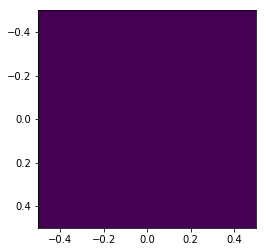


Filtro Corrente: 
 [[[-8.20884358e-02  1.61467388e-02  1.87470144e-01  1.45826537e-01
    8.96135249e-02 -6.60299854e-02  1.64619963e-01 -1.64358406e-03
   -2.93663656e-01 -1.08991505e-01  2.07972395e-01 -1.83646832e-01
   -8.08091996e-02  1.66696094e-01  3.90533059e-02  7.33990914e-02
   -1.49081487e-01 -1.33096921e-01 -8.58352973e-02  5.93253278e-02
    9.81677533e-02 -6.88758158e-02  1.67929298e-01  1.39073573e-01
   -9.01326699e-02 -7.33442598e-03 -1.11192500e-01 -5.72653241e-02
    1.08076170e-01 -4.64502338e-02 -1.16938353e-01 -7.39018747e-02
   -1.21927669e-01  9.82032835e-02 -2.25322961e-02 -3.30608680e-01
    3.11772551e-02  6.70317400e-03 -8.55014545e-02  1.44730025e-01
   -4.11714456e-02  6.63293762e-02  6.33853847e-02  1.92315575e-02
   -5.92700990e-02 -6.71536503e-02  4.37281868e-02  4.11733400e-02
    5.03047579e-02 -5.45876393e-02  3.41019789e-01 -3.64575438e-02
    1.38905692e-01  3.73895678e-02 -7.26506397e-02  1.82393568e-01
   -1.87420640e-01 -1.60245257e-01 -1.9528

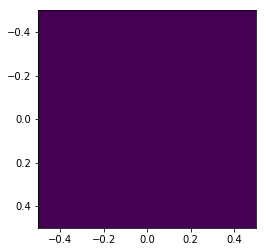


Filtro Corrente: 
 [[[-8.95941021e-03  1.03029004e-01  7.08677162e-02  7.79442823e-03
    4.81491659e-02  9.81103051e-02 -3.06311716e-01 -1.41820312e-01
   -1.37066149e-01  2.43605374e-02 -5.28523582e-02  1.37077061e-01
   -1.95181865e-02 -5.90324680e-02 -2.21441542e-01 -1.36498423e-02
   -2.42107766e-01  1.54547546e-01  1.99161065e-01  2.01164717e-01
    1.74154223e-01 -1.40281045e-02  2.15417688e-01 -1.42010269e-03
    5.81039041e-02  8.23754794e-02 -1.86436921e-02  5.90056095e-02
   -4.59576243e-02 -1.28789818e-01  2.54928618e-02 -3.70242047e-02
   -1.18246139e-01 -7.82815559e-02  2.56058999e-01  1.11713390e-01
    5.57001853e-02 -1.59238863e-01 -8.36477229e-03 -1.04666757e-01
    1.17475724e-03  1.18898752e-02  2.33730267e-02 -8.12755469e-02
    4.31583151e-02 -2.43845497e-01 -1.43485186e-01 -5.67412020e-02
   -1.65462510e-01 -1.79295153e-01  3.16431232e-02 -3.69193520e-02
    1.27721031e-01 -2.38907658e-02  2.32095020e-01  5.68625791e-02
    1.36665539e-02 -2.88612468e-02  4.8004

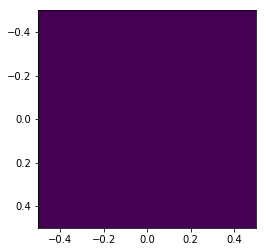


Filtro Corrente: 
 [[[-0.09525423 -0.12929018 -0.23335227 -0.28459664  0.1089092
    0.20816434 -0.02602722 -0.04193646  0.04965214 -0.10989938
   -0.07236723 -0.01349406  0.06810019 -0.09898598  0.16305083
   -0.17661038 -0.00216308  0.02308287 -0.03712998 -0.00796
    0.03549673 -0.05477953 -0.03008672  0.07361591  0.11334486
    0.11694061 -0.14018953  0.11497317 -0.03200081 -0.08578462
   -0.06948041 -0.03325727  0.04199556  0.18376562  0.02176856
    0.04993591 -0.02933971  0.06365602  0.1306098   0.0508522
   -0.05672148 -0.36055654  0.00414931  0.10751175 -0.06120198
   -0.16857218 -0.13913602  0.37706616  0.05287705 -0.05648914
   -0.10835918  0.15608229 -0.17952703 -0.06245617  0.139203
   -0.17716865  0.06788226  0.32993041 -0.03608847  0.009181
    0.01921776  0.03184635 -0.19400882 -0.0894841   0.19354607
   -0.08017925 -0.0270594   0.24417409  0.14018857 -0.05192462
    0.14846768  0.04987661  0.01698597  0.47282451  0.07521589
   -0.17914538 -0.01618761 -0.11128866 -0.02

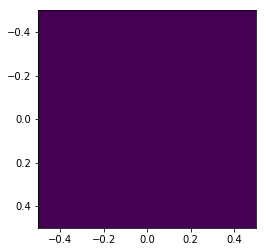


Filtro Corrente: 
 [[[-1.46792699e-01  5.24177524e-02  1.60314350e-01  9.29788471e-02
   -1.43859763e-01  1.32053170e-01  2.26683334e-01  1.13090549e-01
    2.06397717e-01 -7.75551567e-02  1.10181171e-01 -2.84497470e-02
    3.68989529e-02  4.11338997e-02  1.68809424e-01  5.86721638e-02
   -8.85660577e-02  5.02856401e-02  1.19101545e-01 -2.19056894e-01
    2.36235211e-01 -3.65443219e-02 -1.83789701e-02  3.83739347e-02
    2.66869576e-01 -7.00710126e-02 -1.16690382e-01  1.79197276e-02
    1.40374922e-01  1.86003128e-01  2.95633395e-01 -1.67556859e-01
    3.66756297e-02  1.27163666e-01  2.77631445e-02 -4.26315801e-02
   -2.74340944e-01 -8.53456959e-02 -1.23556012e-01  1.10428802e-01
    8.12151940e-02 -2.74682712e-02  1.47011963e-02 -3.63107724e-02
   -1.72646010e-01  5.82406390e-02 -1.35015172e-01 -2.18346038e-01
    2.16044012e-02 -2.82874500e-01 -4.93045891e-02 -1.10814048e-01
    2.73190849e-02  4.06236504e-02  6.84234179e-02  1.24011551e-01
    1.17133840e-01 -1.26037030e-01  4.9873

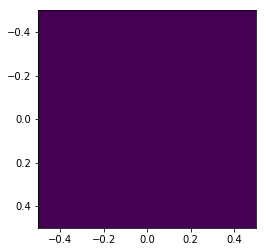


Filtro Corrente: 
 [[[-0.16117296 -0.02474526 -0.20397043  0.0917692  -0.25793338
    0.14048505  0.10046259 -0.03791907  0.38039916 -0.06795734
   -0.24948534 -0.1182682  -0.12288153  0.1968256  -0.06902057
   -0.00324629  0.00537821  0.25549074 -0.00573997 -0.23495289
    0.07022355 -0.01395832  0.16115293  0.09613076  0.08685061
   -0.00771119  0.15497993 -0.08443967  0.00576639  0.02638992
    0.24116983 -0.07116235 -0.00341841  0.13092131  0.03523328
    0.05913494  0.0615599   0.16330319 -0.00739211  0.05782755
   -0.06013785 -0.10122436 -0.06946757  0.06281638  0.16551892
    0.00230886 -0.02898592 -0.06118833 -0.11948193  0.19915601
    0.0038819   0.14305231 -0.05686838  0.0305789  -0.11395027
    0.08443293  0.01199742 -0.11257559 -0.08297332 -0.17732801
   -0.13315674  0.03418548  0.02011065  0.03940123 -0.0563434
    0.16416539  0.04995881  0.10182892 -0.0068494   0.10248556
    0.02385502 -0.0892013   0.00306106  0.08401768  0.16582346
    0.11395925  0.09864373 -0.135194

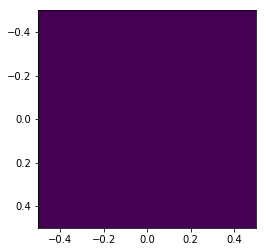


Filtro Corrente: 
 [[[ 0.00402683  0.07090833 -0.0054186   0.19454991  0.12907315
    0.0887953  -0.02594657  0.06839047 -0.1308062  -0.08166083
   -0.15571349  0.04293861 -0.15052458  0.26614707  0.19733516
   -0.02327824  0.21904404  0.09709269 -0.10409643  0.14557817
   -0.26639894  0.01205095  0.06049748 -0.07010849  0.0024584
    0.12467468  0.03936611  0.05029108  0.06265828  0.07959771
   -0.05347562 -0.10056711  0.02070982 -0.02180979 -0.17002914
   -0.03696378  0.14307249  0.04070021 -0.02269049  0.13240505
   -0.05490659 -0.04340237 -0.03687973 -0.09327375  0.03036116
    0.02411898  0.05007671  0.04582385  0.00691241 -0.01810658
   -0.37078494 -0.13356193 -0.03158428  0.19914715  0.06722757
    0.04744163  0.09429776  0.03673056 -0.11656393  0.07691391
   -0.00685403 -0.00041447  0.09466878 -0.11542439  0.0305777
   -0.0109644   0.01768152 -0.13925104 -0.01555033  0.13424664
    0.12363527  0.043328   -0.09468808 -0.14080788  0.33332877
    0.10657    -0.09625151  0.0527459

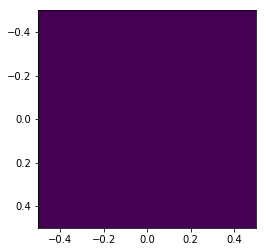


Filtro Corrente: 
 [[[-0.08581005  0.01942168 -0.07226263 -0.10062468  0.06573453
    0.11024163 -0.18884601  0.06450298  0.00484354 -0.11488783
   -0.00419022 -0.16895916  0.02705894  0.22563554  0.08858848
    0.07808526 -0.0724954  -0.03388716  0.06011126 -0.08831548
   -0.00620197 -0.1708644   0.08303999 -0.04521827  0.06222002
    0.06590578  0.12358658  0.04521472 -0.00746666  0.0024155
    0.06925675 -0.07285481 -0.09796689  0.00880656 -0.15030269
   -0.1738165   0.04160682 -0.09559704 -0.0526712  -0.1528399
    0.00771949 -0.08596499 -0.07515399 -0.08386152  0.08365591
    0.0158346   0.12842454  0.1899178   0.10082695  0.21050142
    0.06102101 -0.03202816 -0.15411249  0.03733148 -0.15408078
   -0.0390463   0.08440148 -0.12938633  0.20092212  0.02759936
   -0.19670388 -0.03549199  0.06306093 -0.04398131 -0.13391076
   -0.02020738 -0.01598187  0.22768142  0.0570084  -0.33211692
   -0.05792625 -0.04353712 -0.11161631 -0.10320796 -0.22816302
   -0.09133329  0.01254627 -0.0412053

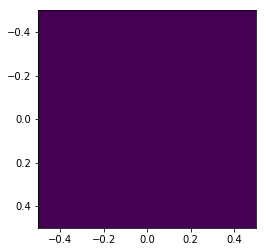


Filtro Corrente: 
 [[[-1.08081699e-01  7.56311609e-02 -1.15860668e-01  1.89426168e-01
    2.41177845e-01 -4.04321795e-02 -2.82965576e-02 -1.69269232e-01
   -8.04674104e-03 -4.20327767e-01  1.86113945e-02 -2.57518413e-02
   -1.71110074e-01 -6.84437672e-02  7.17360269e-02  1.01260122e-01
   -6.60200694e-02  1.10587267e-01 -5.03804937e-02 -1.36966249e-01
   -4.54419233e-02 -1.21431871e-01  7.24756604e-02  1.35388288e-02
    1.23926467e-02  1.21631197e-01  3.05989499e-01  1.96465726e-01
   -1.34142879e-02  1.54675655e-01  2.51707789e-02 -7.85992817e-02
   -1.96998295e-01  1.45227086e-01  8.30514726e-03 -1.14001434e-02
   -9.33513746e-02 -2.43834424e-01 -1.05824375e-02 -4.36787906e-02
   -1.26597178e-01 -1.72384135e-01  2.21876095e-02 -1.98182936e-01
   -3.89960261e-02  4.49672084e-02  1.53994476e-01  3.13085583e-02
    8.93423599e-02 -3.88550852e-02 -6.83344824e-03 -1.30563822e-01
    9.92016742e-02 -2.11942349e-02 -4.60809364e-02  6.20327507e-03
   -1.42205919e-02 -1.53022211e-01 -1.1466

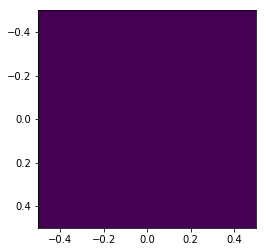


Filtro Corrente: 
 [[[-0.07578317 -0.21791129 -0.03398364  0.16242596 -0.07362065
   -0.06807581  0.20992433 -0.11326755 -0.21840683  0.11118256
    0.03966149 -0.02866184 -0.09532294 -0.12607339  0.08381849
   -0.28681479  0.06193667 -0.02772806  0.12602215 -0.24717711
    0.1422108   0.03710381  0.01034947  0.10304703 -0.12284814
    0.14015312 -0.14097222  0.15447796  0.07663989  0.14100817
    0.12592624  0.13415552 -0.01391499  0.16769573 -0.00651668
    0.06998423 -0.04289494  0.09486004  0.05741254  0.02080885
   -0.02153609 -0.0113516   0.16759261  0.09727464 -0.05318257
    0.14566392  0.00765164  0.02155806  0.30761445  0.09711076
   -0.09052958 -0.10926864 -0.16810137  0.10225452 -0.08004014
    0.185445    0.16795987 -0.09728123 -0.02323711  0.06435954
   -0.01899957 -0.05787847 -0.16835061 -0.1978756  -0.0804582
   -0.30373802  0.0092452  -0.10511498  0.0831531  -0.18123027
    0.2262009   0.11244238  0.05556222  0.05025572 -0.19098976
   -0.18583894 -0.13938421  0.061818

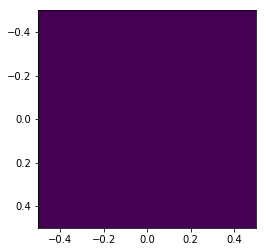


Filtro Corrente: 
 [[[-0.09861484  0.03382596 -0.15196564  0.10610586 -0.05002746
   -0.10539454  0.09267482 -0.03195837 -0.01324291  0.11308466
    0.06427884 -0.11302078 -0.13077663  0.01446608  0.13587912
    0.23995587 -0.11978912 -0.16477305  0.06321892  0.11473227
   -0.18547438  0.02696477  0.06206309  0.20736262 -0.00586605
    0.08812575 -0.26847292  0.06706355  0.05390674 -0.00090274
   -0.16214182  0.00803101  0.04008008  0.03517266 -0.13967812
    0.04938823 -0.04535332  0.08398552 -0.05471309 -0.01460965
    0.04165068  0.07575304  0.11995535 -0.03282005 -0.09301396
    0.14940693  0.04200893  0.08403113  0.07697052 -0.13694321
    0.28737209 -0.06466087 -0.03330392  0.16549696 -0.12207736
    0.07150612  0.14558919  0.00389905  0.14522088 -0.08877846
   -0.05178129  0.15214533 -0.17851845 -0.18463329 -0.23903634
    0.06539334 -0.07317027 -0.11630641  0.07947552  0.00979597
   -0.1699323   0.03834738  0.20282272 -0.09121078 -0.0898289
    0.0644929   0.06599633  0.087742

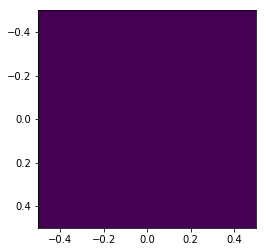


Filtro Corrente: 
 [[[-0.08407354 -0.11681705  0.17215075 -0.19565104 -0.17240615
    0.03212676  0.05251314  0.38750812  0.12040829  0.0514461
   -0.2120491  -0.16277624 -0.18555979  0.03233462 -0.05082873
    0.18295931 -0.08979501  0.25179713  0.11070142  0.08702358
    0.09121339 -0.24522966 -0.0580368   0.05097171 -0.09709954
    0.00118916 -0.17177025  0.12716366 -0.01779518  0.14814488
    0.18795552  0.02656693 -0.12466873 -0.07063524  0.08889854
    0.09172809  0.00611408 -0.18458438  0.09393157  0.07431231
    0.08692815  0.01971283  0.18035681  0.15296421 -0.16993525
   -0.00272731  0.22504653  0.09180975  0.02400261 -0.38867821
    0.03553061 -0.05289419  0.06392119 -0.0016592  -0.03924312
   -0.09289572 -0.09525899 -0.29322731  0.05212109 -0.08921389
   -0.00430753 -0.00760776 -0.00160274 -0.03564061 -0.09061131
    0.17059967 -0.20246529  0.1654116   0.04964031  0.09767506
   -0.09385245  0.09126869  0.18057215 -0.05365878 -0.14903267
    0.12739879  0.0076573   0.094418

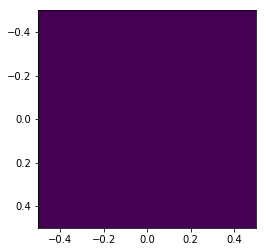


Filtro Corrente: 
 [[[-0.00393309  0.17997866  0.02646794 -0.19367042  0.21626403
   -0.11230647  0.11497713 -0.01018542 -0.06575264 -0.0928934
   -0.11566514  0.05430185 -0.00802605 -0.06178265 -0.0541466
    0.1380587  -0.04587147  0.07372296 -0.01903268 -0.02651537
    0.03276772  0.00988657 -0.26928968  0.12610697  0.01885878
   -0.2480348   0.0321084   0.08969265 -0.05070623 -0.00912258
    0.14728876  0.12457312  0.13887608  0.00209429  0.06062326
    0.07232365 -0.09361226 -0.10435728 -0.15306501 -0.07463815
    0.05174214 -0.07987612  0.02996643  0.07605601  0.01177317
   -0.23325928 -0.25032906 -0.14210121 -0.12612071 -0.11019308
    0.05103938  0.0664519  -0.08081753  0.08625421  0.12557232
   -0.01775998  0.07192718  0.03567457  0.02877433 -0.21829481
   -0.14188572 -0.07938967  0.08284587  0.05500263 -0.06975591
   -0.1361106   0.00920604  0.1877722   0.15566736  0.01647493
    0.06547912 -0.06734763 -0.04637582 -0.06257113  0.05469683
    0.25291235 -0.13152361  0.0383088

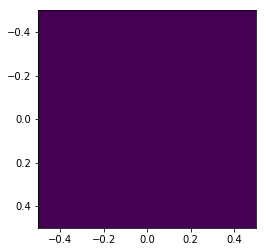


Filtro Corrente: 
 [[[ 0.07466501 -0.02606954  0.04433257 -0.15105102  0.16413106
   -0.00471365 -0.19020257 -0.15159664  0.12687686 -0.11313109
    0.05495041  0.05047672 -0.08714986 -0.15039445 -0.0593423
    0.20458649 -0.009184   -0.01426488 -0.02170442  0.31521999
    0.08063236 -0.01517214  0.00574587  0.3204763   0.13056488
    0.06911543  0.01875893 -0.01886972 -0.12816937 -0.24142907
   -0.02184862  0.06036979  0.22935199  0.04826477 -0.10045735
   -0.07295789  0.06890869  0.06986815 -0.09656403 -0.07284296
   -0.00182946  0.01199356  0.12030002  0.189805   -0.10911485
    0.09455327  0.29555642 -0.06817924 -0.0345416  -0.15052275
   -0.01379585  0.08099764 -0.02445391 -0.21516349  0.03283217
    0.14170088 -0.03484169  0.06136351 -0.08087065  0.0448687
   -0.1935993  -0.06335645  0.09626565 -0.27322787 -0.09403865
    0.07680673 -0.04042509 -0.18545309  0.14647617  0.08367597
   -0.05157951  0.06576467  0.19557424  0.19840807 -0.10469422
    0.02398735 -0.01065781  0.0816690

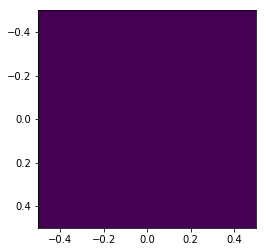


Filtro Corrente: 
 [[[-2.73248434e-01 -1.98352948e-01 -3.76270449e-02  9.66288439e-02
    1.42905415e-01  1.15542846e-01 -3.06996608e-02 -3.37406556e-02
   -1.25720856e-01  2.48518363e-02  1.48203938e-01 -1.60817147e-01
   -1.03785047e-01 -1.07681225e-02  1.12784182e-01 -3.57798781e-02
   -1.79773312e-01 -2.47879217e-01  1.64288175e-01  2.44353336e-01
   -1.41888771e-01 -1.37263609e-01 -1.52529612e-01  1.62574444e-02
    2.66818206e-03 -1.36720426e-01 -5.05138448e-02  5.59703541e-04
   -1.60289289e-01  6.13385360e-02 -9.25306549e-02  2.60764031e-04
    1.15374262e-01 -1.71704562e-01 -1.11692769e-01 -2.48582563e-01
    1.52716831e-02  1.66416841e-01  6.60754030e-02  4.24664778e-02
   -1.39302802e-01 -2.57599543e-02  2.40513350e-01  1.32021056e-01
    1.73415816e-01  4.01457765e-02 -1.08726973e-01 -1.01580018e-01
   -1.07399685e-01 -2.35139042e-01 -1.58532945e-02  2.66387397e-02
   -2.05635006e-01 -2.82530375e-02  1.78037263e-01  4.34849302e-02
    1.55774086e-01 -5.87799877e-02 -1.6719

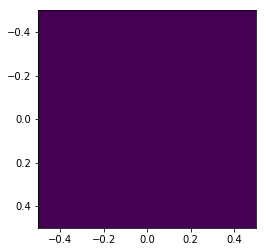


Filtro Corrente: 
 [[[ 0.03409996 -0.01406904  0.11841156  0.02839091  0.09834846
   -0.04370387  0.24409363 -0.09288605  0.22936991  0.01289958
   -0.03362068 -0.0869951  -0.07912399 -0.00271903 -0.06891748
    0.09969894  0.08655925 -0.06699494 -0.07308894 -0.14318297
    0.03843994 -0.27244104  0.01957348  0.20303102 -0.03454431
    0.12521345 -0.15487623 -0.01409129 -0.20641781  0.09871102
    0.06412102  0.12568043 -0.15662139 -0.07043356 -0.03912983
   -0.07655025 -0.04787816 -0.06930415 -0.19530791 -0.01663582
   -0.01673446 -0.07850745  0.1416848   0.07343441 -0.06099705
   -0.10959255 -0.08740755 -0.00173992  0.0837587  -0.10821117
   -0.20653884 -0.0724205  -0.13115532 -0.10224961  0.01400923
    0.02300182  0.21862949 -0.15953121 -0.0710956  -0.12404935
   -0.16912126 -0.06493348 -0.08567437 -0.29455388  0.02404032
    0.19755667  0.10157153  0.01677103  0.15772903 -0.05295826
    0.06013071 -0.04913406  0.16593944 -0.02066263  0.20090508
   -0.02847159 -0.05233152  0.30224

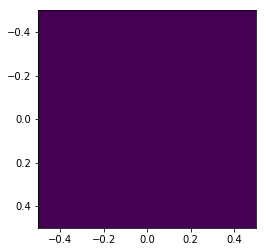


Filtro Corrente: 
 [[[-0.31024039  0.26910954  0.040292   -0.09444665  0.13442652
    0.07044569  0.13731009  0.00862318  0.10181741  0.19887245
    0.11629717  0.06709179  0.23261551  0.01728525 -0.00149841
   -0.14606714  0.10865775 -0.09862018 -0.1328559   0.12676501
    0.04291473 -0.10013759  0.33768416 -0.12673634 -0.06848801
    0.09712933  0.20138473 -0.07727918 -0.33294561 -0.07200363
    0.04384448  0.1064581  -0.00892233 -0.01766064  0.0294322
   -0.01743397 -0.0343582   0.05063636 -0.06253746  0.22923684
    0.07627979  0.0458804   0.07956905 -0.20695181  0.15122869
   -0.18918842 -0.03429188 -0.10738622 -0.11772419 -0.18015855
    0.12715363 -0.25138515  0.10806118  0.05786774 -0.06243711
    0.18609471 -0.0031848  -0.01930553  0.03861029  0.10089381
    0.06775619  0.0089636   0.20733728 -0.23124076  0.04026139
    0.03298684 -0.02085045  0.23767651  0.0815747   0.0600086
    0.07586102 -0.04713243 -0.32196588  0.02700813 -0.0537815
   -0.13183154  0.20188972 -0.06375734

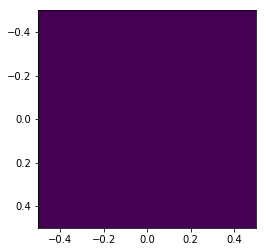


Filtro Corrente: 
 [[[ 2.24914399e-02  2.20273678e-01  1.29177445e-01  2.47469263e-02
    2.85081709e-01  1.80331107e-02  1.80654701e-01 -2.82948883e-02
    4.96961894e-02 -1.13313508e-01  2.48350247e-01 -1.56835456e-01
    9.50431316e-02  2.85516044e-01  1.14363032e-01 -1.47173817e-01
   -1.24238144e-01 -7.66550499e-02 -1.10001484e-01 -2.93150720e-01
    1.62326839e-01  2.63404351e-02 -3.05384118e-02 -1.83052206e-01
   -1.73398577e-01 -3.15649194e-01 -7.23596885e-02 -2.96820492e-01
   -1.41191443e-01 -1.00241548e-02  8.80037815e-03  6.64422241e-02
    1.72645873e-01 -3.82193744e-02 -4.20459056e-02 -1.41980506e-01
    2.48111211e-01 -3.20001660e-01 -1.46165709e-02  1.57831936e-01
   -2.91566251e-01 -1.86255556e-01  1.69595588e-01  1.17922977e-01
   -1.60587163e-01  4.17099670e-02  6.38357157e-02  7.53775546e-02
   -7.58844342e-02  2.95143470e-01  1.28627549e-01  3.04687581e-02
    1.24994124e-01  3.17034117e-02  1.13468794e-01 -1.62040589e-01
    2.59249108e-01 -8.83560937e-02 -8.3411

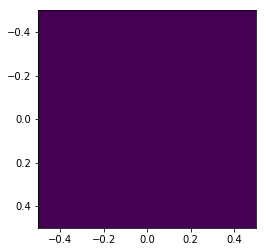


Filtro Corrente: 
 [[[ 0.04506619  0.25589513 -0.23566238 -0.25811175 -0.09196098
    0.06630024 -0.13633236  0.01836056 -0.01336297 -0.13278456
    0.03617968 -0.08523376  0.0990022  -0.01994413 -0.09746016
   -0.00140054 -0.05127554 -0.16383147  0.02480085  0.10484881
    0.09574023 -0.07217427 -0.15141658  0.28044135  0.08544315
    0.09230522 -0.11457234 -0.09511424  0.15728472  0.00838209
   -0.05588167  0.05529047 -0.19899202  0.10189047  0.18056484
   -0.00951381  0.1691338  -0.11469224  0.00774869  0.15623258
    0.20128305  0.11037986 -0.13430752  0.04959421  0.10716553
    0.39025261 -0.08830855 -0.01893789  0.1091241   0.14773469
   -0.20443152  0.12457895  0.08565561 -0.08248539 -0.04907242
    0.21436285 -0.11907768 -0.20835637  0.29629127 -0.17195169
   -0.09062754 -0.23008007  0.02802519  0.08484362  0.09049185
    0.13817571  0.01283013  0.06834922 -0.16700337  0.17754149
    0.0760988  -0.08619582  0.07158986  0.02222658 -0.11289303
   -0.03982054  0.04864102  0.11081

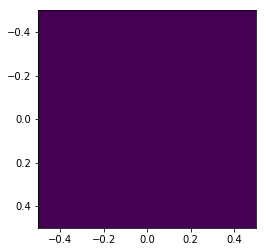


Filtro Corrente: 
 [[[-2.17496023e-01  9.92730362e-02  1.89526410e-02  2.05076837e-01
   -1.12447532e-02  3.85712660e-02 -1.27607706e-01 -8.19381777e-02
    4.68211837e-02  1.84259256e-02 -9.97019308e-03 -3.77670377e-02
   -5.25139865e-02  6.13201179e-02  5.90114072e-02 -1.53920438e-01
    1.85315117e-02 -1.04259003e-01  1.58892189e-01  1.89093717e-01
    2.40543830e-01 -6.88515536e-02 -3.75547763e-02  1.27226514e-01
   -2.04955984e-02 -1.80216917e-01  1.47825564e-01 -2.18159716e-02
   -1.64652833e-01 -4.52633504e-02 -3.74142102e-03 -4.06015714e-02
    1.31233927e-02 -4.41484858e-02  1.08944830e-02  3.65741474e-03
    1.39849845e-01  1.21744922e-01 -2.94414310e-02 -2.45540854e-02
    6.71102433e-02  2.19545570e-02  5.25640664e-02  1.90049529e-01
    2.40966809e-04 -1.36535882e-03  5.41650813e-02 -8.94785718e-02
   -6.58879966e-02  1.33596353e-02 -4.94145492e-02  4.18846623e-02
   -3.15025306e-03  4.74250467e-02 -1.22540555e-01  5.04245312e-02
   -3.86151011e-02  1.34927799e-02  1.2234

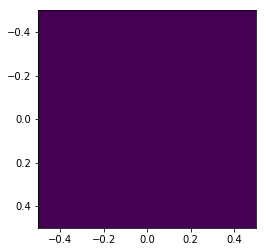


Filtro Corrente: 
 [[[-0.02655118  0.01249094  0.33351473 -0.15541789 -0.07026351
   -0.01372582  0.00936836  0.00890825  0.11165701  0.11652451
    0.0753022  -0.00181186  0.092386   -0.05420773 -0.04664867
    0.0785725  -0.107416    0.15450548  0.02482465  0.01129005
    0.09911138 -0.04701285  0.03641027 -0.19520858 -0.07925131
   -0.07479628  0.10470078  0.05292961 -0.09370894  0.18801588
    0.05765418  0.13658828  0.0436905   0.21744355 -0.13868217
    0.0509095   0.13297668  0.19622108  0.03645252  0.02484421
   -0.06079374 -0.22822297 -0.04225179 -0.1561206   0.02961663
    0.11812322  0.10831059  0.11159618  0.12997889  0.15782755
    0.17527353 -0.23588574 -0.23663886  0.0177404  -0.16481093
   -0.05322703  0.08450663 -0.06572561 -0.03116613  0.08538413
   -0.01464168 -0.29666201 -0.18714844 -0.08946362 -0.09618505
   -0.24821612 -0.19643604  0.28666584 -0.02502258  0.00622531
    0.32442132 -0.13794317 -0.02190533 -0.11361773  0.02743095
   -0.04346162  0.03831342 -0.08112

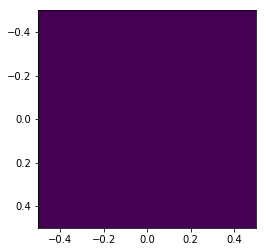


Filtro Corrente: 
 [[[-0.00656168  0.11808888 -0.02600176  0.00255054 -0.17011217
    0.14728122 -0.07451629  0.07166731  0.02561773  0.06641042
    0.13538997 -0.17341547  0.02209196  0.0270593   0.14020886
   -0.02449504  0.109343    0.01026154  0.14528186  0.10178853
   -0.02386328  0.12405571 -0.02060675  0.2020528   0.19881055
    0.02834784  0.04474637 -0.14835988 -0.05361834 -0.1995281
   -0.29811465  0.0579944   0.02783613  0.17889804 -0.05941044
    0.09750437  0.08042333 -0.03758665 -0.05311687  0.02678568
    0.04884922  0.08799805  0.10823929 -0.11092858 -0.12171019
   -0.06680047  0.1765264  -0.19944122  0.28095426  0.20264676
   -0.06954856 -0.09589141 -0.09930831 -0.1042198   0.06175407
   -0.11714669 -0.13881245 -0.06831248 -0.08328629 -0.08441967
    0.07425289  0.0290154  -0.06464754  0.15132637 -0.04214836
    0.10846332 -0.0294673   0.05442695 -0.1190871   0.09843268
    0.01188848  0.09649583  0.09075523 -0.00366543  0.07521068
   -0.14163054  0.02357793  0.090538

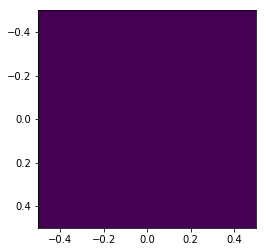


Filtro Corrente: 
 [[[-0.12406883  0.06542245  0.29301939 -0.02063825  0.11516297
   -0.00530861 -0.0347751   0.08514392  0.0706187  -0.20198655
   -0.11128966 -0.19408579  0.11530692 -0.11199819  0.19910317
   -0.04937588  0.14492586 -0.22969334  0.12420008 -0.06238607
   -0.08425095 -0.08381071  0.12415675  0.02115596 -0.02039656
    0.0963807  -0.10960447  0.10831846  0.09183112 -0.01279804
    0.01962301  0.11294018  0.08774834  0.06550982  0.07417597
    0.2100266   0.23152949  0.03855445  0.17372498  0.00245274
    0.09327513  0.10897791  0.03258043 -0.13438063 -0.12070644
   -0.00420243 -0.13549031  0.0214529   0.08550009  0.12466879
   -0.0695985  -0.10614968  0.07590848 -0.03281596 -0.18445048
    0.17026851  0.18620711  0.05304814  0.09009338 -0.1156329
   -0.01498967  0.08668455 -0.02246592  0.18823279  0.01913168
    0.11017964  0.2789209   0.12053118 -0.0012324   0.12916695
   -0.05379079 -0.04523934  0.03139653 -0.05439643  0.01389795
    0.15624033  0.09900935 -0.167566

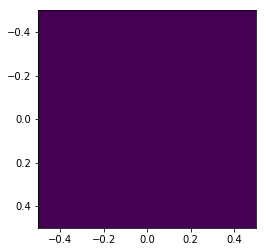


Filtro Corrente: 
 [[[-0.05510093 -0.23884495 -0.26661348  0.03104907 -0.04713347
    0.22063813 -0.13227004  0.1519688  -0.03895734 -0.14576582
    0.04580164  0.10213748  0.05562466 -0.09620917  0.0651078
    0.11738695 -0.01030536 -0.06118893  0.31977144  0.19859333
    0.02707762  0.05800652  0.16038541 -0.09239545 -0.13710084
   -0.20435979  0.04698952 -0.11040929 -0.20011815 -0.11758496
    0.12768715 -0.09003577  0.15333576 -0.04872343 -0.1600345
   -0.22859576 -0.18250849 -0.31940525  0.22009705  0.00674928
   -0.35446066  0.0106939  -0.19888321 -0.07388657  0.14169083
    0.21157665 -0.04954595 -0.12105179  0.04449332  0.01094431
   -0.23351895  0.05829094 -0.0269982  -0.07020971  0.05188288
   -0.06708248  0.05204821 -0.0343601   0.02596192 -0.14326315
    0.01817061 -0.0635471   0.10098217 -0.13761424  0.38910723
    0.21077097 -0.09389631  0.00393842 -0.07259534  0.0442137
    0.00277655 -0.0633799   0.09291417  0.03619918 -0.39055233
    0.02461843 -0.00171845 -0.32387018

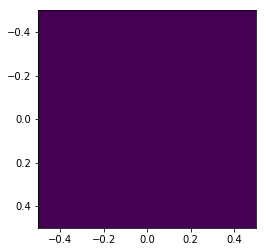


Filtro Corrente: 
 [[[ 2.10035684e-01  1.95805194e-01  8.98240024e-02  1.83946565e-01
   -1.32992805e-01  4.44464849e-02 -2.46703210e-02  1.50697187e-01
    6.31700083e-02 -2.02367835e-02  7.71007030e-02  1.33940247e-01
    4.48890975e-02  3.66807866e-02  1.37337020e-01 -1.63393948e-01
   -1.74900703e-01  9.98566764e-02 -9.93051892e-02  9.54409085e-02
    2.99558562e-02  4.54466847e-02  5.94247180e-02  2.66183507e-02
   -1.80240908e-01  3.95574618e-02 -4.60866021e-02 -1.63914560e-01
    2.12702360e-01  6.46902531e-03  1.49668569e-02  7.96742558e-02
    7.58159718e-02 -8.50454132e-02  7.32881368e-02 -2.93355308e-01
    7.39540850e-02 -1.46639702e-01  1.05932012e-01 -9.90279904e-02
   -1.28090030e-01  1.20572989e-01 -7.03715323e-02 -2.12583406e-02
    1.10268303e-01  1.09073855e-01  6.95788795e-02 -9.38073475e-03
    1.93291887e-01  9.10472683e-02  1.32951759e-01 -6.41659410e-02
    2.52030028e-01 -2.08594566e-01 -2.74829130e-02 -4.66540553e-03
    9.60931585e-02  1.46566824e-01  3.5782

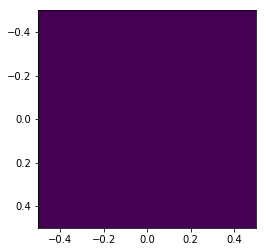


Filtro Corrente: 
 [[[ 0.14019108 -0.15149197  0.13378113  0.20771559  0.01097998
    0.14934326 -0.24369977 -0.05925149 -0.12132438  0.11529917
    0.06637955 -0.04824998 -0.15590157  0.16613697 -0.06428621
    0.01113381  0.05896956  0.0605469  -0.11391126  0.17238371
    0.17672452 -0.03276289 -0.04681149  0.1973929  -0.00767316
    0.03379381 -0.08845755 -0.23875596  0.15952325 -0.15302832
    0.09507788  0.06361338 -0.03029886 -0.2153159  -0.08657533
   -0.23673601  0.00923718 -0.23271735 -0.1005898  -0.16139055
    0.03559936 -0.00438074  0.0353555   0.03305242  0.05075448
    0.03212727  0.2438554   0.13890214  0.02655    -0.01600465
    0.11135226 -0.02423169  0.19839213  0.13677918 -0.08152186
   -0.03389092  0.07615468  0.11771336  0.26579915 -0.10900352
   -0.25946136  0.02501654  0.04228703  0.15022437  0.16293929
   -0.13189548  0.00571234 -0.21033629  0.26408111  0.08627033
   -0.01713361  0.01940766 -0.17078924 -0.03911099 -0.15636907
    0.02419283  0.015444   -0.19633

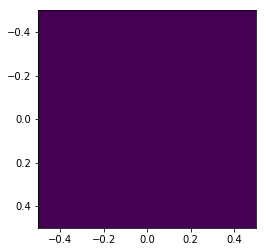


Filtro Corrente: 
 [[[ 0.03140001  0.08961295 -0.06924    -0.07448188 -0.10076235
    0.14909956  0.02369683  0.2030348   0.04848117 -0.13731581
   -0.02106136 -0.09140988 -0.00653565 -0.10614799  0.10658958
   -0.06569352 -0.13289386  0.0737509  -0.05934166 -0.10220118
   -0.04749769  0.01329198  0.0522754  -0.24219039 -0.14320714
    0.06184941 -0.0026958  -0.01198576  0.01992659  0.09787583
   -0.20381174 -0.19009434  0.03873526 -0.2669747  -0.08529722
   -0.01382532 -0.01558807  0.08521565  0.24040146  0.14012999
    0.15391145 -0.01439521  0.18857595  0.03408264 -0.00157126
    0.2196753   0.10353455  0.14027544  0.1456315   0.0988945
    0.25959641  0.03552001  0.08819881  0.32352905  0.15879603
    0.05584449 -0.23525648  0.0060776   0.13650532  0.01355693
    0.18652509  0.18660909  0.01226169 -0.12101466 -0.24293647
   -0.001192    0.1198929   0.26170892 -0.09293171 -0.06404591
   -0.09438264 -0.12275616  0.03370326 -0.16843233 -0.20099807
   -0.03487602 -0.25024629 -0.165314

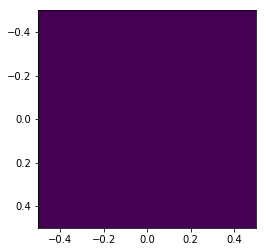


Filtro Corrente: 
 [[[-9.33491274e-02 -8.81449283e-02  2.66877503e-01 -3.03537687e-01
   -1.17816891e-01  1.77278373e-02  8.46846253e-02 -1.07241004e-01
   -5.64467918e-02 -5.04364476e-02  2.77469533e-03  2.16177882e-02
    1.37877134e-01  2.74363222e-01  3.83669578e-04  6.77689308e-02
    1.45482075e-01  1.11073145e-01 -1.18982049e-02 -2.71820258e-02
   -1.42757639e-01  2.16866474e-01  9.47480008e-02 -3.86925329e-01
    2.17965057e-01 -1.18096843e-01  9.39583557e-02  1.87432050e-02
   -6.38695256e-02  5.82626304e-02  1.32613818e-01  9.34584880e-02
   -1.15495412e-01 -9.00822971e-02 -1.36445583e-03  1.15818999e-01
    2.10238002e-01 -2.83665117e-03  1.08595056e-01  6.59544224e-02
   -4.49384069e-02 -1.07613897e-01 -7.54737257e-02  6.50112941e-02
    7.47012831e-02 -2.78096484e-01  2.27495454e-01 -1.43249216e-02
   -1.90356786e-02  1.20815455e-01  7.17513491e-02 -2.22213255e-01
    2.21269974e-01  2.09811548e-01 -3.13184180e-01  1.33570370e-01
    2.13595581e-01  5.08463175e-02 -4.7815

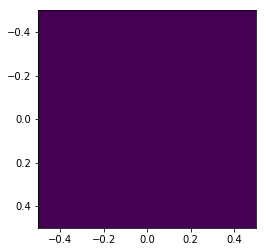


Filtro Corrente: 
 [[[ 0.01683056 -0.1512433  -0.08441084  0.29214103  0.021541
   -0.12517969 -0.10776893  0.19875356  0.07117953  0.14795152
    0.11417262 -0.07030834 -0.01441662  0.11831676  0.02819596
    0.17550483  0.12047803 -0.12742173  0.03579395 -0.06143028
    0.19968787 -0.04535048 -0.31292112  0.08862031 -0.1322265
   -0.06904596 -0.13109152 -0.30556668 -0.03231231  0.09722782
    0.18335329  0.05581002  0.01595304 -0.07773446  0.15325427
   -0.06415878 -0.29666846 -0.12404197 -0.04048146  0.22505532
    0.03388045  0.21755308  0.00355858 -0.05465071  0.13590888
   -0.09482479 -0.11393775 -0.0008331  -0.03513393 -0.01547905
    0.02560992  0.01770373 -0.02479579 -0.13825916 -0.08266439
   -0.05329134 -0.00677064  0.05361465 -0.13394614  0.04919092
   -0.01538041 -0.16661486 -0.08409457  0.06237875 -0.01805891
   -0.31616225 -0.2207807   0.0904345   0.09002165 -0.00565555
   -0.04346655 -0.12682961 -0.13808807 -0.11310609 -0.21714741
    0.04135943  0.29004774 -0.03795873

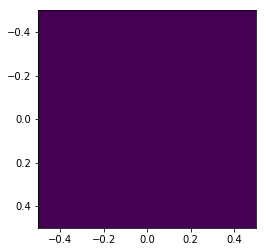


Filtro Corrente: 
 [[[ 0.11492375 -0.12024815 -0.16617733  0.01157092  0.02863086
    0.12256929 -0.19886265  0.07897742  0.29476498  0.03791201
   -0.03190097  0.02049643  0.08637196  0.04708768  0.1700963
   -0.0494961  -0.06133002 -0.05488195 -0.07317243  0.09311359
   -0.1363276  -0.15633232 -0.10194385 -0.14811642 -0.11658948
   -0.12527156 -0.01744133 -0.09171453  0.02535179 -0.06055626
   -0.01563455  0.0941028  -0.07153756 -0.09806277 -0.17189251
   -0.1173427  -0.04730206 -0.01731123 -0.16458986  0.06533425
   -0.22677099 -0.07865691 -0.1335569   0.06546376 -0.140076
   -0.05307965  0.0240301  -0.12211385 -0.05340286  0.06699245
   -0.10882833 -0.03686384 -0.07398565 -0.16929161  0.06450908
   -0.06780652 -0.17757008  0.10267552 -0.02649001  0.14851644
   -0.24572856  0.18761701 -0.09977106  0.09020071 -0.00479211
   -0.08722458  0.07492704 -0.12454626  0.05396799 -0.12785463
    0.14531641 -0.11553914  0.14333608  0.02247578 -0.11095728
    0.07396414  0.22433548  0.15858809

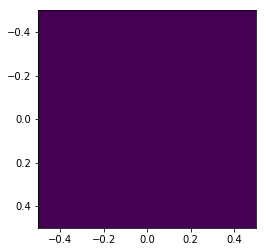


Filtro Corrente: 
 [[[ 1.80049099e-02  7.45343439e-02  8.34351367e-02 -8.43366903e-02
    6.98052537e-02 -1.33179602e-02  1.27027026e-02 -7.33008171e-03
   -1.92063515e-01 -1.86375473e-01 -9.71908429e-02  2.33930230e-01
   -1.99880817e-01  2.75435101e-02  1.41832427e-02 -6.38020264e-02
    5.06200403e-02 -2.28256154e-01 -6.86894863e-02  7.22346068e-02
    6.42044088e-02 -1.15169444e-01  2.06139854e-01 -1.83515838e-03
   -3.64504181e-02 -1.27304352e-02  7.53393847e-02 -1.44980096e-03
   -2.27469126e-01 -2.43867669e-01 -1.20834505e-02  2.23070402e-01
    1.31344570e-02  9.42316731e-02  7.49657720e-02  2.21396977e-01
   -2.61121446e-01 -1.22963381e-01 -1.25898105e-01 -2.69889758e-03
   -3.22614187e-02  1.63891844e-01  6.93500609e-02 -8.89621192e-02
    6.05609769e-02 -9.32704902e-03 -9.21756797e-02  8.16911767e-02
   -7.57493347e-02  2.38826256e-01 -6.85083066e-02  2.99268480e-02
    2.21904835e-01 -1.29905124e-01 -8.93511097e-02  1.77609916e-01
    9.86611793e-02 -4.51433938e-02  7.0324

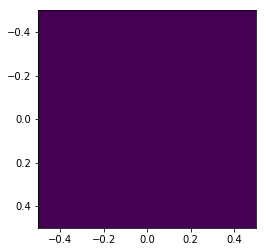


Filtro Corrente: 
 [[[ 0.14023744 -0.02835881  0.13948623  0.06154064 -0.08296617
    0.04568737  0.03133728  0.20334058 -0.01068371  0.2819678
    0.24530835 -0.11360025  0.02284402  0.05584005 -0.08519376
   -0.00340936  0.13259245 -0.09897109  0.12877171 -0.09809332
    0.0793595  -0.06654481 -0.17834694 -0.06043034  0.02736244
   -0.13005153 -0.02382826 -0.19968501  0.12675064 -0.12525125
    0.06157189 -0.18088485 -0.04960712  0.05028701  0.08996627
   -0.02150697  0.09882497  0.03737838 -0.18231341  0.05888938
    0.15581742 -0.12640236  0.07650617 -0.08263714  0.19276585
   -0.05462874  0.08857279  0.10062656 -0.13780831  0.06314596
   -0.05577455 -0.14437205 -0.17426869 -0.06568925 -0.02169613
   -0.1379709   0.10345037 -0.1189981   0.16035992 -0.03415463
    0.10594572  0.10348485 -0.18849756  0.03457026 -0.18265531
   -0.06342602  0.11695487 -0.1985314  -0.04691208  0.15976963
    0.26351299  0.21737468 -0.06832436 -0.02929965  0.04236999
   -0.01220963 -0.20019296  0.089844

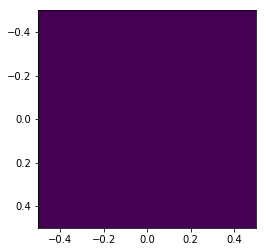


Filtro Corrente: 
 [[[ 9.18560873e-02  1.06109884e-01  1.56517990e-02 -1.25635270e-01
    2.88974588e-02 -9.60445271e-02 -7.85091533e-02 -1.76503365e-02
    6.51384577e-02  2.34192011e-02  1.23850463e-01 -7.02828253e-02
    8.72851397e-02  2.14183298e-01 -9.12988367e-02  1.42903966e-01
   -1.18294842e-01 -5.30996668e-02  8.11378656e-03  1.59629167e-02
    5.42040424e-02 -1.69832092e-04 -2.18557445e-01 -1.33886428e-01
    2.07232253e-01  2.10818500e-01  1.44852957e-01  2.07618586e-01
   -4.99739838e-02 -6.57739998e-02 -4.16451373e-02 -2.08173787e-01
   -1.28464446e-02 -3.45436969e-02 -8.56409104e-03  2.04152931e-01
   -2.73600304e-01  2.24126404e-01 -2.09425173e-01 -1.06564928e-01
    8.24123731e-02 -1.85120197e-01  1.14028727e-01  1.34115323e-01
    1.68209468e-02 -1.37602733e-01  8.38533498e-02 -4.78328464e-02
   -2.57164329e-01 -5.67952963e-02 -1.04821796e-02 -1.11056096e-02
    2.22575021e-01  9.04223825e-02 -1.99609867e-01  5.80668720e-02
    1.95766536e-01  4.09910870e-02 -9.8024

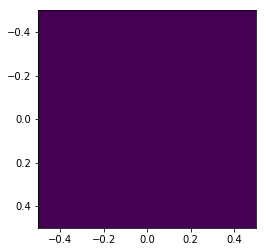


Filtro Corrente: 
 [[[ 3.33366945e-02 -1.32268110e-01 -7.32320803e-03 -1.76633845e-01
   -1.76150664e-02 -4.72491696e-02 -7.77770404e-02  1.31078412e-02
   -2.02313219e-01 -3.52162317e-01  1.32203961e-01  1.29765754e-01
   -1.44202857e-01  2.39844090e-02  3.14089746e-02  2.36683058e-01
    4.08766414e-02  6.73309597e-02  1.07374254e-01 -7.92487905e-02
    7.39012177e-02 -5.63782318e-02 -9.92997362e-02 -9.30351366e-02
    3.44755378e-01  1.15879054e-01 -1.02809202e-01  2.80231684e-01
   -1.95855427e-01  8.56869932e-02 -1.84682237e-02  5.77384093e-02
    1.82881648e-01 -1.13956938e-02  4.56476662e-02  6.01336299e-02
   -9.09883895e-03  6.02024227e-02 -1.20708175e-01 -1.78069595e-01
   -1.18875652e-01 -8.22890192e-02  1.03563377e-01  8.85549862e-03
   -3.65924798e-02  1.75348732e-01 -1.23740909e-01  1.50498620e-01
    1.11899076e-01  1.10963072e-01  2.50395652e-01  1.91967648e-01
   -2.38560236e-02 -1.07304375e-01 -1.39696301e-01 -1.48869106e-01
    2.06970228e-01  8.95131128e-02  1.5078

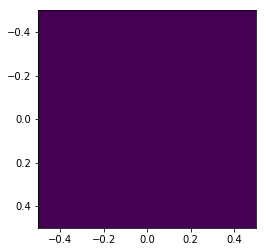


Filtro Corrente: 
 [[[ 0.10439414 -0.1095839   0.12380465  0.01506661 -0.07209499
   -0.12140128 -0.13068518  0.03494709  0.01975674  0.21188518
   -0.0540563   0.07631233  0.06182436  0.0027127  -0.00803436
   -0.01540633 -0.01787929  0.04955146 -0.14660484  0.15407955
    0.07206664  0.31082093  0.08597533  0.18129754  0.02552299
   -0.13376826  0.06549356  0.20712138 -0.15797356  0.21718124
   -0.05874417  0.04018229 -0.03112109  0.00880574 -0.00628246
   -0.1303772  -0.12010816 -0.06882064 -0.10361154  0.00376935
    0.00794836 -0.05512443 -0.01322698 -0.09601731  0.0783271
   -0.00687872 -0.07589477  0.02615282  0.18289684 -0.15386032
    0.02222534 -0.0781513  -0.05411684  0.17305378  0.13268438
   -0.06243401 -0.08801086 -0.26606145  0.02598521 -0.00286526
   -0.10963144  0.09521629 -0.05744461  0.0856967   0.0284897
    0.02738659 -0.00861855 -0.02530395 -0.28866842 -0.0189585
   -0.07728456 -0.02231966 -0.0550848  -0.05758532  0.16201213
   -0.00971164 -0.09881999 -0.04754643

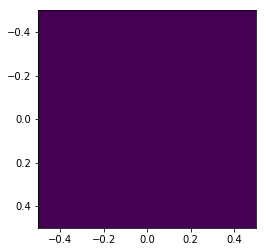


Filtro Corrente: 
 [[[-0.09413933 -0.05791901 -0.08660876  0.18585255  0.02042565
    0.01815362  0.05681871  0.06849225 -0.09711881 -0.18515512
   -0.11975313  0.03873331  0.26522134  0.22214745 -0.03952044
   -0.07307765 -0.03844616 -0.11649201 -0.04524589 -0.00945679
   -0.0503898  -0.10975143 -0.01992348 -0.01077796 -0.18404172
    0.0380163   0.08777001  0.01534987 -0.24809193  0.18268515
    0.05623136 -0.08454722  0.07841654  0.23398502  0.04375259
    0.02216481  0.05469218  0.09629567  0.02921045 -0.18910217
    0.1248227  -0.14350972 -0.0562082   0.1508323  -0.04559968
   -0.24934626 -0.08433319  0.16446473  0.08817327  0.2518253
    0.08366868 -0.05913712 -0.06415825  0.10622506 -0.42490387
    0.04737699 -0.05893593 -0.01165787  0.09247734 -0.2251923
   -0.20355318 -0.06676646 -0.19334565 -0.13474256 -0.05791894
    0.05890554  0.02965357 -0.10919298  0.07332727  0.18417543
   -0.04614296  0.17708455 -0.02851697  0.02929741  0.22913213
    0.01644634 -0.09242876  0.2583573

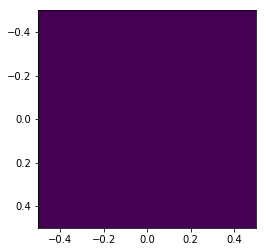


Filtro Corrente: 
 [[[ 3.87353350e-02 -7.97421362e-02 -2.74534154e-02 -1.05363267e-01
   -3.75821516e-01 -2.26595519e-04 -5.15558959e-02 -2.17639221e-01
    5.07819791e-02 -8.24299440e-03  2.96806777e-02  2.94602484e-01
    2.63946436e-02  1.61931867e-01 -1.20022287e-01 -2.22724831e-01
   -5.63793672e-02 -2.37213362e-01 -1.55968279e-01 -9.97568198e-02
    4.60262132e-02 -2.60846056e-02  4.92639499e-02 -1.19298724e-01
   -1.93346088e-01 -7.73602143e-02 -1.02272940e-01  8.36584106e-02
    7.22409605e-02  1.51719301e-01  1.38838184e-01 -1.81107676e-01
    4.36153092e-02  1.41290655e-02  1.84536731e-01 -4.78730690e-02
   -9.04326845e-02 -1.47004826e-01 -1.32329628e-01 -1.30020697e-03
   -2.22939418e-04 -6.66421101e-02  2.06228048e-01 -1.60730645e-01
   -1.13531729e-01 -1.44234576e-01  8.86413509e-02  6.16406538e-02
   -6.13848592e-02  1.08499199e-02  6.18797279e-03 -7.79003733e-02
    1.05146093e-01  9.90774512e-02  1.17080613e-03  2.73023755e-02
   -3.22653247e-01 -1.50763038e-01  5.0341

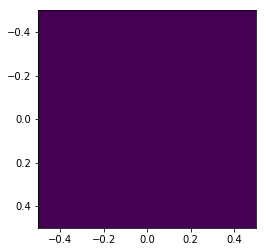


Filtro Corrente: 
 [[[ 0.0226247   0.03768856 -0.06124926  0.17389582  0.20619463
   -0.02596753  0.0326431   0.10624984  0.01608397  0.10207778
   -0.05394774 -0.06825255  0.14973541  0.06710372 -0.15570123
   -0.00092368 -0.10987262 -0.09913813  0.09195999 -0.13867978
    0.03783856 -0.01625056 -0.15896586 -0.03929277  0.13863718
   -0.08147993 -0.07659116  0.0032657   0.02200737 -0.0958648
   -0.14456848  0.01634296 -0.14791276 -0.00384248  0.06764972
   -0.15526498  0.09864078 -0.08082115  0.00498495  0.12211077
    0.01562406  0.06650812 -0.10792327 -0.05684838 -0.03506372
   -0.30653633 -0.01897114  0.00772074 -0.13086568 -0.06580111
   -0.23885771 -0.01761773  0.10590669 -0.04639756  0.14831472
    0.05533802 -0.10412528 -0.00573736 -0.11944128  0.03468005
   -0.1995331   0.17663371  0.07994878  0.1497752  -0.00074092
   -0.27848798 -0.21440129 -0.0892188  -0.10832152  0.16150386
   -0.12775892 -0.02879169 -0.03693638 -0.09137991 -0.16071069
   -0.05970375  0.17663072 -0.039328

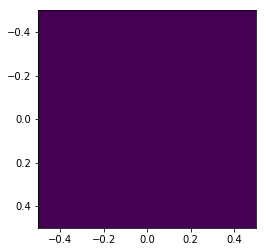


Filtro Corrente: 
 [[[-0.11621152 -0.04780904  0.15924085  0.08434383 -0.11404766
    0.10717802  0.04616745  0.13919536 -0.15728336 -0.02918733
    0.04324936  0.10807699  0.20583379  0.09031893  0.11682872
    0.00653192 -0.01285642  0.09186239 -0.03092657  0.0444516
    0.15123508 -0.07889856  0.17408457  0.26736826 -0.16723395
    0.03866356 -0.07160626  0.14467195  0.04058236 -0.11689097
    0.00750831  0.27466672 -0.02784266 -0.07137769  0.03994033
   -0.03387376 -0.02067995  0.04313023 -0.03685517 -0.08922021
   -0.04135755 -0.00069553  0.19914083 -0.09818339 -0.02104564
   -0.27477849  0.01639896  0.05495105 -0.09994972  0.09092402
   -0.04399703 -0.00542635  0.10215856  0.24225788  0.08453074
    0.07047563  0.14906333 -0.07942699 -0.00610715  0.00767371
   -0.07806397  0.23702793  0.0953999   0.03579405 -0.03185805
   -0.08016711 -0.00536813  0.18754491  0.01232688 -0.05181853
    0.08892099  0.04984121 -0.13076642 -0.13965434  0.07880621
   -0.06623312  0.17525391  0.011490

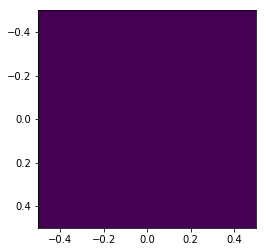


Filtro Corrente: 
 [[[-0.13878506 -0.15206239  0.15811771  0.15386504 -0.05890315
   -0.16644274  0.0890306   0.17205331 -0.07348018  0.09536888
   -0.16071878  0.02303002  0.16603762  0.11018314  0.05262697
    0.19963227 -0.21481353  0.08602363 -0.07145379 -0.00861982
   -0.15821572 -0.02831701  0.09564762 -0.11678691  0.24984813
   -0.16333995  0.26531751 -0.11013495 -0.06011644  0.02028276
    0.16504315  0.08094292  0.1015526   0.02384309  0.1363419
    0.08479754 -0.05026287 -0.04820546  0.34061851  0.16787507
    0.06553571 -0.26831752  0.05949683 -0.1279293   0.1547527
    0.12934383 -0.11903471 -0.18464184  0.00440049  0.01374397
    0.14517176 -0.12248533 -0.10954055  0.04233948  0.12305115
   -0.10286036  0.20847585  0.19852719  0.07260936  0.02970337
    0.21557615  0.05064901 -0.12570554  0.12968234  0.30436212
   -0.12624652 -0.02420962  0.0721437   0.03533581 -0.18691489
    0.04488388 -0.04637324  0.08172918  0.16661445 -0.06255848
   -0.01950787  0.01452251  0.0234081

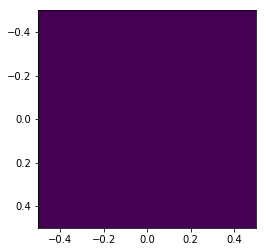


Filtro Corrente: 
 [[[-0.21339051  0.01041521 -0.17631142  0.03536981  0.04296407
   -0.01668849  0.08385192 -0.08771001 -0.14453329  0.09197691
   -0.05062739 -0.02851801  0.14835016 -0.0272818   0.21811055
   -0.03015661 -0.15945557  0.06551706 -0.01411548 -0.02433748
    0.0332377  -0.02074885 -0.25309924 -0.13118493  0.17059442
    0.2333962  -0.02210081  0.0580181   0.01212201  0.18008566
   -0.2512885  -0.09538053 -0.1879887  -0.06864347 -0.01743478
   -0.10987103  0.04044587 -0.04765434 -0.28485107  0.12666858
    0.10925014  0.00145089 -0.25962414  0.02791455 -0.11126608
    0.02849246  0.13673636  0.03413526 -0.2134219  -0.25746657
   -0.10239198 -0.06675881  0.15717278 -0.00721974  0.01629795
    0.04866347 -0.14044718 -0.0289462  -0.09513823  0.04411932
    0.18517973 -0.00812429  0.14640609 -0.05417814 -0.17828768
    0.01030495 -0.04943272  0.20514995 -0.03370455  0.08008504
   -0.11165768  0.07906501 -0.07459765 -0.11282121 -0.10681576
    0.23117487 -0.14182636  0.00651

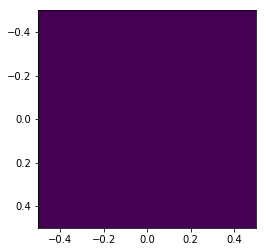


Filtro Corrente: 
 [[[ 0.1492239  -0.03892228 -0.21973972  0.02475457  0.13785813
    0.04473307  0.13898843  0.12828157 -0.11026652 -0.0324737
    0.15201577  0.07704886 -0.05780023 -0.01417477 -0.05911828
   -0.09140299  0.03275981  0.07459947 -0.17930634 -0.0482139
   -0.08836422 -0.03935053  0.01262709 -0.08881352  0.18627901
    0.11124224  0.11576874  0.15069639  0.00274679 -0.20310621
    0.12481657  0.16999581  0.16503608 -0.03763337  0.02022613
   -0.07066341 -0.13515261  0.00858061  0.12995833  0.01087557
    0.03383375 -0.18826932  0.20815993 -0.08169315 -0.03979516
   -0.05207627  0.05938009  0.05699046 -0.13810354 -0.06511649
    0.19906171 -0.05394912  0.01272776  0.09002456 -0.10549871
    0.06844623 -0.02438662 -0.18008696 -0.0792431   0.0323841
   -0.07349971  0.32403533 -0.01748526  0.12871513  0.02915889
    0.22032144 -0.0301926  -0.02036717  0.01371816 -0.10730366
   -0.16679824 -0.21365355 -0.00346713  0.08807586 -0.11560311
   -0.15422218  0.09473263 -0.07005894

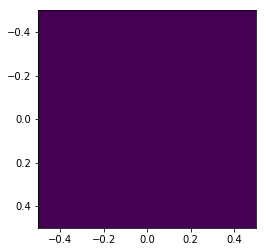


Filtro Corrente: 
 [[[-0.06609935  0.09452736  0.20053692  0.15399091  0.11594302
   -0.04518628  0.00932719  0.10542294  0.19221215  0.06386338
   -0.10193335 -0.02291102 -0.07901086  0.06627655 -0.17908552
   -0.096267   -0.01159219 -0.19823391  0.22721034 -0.02694135
    0.07867788 -0.10453963 -0.15218763  0.0724427  -0.17075941
   -0.05660944  0.02521267 -0.02430361  0.00954381  0.11897373
   -0.14803516  0.1293546   0.3430324  -0.15583872  0.00561425
   -0.24336212  0.04289965 -0.1610516   0.217386    0.08253826
    0.02672959  0.24152665 -0.06408414 -0.00584004  0.09855238
    0.14231455 -0.08036916 -0.18693051  0.06212787  0.15045627
   -0.01683096 -0.05930527 -0.16582456 -0.03437421 -0.32555568
    0.19821519  0.08234084 -0.18319    -0.0910143   0.13145705
   -0.12186173 -0.1252243   0.06008748  0.14248423  0.04787526
   -0.21427893 -0.12355357  0.09685032  0.10907033 -0.12277121
    0.1321108   0.15650104 -0.07629618 -0.04331147  0.19315703
   -0.05991743 -0.12126197  0.08769

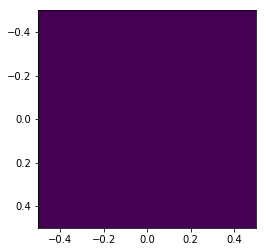


Filtro Corrente: 
 [[[ 0.20189911  0.17288519 -0.00756646 -0.15176131 -0.15709802
   -0.19030793  0.06679783 -0.03444324 -0.10525374  0.10472583
   -0.083305   -0.033234   -0.06447982 -0.10157286 -0.06561536
    0.08535279  0.04661839 -0.09830522 -0.08829526 -0.1274153
   -0.01318854  0.24017835  0.02455216 -0.0250308   0.13549269
    0.24420142  0.11511229  0.05526118  0.26586087  0.03807747
   -0.08782069 -0.00521041  0.07729301 -0.07990884  0.08166585
   -0.16050506 -0.03096667  0.06208224 -0.08943659  0.11214693
    0.3011468   0.0375699   0.11514477 -0.0448991   0.06216681
    0.13586779  0.14176694  0.04971364 -0.08863384 -0.07512406
   -0.01002731 -0.03307197 -0.04478349  0.00778932 -0.05563978
    0.05387534  0.04000232 -0.05399462 -0.12852055  0.07858327
   -0.2553981   0.04910623 -0.09564035  0.01122772  0.16002774
   -0.0462778  -0.00538472 -0.06621983 -0.14522648  0.0536701
   -0.0959532   0.12834465  0.15429799  0.0139471  -0.06602004
   -0.10007738  0.32341457  0.2649353

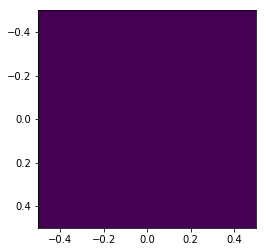


Filtro Corrente: 
 [[[ 0.17774555  0.14548615 -0.10044809 -0.10557188  0.00992974
    0.35878072 -0.00772844 -0.13766949 -0.02231955  0.01297783
   -0.04928144 -0.08028932 -0.02347441  0.25005021  0.07514892
    0.21254635  0.16595945 -0.19567525  0.08943828  0.18400896
   -0.12505597  0.24213036  0.12910692 -0.21526729  0.07796062
    0.19539653 -0.18809719 -0.02443576 -0.37548258  0.31104015
   -0.30707094  0.14003181  0.04149615  0.2321903  -0.05199461
   -0.03372377 -0.10474664 -0.20636797 -0.00948753  0.08948042
   -0.0559966  -0.0568336   0.19423023 -0.06424675 -0.05172378
    0.12585645 -0.00877739 -0.19717526  0.10350432  0.06126891
    0.01494327  0.30092551  0.07083673 -0.21080638  0.04855879
    0.04388759  0.02663672  0.09818332  0.0648193   0.12254292
    0.29927787  0.15488499 -0.18560491 -0.03878329 -0.20851804
   -0.01245735 -0.06373815  0.16707419 -0.07910591  0.20497953
   -0.01400326  0.03906719 -0.03461393 -0.0044327   0.08853564
   -0.00640217  0.05957916 -0.02846

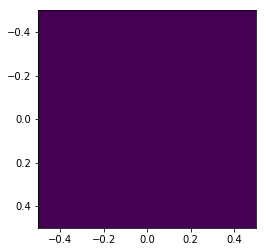


Filtro Corrente: 
 [[[ 9.78636304e-02  6.64037435e-02 -6.74978616e-02  9.05356915e-03
   -4.46133502e-02 -4.03557834e-02  5.42382083e-02  1.15629433e-01
   -2.92836196e-01  3.36207875e-01  1.73343396e-01  2.01041491e-04
    1.11593298e-01 -3.07200221e-01 -7.96735582e-03  1.31460823e-01
    1.67751153e-01  7.93507948e-02  2.53891960e-01 -8.11398174e-02
    9.37848702e-02  3.71007287e-02 -4.45849148e-02 -7.41357883e-02
   -2.15319762e-04 -1.60589043e-02 -1.13411389e-01 -2.94076604e-01
    1.08982312e-01 -1.12650324e-01 -1.89054333e-03  2.30117565e-01
    1.24378054e-01  1.03670463e-01 -2.09682921e-01 -1.00137343e-01
    2.10065147e-01  1.09646023e-01  2.08258308e-01 -2.09658484e-01
   -2.96440307e-03 -8.12859991e-02 -1.00085668e-01  7.75021101e-02
   -1.40498295e-01  2.11551908e-02  2.38191099e-01 -1.39443100e-01
    8.03932479e-02 -1.68913170e-01  8.50718410e-02  6.13070382e-02
    4.33105137e-03  1.22560879e-01 -1.83398284e-01  2.32646049e-01
   -1.25071752e-01 -1.91825721e-01 -3.4721

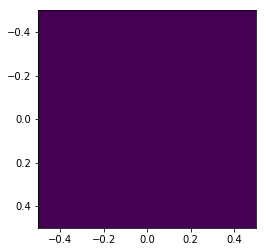


Filtro Corrente: 
 [[[-0.10733787 -0.04435668  0.18391608  0.03028844 -0.12634027
   -0.25175116  0.04647179 -0.08425395  0.04669109 -0.01687276
    0.28102574  0.06989024 -0.01295206  0.04837172 -0.08619516
   -0.21116223 -0.28934711  0.12128826 -0.06449135  0.12713065
    0.1356953  -0.20536629 -0.19098688  0.31382441 -0.12349012
   -0.27128589 -0.30379727 -0.14603422  0.04176089  0.06937187
    0.03606165  0.23886496 -0.20962172 -0.01064353 -0.11705322
    0.24661569 -0.02475364 -0.18462805  0.05820254  0.01581528
    0.0547368  -0.26974522 -0.07937632  0.15977607  0.02478928
    0.26859336 -0.03060914  0.1814591  -0.03860168 -0.02562521
    0.00647848 -0.09083757 -0.06570435 -0.1243348  -0.26223123
   -0.12664461  0.38211416 -0.1864867   0.05503472 -0.03828929
    0.20399357 -0.13171153  0.02870902 -0.25486911 -0.08061429
    0.30406775  0.26381207 -0.21947392  0.05574188 -0.1389035
   -0.46536544 -0.05708691 -0.0301396   0.11938059  0.08267653
    0.14044321 -0.02967663 -0.026385

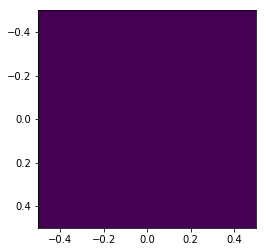


Filtro Corrente: 
 [[[-0.20201736  0.04722808  0.01439653 -0.19170267  0.26369154
   -0.10422329  0.14518656  0.0702542  -0.09772077  0.1924033
    0.08165012  0.33106746 -0.28713764  0.04980165  0.13474294
   -0.22841835 -0.05334908  0.02479663  0.18067241  0.11593308
   -0.06648321 -0.17471429  0.03085133  0.10050901 -0.23101802
    0.15619525 -0.10172014  0.09461367  0.14290346 -0.10131024
   -0.08727476  0.0117864   0.41243802  0.2586366   0.03100514
    0.14698376 -0.14825473  0.19206193 -0.39942526 -0.23520087
   -0.30069898 -0.0884226  -0.07163032 -0.35390621 -0.11189292
   -0.14337159  0.0284814  -0.27644436 -0.21958721  0.11485074
   -0.05325485  0.10420604 -0.18309317 -0.10610928  0.04113314
   -0.34053365  0.103628   -0.25370763  0.20959074 -0.11435366
   -0.18552472  0.17870971 -0.09978534  0.29103938  0.05055175
    0.04772579 -0.3745893  -0.0819919   0.04391691 -0.06613786
   -0.01703388 -0.06692664  0.08877108 -0.11025194  0.09443068
    0.14615481 -0.17452133 -0.073255

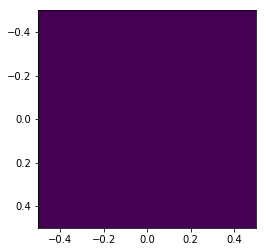


Filtro Corrente: 
 [[[-0.12620828  0.01246736 -0.10892181  0.06187429 -0.190674
    0.07759748  0.24703883 -0.26997209  0.13818288  0.07089869
    0.11576829  0.09091095 -0.1459666  -0.27100759 -0.16840373
   -0.43839542  0.08223924 -0.11640451  0.18302591  0.01912782
   -0.32119258  0.00701524 -0.1793801   0.24210084 -0.10486386
   -0.25129019 -0.15523545 -0.15579039  0.00740332  0.1768165
   -0.10162302 -0.03729077 -0.04136993 -0.23235133  0.14017778
    0.06467836  0.00368116  0.13227636 -0.14314129  0.29766007
   -0.01640894  0.18262884 -0.13600865 -0.11988261  0.12732075
   -0.23260007  0.07560966  0.04810611 -0.07457414 -0.03528366
    0.13774673 -0.133033   -0.0143761   0.08188794  0.11475739
    0.10115436 -0.17041727  0.07934014  0.19998275 -0.00939871
    0.18235149  0.06732362  0.18761222  0.02625528  0.36538186
    0.06894815 -0.25122553 -0.01296195  0.03750939 -0.04757871
    0.21349181  0.09432982  0.13694139 -0.12678622 -0.26747204
   -0.07972578 -0.06374488  0.02072571

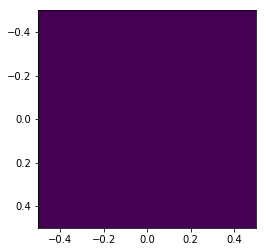


Filtro Corrente: 
 [[[ 0.2275714  -0.18240654  0.08548628 -0.02971927 -0.10021189
   -0.15641675  0.06648498 -0.03423897  0.060994   -0.03264683
    0.1453379  -0.0851713  -0.10493602 -0.29177875 -0.14276012
   -0.06804824  0.05156404  0.00410657  0.05557782  0.16385534
    0.0027357  -0.04003333  0.05009372  0.03500327 -0.22694245
    0.1155483   0.00572287  0.33781148  0.1286097  -0.13882497
   -0.20155667 -0.0051903   0.02020942 -0.00815806  0.36832133
   -0.00604344 -0.14624715 -0.20568667  0.18465419 -0.00120455
    0.07525091  0.09607032  0.0803132  -0.02150198  0.25933527
   -0.16218869  0.15325695  0.36022515  0.0649321  -0.12300844
   -0.19493828  0.10367036 -0.07616622  0.01209457  0.17248786
   -0.14909332 -0.16645615  0.05581065 -0.368903    0.24505191
    0.12806898 -0.22300927  0.03454204 -0.0771942  -0.07577687
    0.03684027 -0.05054078 -0.01381248  0.05343695  0.20453947
   -0.19487895 -0.02104627  0.02459971  0.0518582  -0.02434292
   -0.07342887 -0.02025219 -0.01410

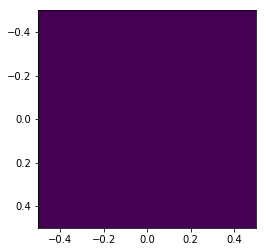


Filtro Corrente: 
 [[[-0.08880087 -0.1168164  -0.20513857 -0.04904539  0.28112224
   -0.15132011  0.20754249  0.06629785 -0.11601149 -0.26195714
    0.08053034 -0.17669502  0.13276787 -0.00118919 -0.02406346
    0.16731453  0.00121407  0.09561595  0.02611373  0.06921532
   -0.03506484 -0.02545264  0.11039887  0.27423578  0.00146047
   -0.07420947 -0.0262142   0.14076162  0.13908351 -0.32871953
   -0.11509572  0.12754306  0.21845339 -0.12117737  0.04466223
   -0.03800242 -0.10416588  0.03474632  0.14288849  0.07440641
    0.12860384 -0.05158039 -0.01859049 -0.07908284  0.02269792
   -0.0915413   0.20575124 -0.00241367  0.10997081 -0.26784907
   -0.00120731 -0.22087656  0.09580698  0.07258464 -0.10604037
   -0.12619947  0.04415163 -0.17571551  0.08087891 -0.0998254
   -0.20223908 -0.16955442  0.09808347  0.16344752  0.08698924
   -0.04201994  0.02618309  0.11082921  0.14912057 -0.06889143
    0.01241525  0.12297161  0.14033104  0.09132794  0.26191186
   -0.04350748  0.29186416  0.108425

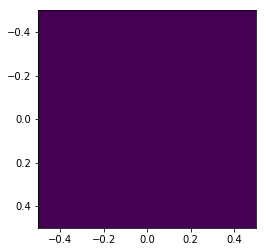


Filtro Corrente: 
 [[[-1.20333429e-01  1.60067149e-01  7.33471945e-02  2.38636189e-01
   -4.46098416e-02  1.82844686e-01 -1.84096368e-01  5.83641211e-02
   -2.06063138e-01  9.66628436e-02 -1.26205779e-01 -6.93766414e-02
    1.22587608e-02  1.59174962e-01 -1.32407676e-02 -1.82265146e-01
    2.98024549e-01  4.92871037e-01 -1.16201683e-01 -1.85027974e-01
   -9.54920385e-02 -1.99589680e-01  1.91547402e-01 -2.86079964e-01
    1.95207236e-01  1.02961770e-03  3.97321664e-01  1.59250092e-01
   -3.50575642e-01  2.01723149e-01 -2.38946924e-01  3.91469151e-02
    4.94257356e-02 -3.02536598e-01  4.23991360e-02 -1.29815463e-01
   -1.82114871e-01 -1.83475776e-02  1.28810741e-01  8.86548048e-03
   -1.21876047e-01  1.74119225e-01 -6.58678498e-02  3.20367612e-02
   -1.90460730e-01 -3.45064585e-02 -3.31104554e-01 -2.24287489e-01
   -2.35626362e-01  1.88295098e-01 -3.60102829e-02  4.93008425e-02
   -2.51325325e-02  2.65381847e-01  2.02301051e-02 -1.79567780e-01
   -8.13536184e-02  8.53503746e-02 -6.0692

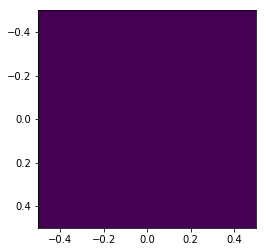


Filtro Corrente: 
 [[[ 3.87881328e-02  3.21087833e-03 -7.39787360e-02 -9.63311688e-02
   -6.48560572e-02  1.84057642e-01 -1.63465471e-01 -9.66553147e-02
    1.15346245e-01 -4.35189636e-02 -2.11748938e-01  1.74820833e-01
   -1.30584740e-01 -1.52387719e-01  1.72733618e-01  8.25018542e-03
    2.06792539e-01 -2.59026581e-01 -9.86855182e-02 -7.89513763e-02
   -5.53491736e-03  3.31052894e-01  1.05052517e-01  2.90221803e-01
   -1.23539302e-01 -6.20550425e-02 -2.81382861e-01 -4.27216088e-02
   -8.79263219e-02 -1.25480366e-01  9.36526594e-02 -1.92676670e-02
   -1.67682168e-01 -3.57448511e-05  2.44698886e-02  9.24831393e-02
   -1.66559451e-01  6.19641137e-02 -2.39470223e-01  9.54827118e-02
    1.00404132e-02  5.48126615e-02  2.07740583e-01  5.20400805e-03
   -1.78027782e-01 -1.09168595e-01 -1.88043037e-01  2.00983971e-01
   -7.88535561e-02  7.79324050e-02  1.68080479e-01 -3.54880424e-01
   -2.30796639e-01 -2.19950371e-03  4.31383803e-01  7.79710296e-02
   -1.66887713e-01  8.74263409e-02 -1.7439

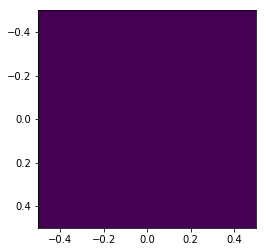


Filtro Corrente: 
 [[[-0.09433332 -0.00743472  0.18663882  0.20422154 -0.13458294
    0.15664713 -0.03144688  0.06429321 -0.08961053  0.21252528
    0.43018936 -0.03034933  0.27047604 -0.1513768   0.13931853
    0.38661039 -0.0164473   0.10891074  0.06222415 -0.03939225
   -0.03033681 -0.18381988 -0.02015168 -0.03874174  0.24054436
    0.04026781  0.14143711  0.13833848  0.15410329 -0.2197114
    0.00504211  0.12357351 -0.03118024 -0.03290324 -0.36459091
   -0.09041704  0.00958026 -0.05255743 -0.13334043  0.20261421
   -0.177179   -0.0592901  -0.02530843  0.18500108 -0.04043699
    0.25163361 -0.27056578 -0.10854005  0.04660523 -0.44886283
    0.0783652  -0.1589823  -0.00677374  0.04607244 -0.10682884
   -0.15011822  0.19972404  0.08495143 -0.05015314 -0.05921064
   -0.25509347  0.00602358 -0.15874799 -0.29822216 -0.01286687
    0.30109374 -0.20318209 -0.07429061  0.04876605 -0.15607253
    0.18832172  0.00159934  0.19654173  0.14868141 -0.1299674
    0.06377572 -0.05643784 -0.0368847

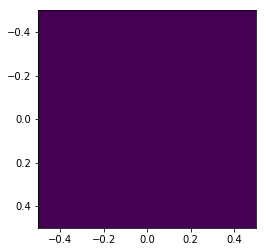



Matriz Antes: 
 [[[38.24967881 35.49811605  6.07561523 -3.69034889 34.2082911
   22.66683745 18.56909206  9.14216695  1.27726617  5.15781307]]]

\Matriz Depois: 
 [[[4.08906904e+16 2.60997243e+15 4.35117117e+02 2.49632910e-02
   7.18574927e+14 6.98364936e+09 1.15998992e+08 9.34098468e+03
   3.58682054e+00 1.73783986e+02]]]


Total: 
 4.421924486155844e+16


		Feature Map em valor ABS com preto = zero : 


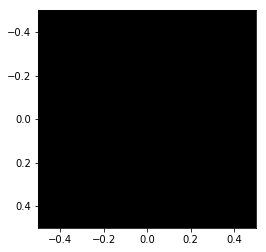

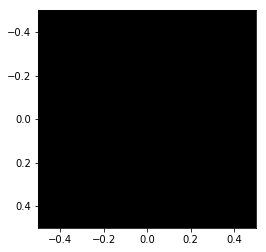

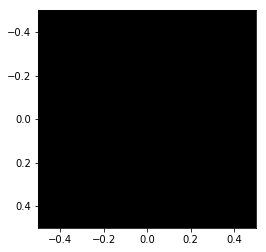

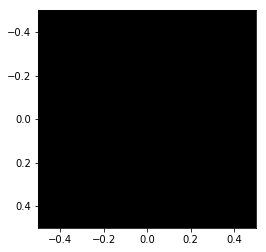

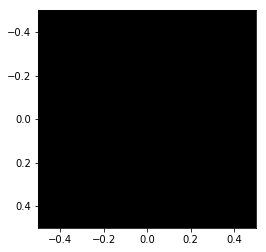

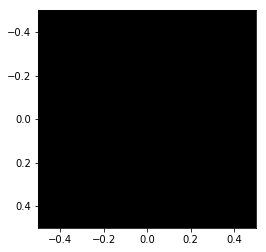

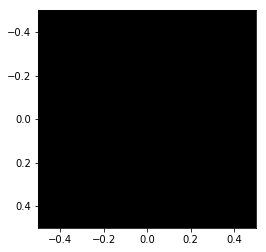

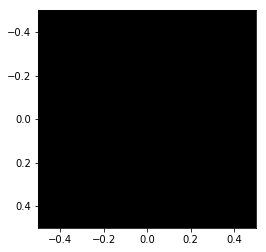

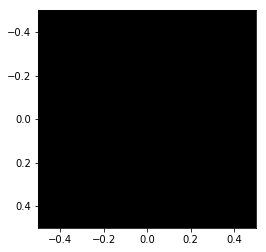

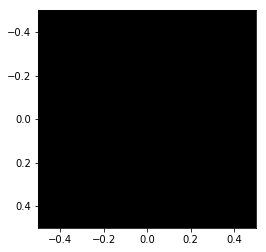



		Feature Map com mínimo = preto : 


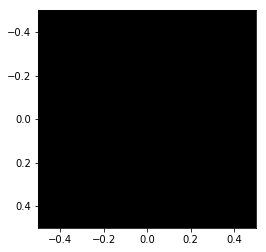

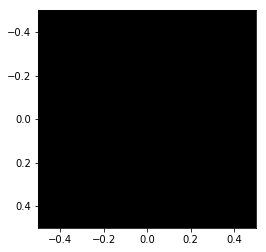

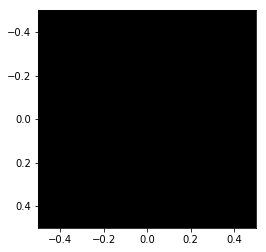

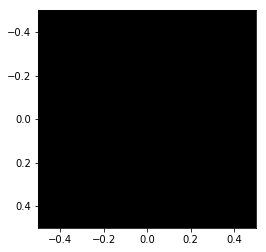

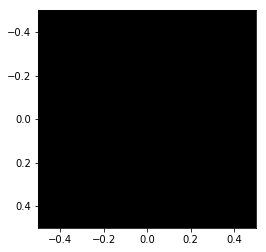

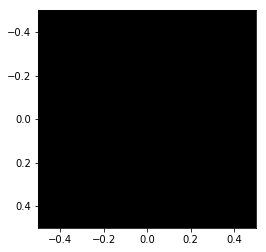

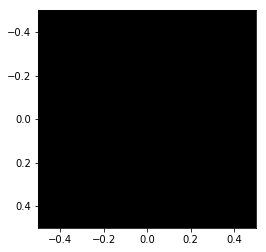

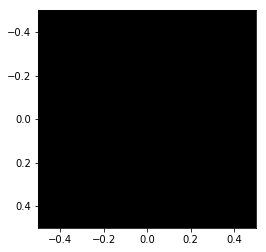

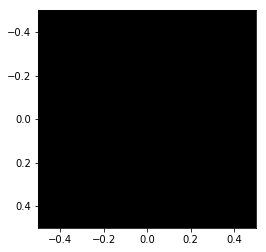

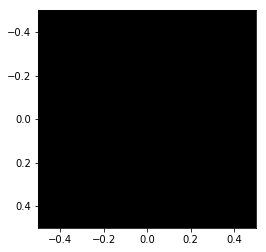



Formato do fmap: 
 (1, 1, 10)


Fmap: 
 [[[9.24726113e-01 5.90234510e-02 9.83999429e-15 5.64534538e-19
   1.62502759e-02 1.57932352e-07 2.62326940e-09 2.11242519e-13
   8.11144684e-17 3.93005323e-15]]]


In [77]:
main()